# Qian's experiment outputs on a regional view

In [ ]:
%matplotlib inline

# Standard modules
import cosima_cookbook as cc
from dask.distributed import Client
import numpy as np
import xarray as xr
import netCDF4 as nc

# For plotting
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import matplotlib.patches as patches
import cmocean as cm

#From file of "Age at the Bottom of the Ocean"
from collections import OrderedDict
import cftime
import glob

#From file of "Cross-slope section"
# For gradient calculation (We will need the topographic gradient to calculate the along-slope velocity component)
import xgcm
# Load metpy module to obtain cross section (Select the conda/analusis3-unstable kernel if you have problems loading this module)
from metpy.interpolate import cross_section

#From file of "barotropic streamfunction"
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

# Avoid the Runtime errors in true_divide encountered when trying to divide by zero
import warnings
warnings.filterwarnings('ignore', category = RuntimeWarning) 

import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

#For xmovies
from xmovie import Movie

In [ ]:
client = Client(n_workers=16)
client

In [ ]:
# Load database
session = cc.database.create_session()

# Start a Cosima cookbook database session

In [5]:
# From file of "Exploring the COSIMA Cookbook"
from cosima_cookbook import explore

dbx = explore.DatabaseExplorer(session=session)
dbx

DatabaseExplorer(children=(HTML(value='<style>.header p{ line-height: 1.4; margin-bottom: 10px }</style>\n    …

## Antarctic shelf & land mask (Analysis Regions p1)

In this study, the ocean with sea floor depth below 1 km is identified as the continental shelf region (Figure *, in blue). ASC is closely following the 1000 m isobath.

In [6]:
def shelf_mask_isobath(var):
    '''
    Masks ACCESS-OM2-01 variables by the region polewards of the 1000m isobath as computed using 
    a script contributed by Adele Morrison.
    Only to be used with ACCESS-OM2-0.1 output!
    '''
    contour_file = np.load('/g/data/ik11/grids/Antarctic_slope_contour_1000m.npz')
    
    shelf_mask = contour_file['contour_masked_above']
    yt_ocean = contour_file['yt_ocean']
    xt_ocean = contour_file['xt_ocean']
    
    # in this file the points along the isobath are given a positive value, the points outside (northwards) 
    # of the isobath are given a value of -100 and all the points on the continental shelf have a value of 0 
    # so we mask for the 0 values 
    shelf_mask[np.where(shelf_mask!=0)] = np.nan
    shelf_mask = shelf_mask+1
    shelf_map = np.nan_to_num(shelf_mask)
    shelf_mask = xr.DataArray(shelf_mask, coords = [('yt_ocean', yt_ocean), ('xt_ocean', xt_ocean)])
    shelf_map = xr.DataArray(shelf_map, coords = [('yt_ocean', yt_ocean), ('xt_ocean', xt_ocean)])
    
    # then we want to multiply the variable with the mask so we need to account for the shape of the mask. 
    # The mask uses a northern cutoff of 59S.
    masked_var = var.sel(yt_ocean = slice(-90, -59.03)) * shelf_mask
    return masked_var, shelf_map

In [8]:
#Generating land and shelf mask
ht = cc.querying.getvar(expt='01deg_jra55v13_ryf9091', variable='ht', session=session, frequency='static', n=1)
ht = ht.sel(yt_ocean = slice(-90, -59))
land_mask = (ht*0).fillna(1)
yt_ocean = ht.yt_ocean.values
xt_ocean = ht.xt_ocean.values
ht_shelf , shelf_mask = shelf_mask_isobath(ht)


fig = plt.figure(num=1,figsize=(10, 10))
ax = plt.subplot(projection=ccrs.SouthPolarStereo())

ax.contour(xt_ocean, yt_ocean, land_mask,[0,1], colors = 'k', alpha = 0.4, transform=ccrs.PlateCarree())
ax.contour(xt_ocean, yt_ocean, shelf_mask.values, [0, 1], colors = 'r', transform=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, -59], ccrs.PlateCarree())

In [9]:
#Land mask for coloring the Antarctica in darkgrey
lat_slice = slice(-90, -59)
hu = cc.querying.getvar(expt='01deg_jra55v13_ryf9091', variable='hu', session=session, frequency='static', n=1)
hu = hu.sel(yu_ocean=lat_slice)

theta  = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.455
verts  = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

land_mask = np.squeeze(hu.values)
land_mask = land_mask * 0
land_mask[np.isnan(land_mask)] = 1
land_mask_masked = np.ma.masked_where((land_mask==0),land_mask)
# make land go all the way to -90S:
land_mask_lat = hu.yu_ocean.values
land_mask_lat[0] = -90

In [ ]:
fig=plt.figure(2,(25,10))
ax = plt.subplot()
ht_plot = ht.sel(yt_ocean = slice(-80,-59)).sel(xt_ocean = slice(-280,80))
levels=[0,500,1000,1500, 2000, 2500, 3000,3500,4000]   
plot = ax.contourf(ht_plot.xt_ocean,ht_plot.yt_ocean,np.squeeze(ht_plot.values),levels=levels,cmap='viridis_r',extend='max')
cax = plt.axes([0.92, 0.2, 0.02, 0.6])
cbar=plt.colorbar(plot, cax = cax,orientation='vertical', shrink = 0.5)
cbar.set_label(r'Bathymetry (m)')

# Plot land in grey
ax.contourf(hu.xu_ocean, land_mask_lat, land_mask_masked, colors='darkgrey', zorder=2)
# Plot coastline in black
ax.contour(hu.xu_ocean, hu.yu_ocean, land_mask, [0,1], colors = 'k', linewidths = 0.5)
# Plot shelf region line
ax.contour(shelf_mask['xt_ocean'], shelf_mask['yt_ocean'], shelf_mask, [0, 1], colors='red')


ax.text(-100, -77.5, 'Antarctica', color = 'black', fontsize=20)
ax.text(-150, -62.5, 'Southern Ocean', color = 'whitesmoke', horizontalalignment='center', fontsize=20)

ax.set_xlim((-280,80))
ax.set_ylim((-80,-59))
ax.set_ylabel('Latitude', fontsize = 28)
ax.set_xlabel('Longitude', fontsize = 28)
ax.set_xticks(np.arange(-280,80,10))


plt.show()

## Experiment:	01deg_jra55v13_ryf9091

Description:	0.1 degree ACCESS-OM2 global model configuration under the RYF9091 Repeat Year Forcing strategy outlined by Stewart et al. (2020), https://doi.org/10.1016/j.ocemod.2019.101557. The configuration is based on that described in Kiss et al. (2020), https://doi.org/10.5194/gmd-13-401-2020, but with many improvements. Initial conditions are WOA13v2 potential temperature and practical salinity. Run with JRA55-do v1.3 RYF9091 forcing. Spin up starts from a nominal year of 1 Jan 1900 and runs to 31 Dec 2100.

Notes:	Additional daily outputs saved from 1 Jan 1950 to 31 Dec 1969 and 1 Jan 2086 to 31 Dec 2100

Contact:	Andy Hogg <andy.hogg@anu.edu.au>

No. files:	12671

Created:	2020-06-11

In [10]:
# Import variables from experiments, convert temperature to degree Celsius
temp_ryf = cc.querying.getvar(expt='01deg_jra55v13_ryf9091', variable='temp', 
                          session=session, frequency='1 monthly',
                          start_time='2100-01-31 00:00:00', 
                          end_time='2140-12-31 00:00:00') - 273.15
salt_ryf = cc.querying.getvar(expt='01deg_jra55v13_ryf9091', variable='salt', 
                          session=session, frequency='1 monthly',
                          start_time='2100-01-31 00:00:00', 
                          end_time='2140-12-31 00:00:00')

# Latitude range (pan-Antarctic)
lat_min = -90
lat_max = -60
# Select latitude range (solving the groupby time:year errors by adding time slice):
temp_ryf = temp_ryf.sel(yt_ocean = slice(lat_min, lat_max)).sel(time=slice('2100-01-01 00:00:00','2140-12-31 00:00:00'))
salt_ryf = salt_ryf.sel(yt_ocean = slice(lat_min, lat_max)).sel(time=slice('2100-01-01 00:00:00','2140-12-31 00:00:00'))

# load in tcell zstar depth edges for weighted averages calculation
st_edges_ocean_ryf = cc.querying.getvar(expt='01deg_jra55v13_ryf9091', variable='st_edges_ocean', 
                          session=session, frequency='1 monthly',
                          start_time='2100-01-31 00:00:00', 
                          end_time='2140-12-31 00:00:00')

# Make a `land_mask`. This is just a dataarray with `1`'s where you have ocean and `0`'s where you have land. 
# This mask is used to delineate Antarctic continental regions.
ht_ryf = cc.querying.getvar(expt='01deg_jra55v13_ryf9091', variable='ht', session=session, frequency='static', n=1)
ht_ryf = ht_ryf.sel(yt_ocean = slice(lat_min, lat_max)) # Select latitude range
land_mask_ryf = ~ht_ryf.isnull()
shelf_mask_ryf = (land_mask_ryf.where(ht_ryf < 1000))

# load in area for weighted average over areas
area_t_ryf = cc.querying.getvar(expt='01deg_jra55v13_ryf9091', variable='area_t',  session=session, frequency='static', n=1)
area_t_ryf = area_t_ryf.sel(yt_ocean = slice(lat_min, lat_max))
area_t_ryf = area_t_ryf.fillna(0) #`weights` cannot contain missing values. Missing values can be replaced by `weights.fillna(0).

## Experiment:	01deg_jra55v13_ryf9091_qian_wthp

Description:	Wind, thermal and humidity perturbation experiment based on CMIP6 future scenario (SSP5-8.5), plus meltwater perturbation

Notes:	If you require any further information, feel free to contact Qian.

Contact:	Qian Li <qian.li5@unsw.edu.au>

No. files:	410

Created:	2021-04-20

In [11]:
# Import variables from experiments, convert temperature to degree Celsius
temp_wthp = cc.querying.getvar(expt='01deg_jra55v13_ryf9091_qian_wthp', variable='temp', 
                          session=session, frequency='1 monthly',
                          start_time='2100-01-31 00:00:00', 
                          end_time='2140-12-31 00:00:00') - 273.15
salt_wthp = cc.querying.getvar(expt='01deg_jra55v13_ryf9091_qian_wthp', variable='salt', 
                          session=session, frequency='1 monthly',
                          start_time='2100-01-31 00:00:00', 
                          end_time='2140-12-31 00:00:00')

# Latitude range (pan-Antarctic)
lat_min = -90
lat_max = -60
# Select latitude range (solving the groupby time:year errors by adding time slice):
temp_wthp = temp_wthp.sel(yt_ocean = slice(lat_min, lat_max)).sel(time=slice('2100-01-01 00:00:00','2140-12-31 00:00:00'))
salt_wthp = salt_wthp.sel(yt_ocean = slice(lat_min, lat_max)).sel(time=slice('2100-01-01 00:00:00','2140-12-31 00:00:00'))

# load in tcell zstar depth edges for weighted averages calculation
st_edges_ocean_wthp = cc.querying.getvar(expt='01deg_jra55v13_ryf9091_qian_wthp', variable='st_edges_ocean', 
                          session=session, frequency='1 monthly',
                          start_time='2100-01-31 00:00:00', 
                          end_time='2140-12-31 00:00:00')

# load in area for weighted average over areas
area_t_wthp = cc.querying.getvar(expt='01deg_jra55v13_ryf9091_qian_wthp', variable='area_t',  session=session, frequency='static', n=1)
area_t_wthp = area_t_wthp.sel(yt_ocean = slice(lat_min, lat_max))
area_t_wthp = area_t_wthp.fillna(0) #`weights` cannot contain missing values. Missing values can be replaced by `weights.fillna(0).

## Experiment:	01deg_jra55v13_ryf9091_qian_wthmp

Description:	Wind, thermal and humidity perturbation experiment based on CMIP6 future scenario (SSP5-8.5)

Notes:	If you require any further information, feel free to contact Qian.

Contact:	Qian Li <qian.li5@unsw.edu.au>

No. files:	390

Created:	2021-04-20

In [12]:
# Import variables from experiments, convert temperature to degree Celsius
temp_wthmp = cc.querying.getvar(expt='01deg_jra55v13_ryf9091_qian_wthmp', variable='temp', 
                          session=session, frequency='1 monthly',
                          start_time='2110-01-31 00:00:00', 
                          end_time='2140-12-31 00:00:00') - 273.15
salt_wthmp = cc.querying.getvar(expt='01deg_jra55v13_ryf9091_qian_wthmp', variable='salt', 
                          session=session, frequency='1 monthly',
                          start_time='2110-01-31 00:00:00', 
                          end_time='2140-12-31 00:00:00')

# Latitude range (pan-Antarctic)
lat_min = -90
lat_max = -60
# Select latitude range (solving the groupby time:year errors by adding time slice):
temp_wthmp = temp_wthmp.sel(yt_ocean = slice(lat_min, lat_max)).sel(time=slice('2110-01-01 00:00:00','2140-12-31 00:00:00'))
salt_wthmp = salt_wthmp.sel(yt_ocean = slice(lat_min, lat_max)).sel(time=slice('2110-01-01 00:00:00','2140-12-31 00:00:00'))

# load in tcell zstar depth edges for weighted averages calculation
st_edges_ocean_wthmp = cc.querying.getvar(expt='01deg_jra55v13_ryf9091_qian_wthmp', variable='st_edges_ocean', 
                          session=session, frequency='1 monthly',
                          start_time='2110-01-31 00:00:00', 
                          end_time='2140-12-31 00:00:00')

# load in area for weighted average over areas
area_t_wthmp = cc.querying.getvar(expt='01deg_jra55v13_ryf9091_qian_wthmp', variable='area_t',  session=session, frequency='static', n=1)
area_t_wthmp = area_t_wthmp.sel(yt_ocean = slice(lat_min, lat_max))
area_t_wthmp = area_t_wthmp.fillna(0) #`weights` cannot contain missing values. Missing values can be replaced by `weights.fillna(0).

## Functions for selecting slices (Analysis Regions p2)

Different depth levels (slice at surface, 250m depth, sea floor and a weighted depth average) are selected to analyse the homogeneity of the changes in the vertical water column.

In [41]:
# Functions for selecting slice of different depths
# Select slice of ocean at surface and 250m depth:
def slice_depth(var_expt,st_depth):
    var_depth_expt = var_expt.sel(st_ocean=st_depth, method='nearest')
    var_depth_shelf_expt = var_depth_expt*shelf_mask
    return var_depth_shelf_expt

# Select slice at sea floor:
def slice_bottom(var_expt):
    var_depth_array_expt = var_expt * 0 + var_expt.st_ocean # Array that has the depth levels
    var_max_depth_expt   = var_depth_array_expt.max(dim='st_ocean', skipna=True) # Get max depth of data (skipping nans)
    # Select the temp using max_depth
    # Bottom is where the depth level is larger/equal the max depth
    var_bottom_expt = var_expt.where(var_depth_array_expt.st_ocean >= var_max_depth_expt)
    var_bottom_expt = var_bottom_expt.sum(dim='st_ocean')
    var_bottom_shelf_expt = var_bottom_expt*shelf_mask
    return var_bottom_shelf_expt

# Weighted average with all depths
def average_st(var_expt,st_edges_ocean_expt):
    thickness_values_expt = np.diff(st_edges_ocean_expt)
    thickness_expt = xr.DataArray(data=thickness_values_expt,dims=["st_ocean"],coords=dict(st_ocean=var_expt.st_ocean.values,),)
    #for coords, st_ocean=var.st_ocean.values.
    weights_st_expt = thickness_expt
    var_st_expt = var_expt.weighted(weights_st_expt).mean('st_ocean')
    var_st_shelf_expt = var_st_expt*shelf_mask
    return var_st_shelf_expt

### Calculate slices of monthly and annual time series (Analysis Regions p3)

The temperature changes due to melting and warming perturbation individually could be calculated by subracting among ocean temperatures among different experiments. The temperature anomaly under melting is suggested by difference between WTHP and WTHMP experiments, while the temperature anomaly under warming is suggested by difference between WTHP and control experiments.

In [42]:
# Select slice of ocean at surface and 250m depth:
temp_surface_shelf_ryf = slice_depth(temp_ryf,0)
temp_surface_shelf_ryf_annual_mean = temp_surface_shelf_ryf.groupby('time.year').mean(dim='time')
salt_surface_shelf_ryf = slice_depth(salt_ryf,0)
salt_surface_shelf_ryf_annual_mean = salt_surface_shelf_ryf.groupby('time.year').mean(dim='time')
temp_250m_shelf_ryf = slice_depth(temp_ryf,250)
temp_250m_shelf_ryf_annual_mean = temp_250m_shelf_ryf.groupby('time.year').mean(dim='time')
salt_250m_shelf_ryf = slice_depth(salt_ryf,250)
salt_250m_shelf_ryf_annual_mean = temp_250m_shelf_ryf.groupby('time.year').mean(dim='time')
temp_surface_shelf_wthp = slice_depth(temp_wthp,0)
temp_surface_shelf_wthp_annual_mean = temp_surface_shelf_wthp.groupby('time.year').mean(dim='time')
salt_surface_shelf_wthp = slice_depth(salt_wthp,0)
salt_surface_shelf_wthp_annual_mean = salt_surface_shelf_wthp.groupby('time.year').mean(dim='time')
temp_250m_shelf_wthp = slice_depth(temp_wthp,250)
temp_250m_shelf_wthp_annual_mean = temp_250m_shelf_wthp.groupby('time.year').mean(dim='time')
salt_250m_shelf_wthp = slice_depth(salt_wthp,250)
salt_250m_shelf_wthp_annual_mean = salt_250m_shelf_wthp.groupby('time.year').mean(dim='time')
temp_surface_shelf_wthmp = slice_depth(temp_wthmp,0)
temp_surface_shelf_wthmp_annual_mean = temp_surface_shelf_wthmp.groupby('time.year').mean(dim='time')
salt_surface_shelf_wthmp = slice_depth(salt_wthmp,0)
salt_surface_shelf_wthmp_annual_mean = salt_surface_shelf_wthmp.groupby('time.year').mean(dim='time')
temp_250m_shelf_wthmp = slice_depth(temp_wthmp,250)
temp_250m_shelf_wthmp_annual_mean = temp_250m_shelf_wthmp.groupby('time.year').mean(dim='time')
salt_250m_shelf_wthmp = slice_depth(salt_wthmp,250)
salt_250m_shelf_wthmp_annual_mean = salt_250m_shelf_wthmp.groupby('time.year').mean(dim='time')

# Select slice at sea floor:
temp_bottom_shelf_ryf = slice_bottom(temp_ryf)
temp_bottom_shelf_ryf_annual_mean = temp_bottom_shelf_ryf.groupby('time.year').mean(dim='time')
salt_bottom_shelf_ryf = slice_bottom(salt_ryf)
salt_bottom_shelf_ryf_annual_mean = salt_bottom_shelf_ryf.groupby('time.year').mean(dim='time')
temp_bottom_shelf_wthp = slice_bottom(temp_wthp)
temp_bottom_shelf_wthp_annual_mean = temp_bottom_shelf_wthp.groupby('time.year').mean(dim='time')
salt_bottom_shelf_wthp = slice_bottom(salt_wthp)
salt_bottom_shelf_wthp_annual_mean = salt_bottom_shelf_wthp.groupby('time.year').mean(dim='time')
temp_bottom_shelf_wthmp = slice_bottom(temp_wthmp)
temp_bottom_shelf_wthmp_annual_mean = temp_bottom_shelf_wthmp.groupby('time.year').mean(dim='time')
salt_bottom_shelf_wthmp = slice_bottom(salt_wthmp)
salt_bottom_shelf_wthmp_annual_mean = salt_bottom_shelf_wthmp.groupby('time.year').mean(dim='time')

# Weighted average with all depths
temp_st_shelf_ryf = average_st(temp_ryf,st_edges_ocean_ryf)
temp_st_shelf_ryf_annual_mean = temp_st_shelf_ryf.groupby('time.year').mean(dim='time')
salt_st_shelf_ryf = average_st(salt_ryf,st_edges_ocean_ryf)
salt_st_shelf_ryf_annual_mean = salt_st_shelf_ryf.groupby('time.year').mean(dim='time')
temp_st_shelf_wthp = average_st(temp_wthp,st_edges_ocean_wthp)
temp_st_shelf_wthp_annual_mean = temp_st_shelf_wthp.groupby('time.year').mean(dim='time')
salt_st_shelf_wthp = average_st(salt_wthp,st_edges_ocean_wthp)
salt_st_shelf_wthp_annual_mean = salt_st_shelf_wthp.groupby('time.year').mean(dim='time')
temp_st_shelf_wthmp = average_st(temp_wthmp,st_edges_ocean_wthmp)
temp_st_shelf_wthmp_annual_mean = temp_st_shelf_wthmp.groupby('time.year').mean(dim='time')
salt_st_shelf_wthmp = average_st(salt_wthmp,st_edges_ocean_wthmp)
salt_st_shelf_wthmp_annual_mean = salt_st_shelf_wthmp.groupby('time.year').mean(dim='time')

In [43]:
# Experimental anomaly
temp_st_shelf_warmanom = (temp_st_shelf_wthp - temp_st_shelf_ryf).sel(time=slice('2100-01-01 00:00:00','2140-12-31 00:00:00'))
temp_st_shelf_warmanom_annual_mean = temp_st_shelf_warmanom.groupby('time.year').mean(dim='time')
temp_st_shelf_meltanom = (temp_st_shelf_wthmp - temp_st_shelf_wthp).sel(time=slice('2110-01-01 00:00:00','2140-12-31 00:00:00'))
temp_st_shelf_meltanom_annual_mean = temp_st_shelf_meltanom.groupby('time.year').mean(dim='time')
temp_st_shelf_warmmeltanom = (temp_st_shelf_wthmp - temp_st_shelf_ryf).sel(time=slice('2110-01-01 00:00:00','2140-12-31 00:00:00'))
temp_st_shelf_warmmeltanom_annual_mean = temp_st_shelf_warmmeltanom.groupby('time.year').mean(dim='time')

temp_surface_shelf_warmanom = (temp_surface_shelf_wthp - temp_surface_shelf_ryf).sel(time=slice('2100-01-01 00:00:00','2140-12-31 00:00:00'))
temp_surface_shelf_warmanom_annual_mean = temp_surface_shelf_warmanom.groupby('time.year').mean(dim='time')
temp_surface_shelf_meltanom = (temp_surface_shelf_wthmp - temp_surface_shelf_wthp).sel(time=slice('2110-01-01 00:00:00','2140-12-31 00:00:00'))
temp_surface_shelf_meltanom_annual_mean = temp_surface_shelf_meltanom.groupby('time.year').mean(dim='time')
temp_surface_shelf_warmmeltanom = (temp_surface_shelf_wthmp - temp_surface_shelf_ryf).sel(time=slice('2110-01-01 00:00:00','2140-12-31 00:00:00'))
temp_surface_shelf_warmmeltanom_annual_mean = temp_surface_shelf_warmmeltanom.groupby('time.year').mean(dim='time')

temp_250m_shelf_warmanom = (temp_250m_shelf_wthp - temp_250m_shelf_ryf).sel(time=slice('2100-01-01 00:00:00','2140-12-31 00:00:00'))
temp_250m_shelf_warmanom_annual_mean = temp_250m_shelf_warmanom.groupby('time.year').mean(dim='time')
temp_250m_shelf_meltanom = (temp_250m_shelf_wthmp - temp_250m_shelf_wthp).sel(time=slice('2110-01-01 00:00:00','2140-12-31 00:00:00'))
temp_250m_shelf_meltanom_annual_mean = temp_250m_shelf_meltanom.groupby('time.year').mean(dim='time')
temp_250m_shelf_warmmeltanom = (temp_250m_shelf_wthmp - temp_250m_shelf_ryf).sel(time=slice('2110-01-01 00:00:00','2140-12-31 00:00:00'))
temp_250m_shelf_warmmeltanom_annual_mean = temp_250m_shelf_warmmeltanom.groupby('time.year').mean(dim='time')

temp_bottom_shelf_warmanom = (temp_bottom_shelf_wthp - temp_bottom_shelf_ryf).sel(time=slice('2100-01-01 00:00:00','2140-12-31 00:00:00'))
temp_bottom_shelf_warmanom_annual_mean = temp_bottom_shelf_warmanom.groupby('time.year').mean(dim='time')
temp_bottom_shelf_meltanom = (temp_bottom_shelf_wthmp - temp_bottom_shelf_wthp).sel(time=slice('2110-01-01 00:00:00','2140-12-31 00:00:00'))
temp_bottom_shelf_meltanom_annual_mean = temp_bottom_shelf_meltanom.groupby('time.year').mean(dim='time')
temp_bottom_shelf_warmmeltanom = (temp_bottom_shelf_wthmp - temp_bottom_shelf_ryf).sel(time=slice('2110-01-01 00:00:00','2140-12-31 00:00:00'))
temp_bottom_shelf_warmmeltanom_annual_mean = temp_bottom_shelf_warmmeltanom.groupby('time.year').mean(dim='time')

salt_st_shelf_warmanom = (salt_st_shelf_wthp - salt_st_shelf_ryf).sel(time=slice('2100-01-01 00:00:00','2140-12-31 00:00:00'))
salt_st_shelf_warmanom_annual_mean = salt_st_shelf_warmanom.groupby('time.year').mean(dim='time')
salt_st_shelf_meltanom = (salt_st_shelf_wthmp - salt_st_shelf_wthp).sel(time=slice('2110-01-01 00:00:00','2140-12-31 00:00:00'))
salt_st_shelf_meltanom_annual_mean = salt_st_shelf_meltanom.groupby('time.year').mean(dim='time')
salt_st_shelf_warmmeltanom = (salt_st_shelf_wthmp - salt_st_shelf_ryf).sel(time=slice('2110-01-01 00:00:00','2140-12-31 00:00:00'))
salt_st_shelf_warmmeltanom_annual_mean = salt_st_shelf_warmmeltanom.groupby('time.year').mean(dim='time')

salt_surface_shelf_warmanom = (salt_surface_shelf_wthp - salt_surface_shelf_ryf).sel(time=slice('2100-01-01 00:00:00','2140-12-31 00:00:00'))
salt_surface_shelf_warmanom_annual_mean = salt_surface_shelf_warmanom.groupby('time.year').mean(dim='time')
salt_surface_shelf_meltanom = (salt_surface_shelf_wthmp - salt_surface_shelf_wthp).sel(time=slice('2110-01-01 00:00:00','2140-12-31 00:00:00'))
salt_surface_shelf_meltanom_annual_mean = salt_surface_shelf_meltanom.groupby('time.year').mean(dim='time')
salt_surface_shelf_warmmeltanom = (salt_surface_shelf_wthmp - salt_surface_shelf_ryf).sel(time=slice('2110-01-01 00:00:00','2140-12-31 00:00:00'))
salt_surface_shelf_warmmeltanom_annual_mean = salt_surface_shelf_warmmeltanom.groupby('time.year').mean(dim='time')

salt_250m_shelf_warmanom = (salt_250m_shelf_wthp - salt_250m_shelf_ryf).sel(time=slice('2100-01-01 00:00:00','2140-12-31 00:00:00'))
salt_250m_shelf_warmanom_annual_mean = salt_250m_shelf_warmanom.groupby('time.year').mean(dim='time')
salt_250m_shelf_meltanom = (salt_250m_shelf_wthmp - salt_250m_shelf_wthp).sel(time=slice('2110-01-01 00:00:00','2140-12-31 00:00:00'))
salt_250m_shelf_meltanom_annual_mean = salt_250m_shelf_meltanom.groupby('time.year').mean(dim='time')
salt_250m_shelf_warmmeltanom = (salt_250m_shelf_wthmp - salt_250m_shelf_ryf).sel(time=slice('2110-01-01 00:00:00','2140-12-31 00:00:00'))
salt_250m_shelf_warmmeltanom_annual_mean = salt_250m_shelf_warmmeltanom.groupby('time.year').mean(dim='time')

salt_bottom_shelf_warmanom = (salt_bottom_shelf_wthp - salt_bottom_shelf_ryf).sel(time=slice('2100-01-01 00:00:00','2140-12-31 00:00:00'))
salt_bottom_shelf_warmanom_annual_mean = salt_bottom_shelf_warmanom.groupby('time.year').mean(dim='time')
salt_bottom_shelf_meltanom = (salt_bottom_shelf_wthmp - salt_bottom_shelf_wthp).sel(time=slice('2110-01-01 00:00:00','2140-12-31 00:00:00'))
salt_bottom_shelf_meltanom_annual_mean = salt_bottom_shelf_meltanom.groupby('time.year').mean(dim='time')
salt_bottom_shelf_warmmeltanom = (salt_bottom_shelf_wthmp - salt_bottom_shelf_ryf).sel(time=slice('2110-01-01 00:00:00','2140-12-31 00:00:00'))
salt_bottom_shelf_warmmeltanom_annual_mean = salt_bottom_shelf_warmmeltanom.groupby('time.year').mean(dim='time')

# Region Selection (Analysis regions p4)

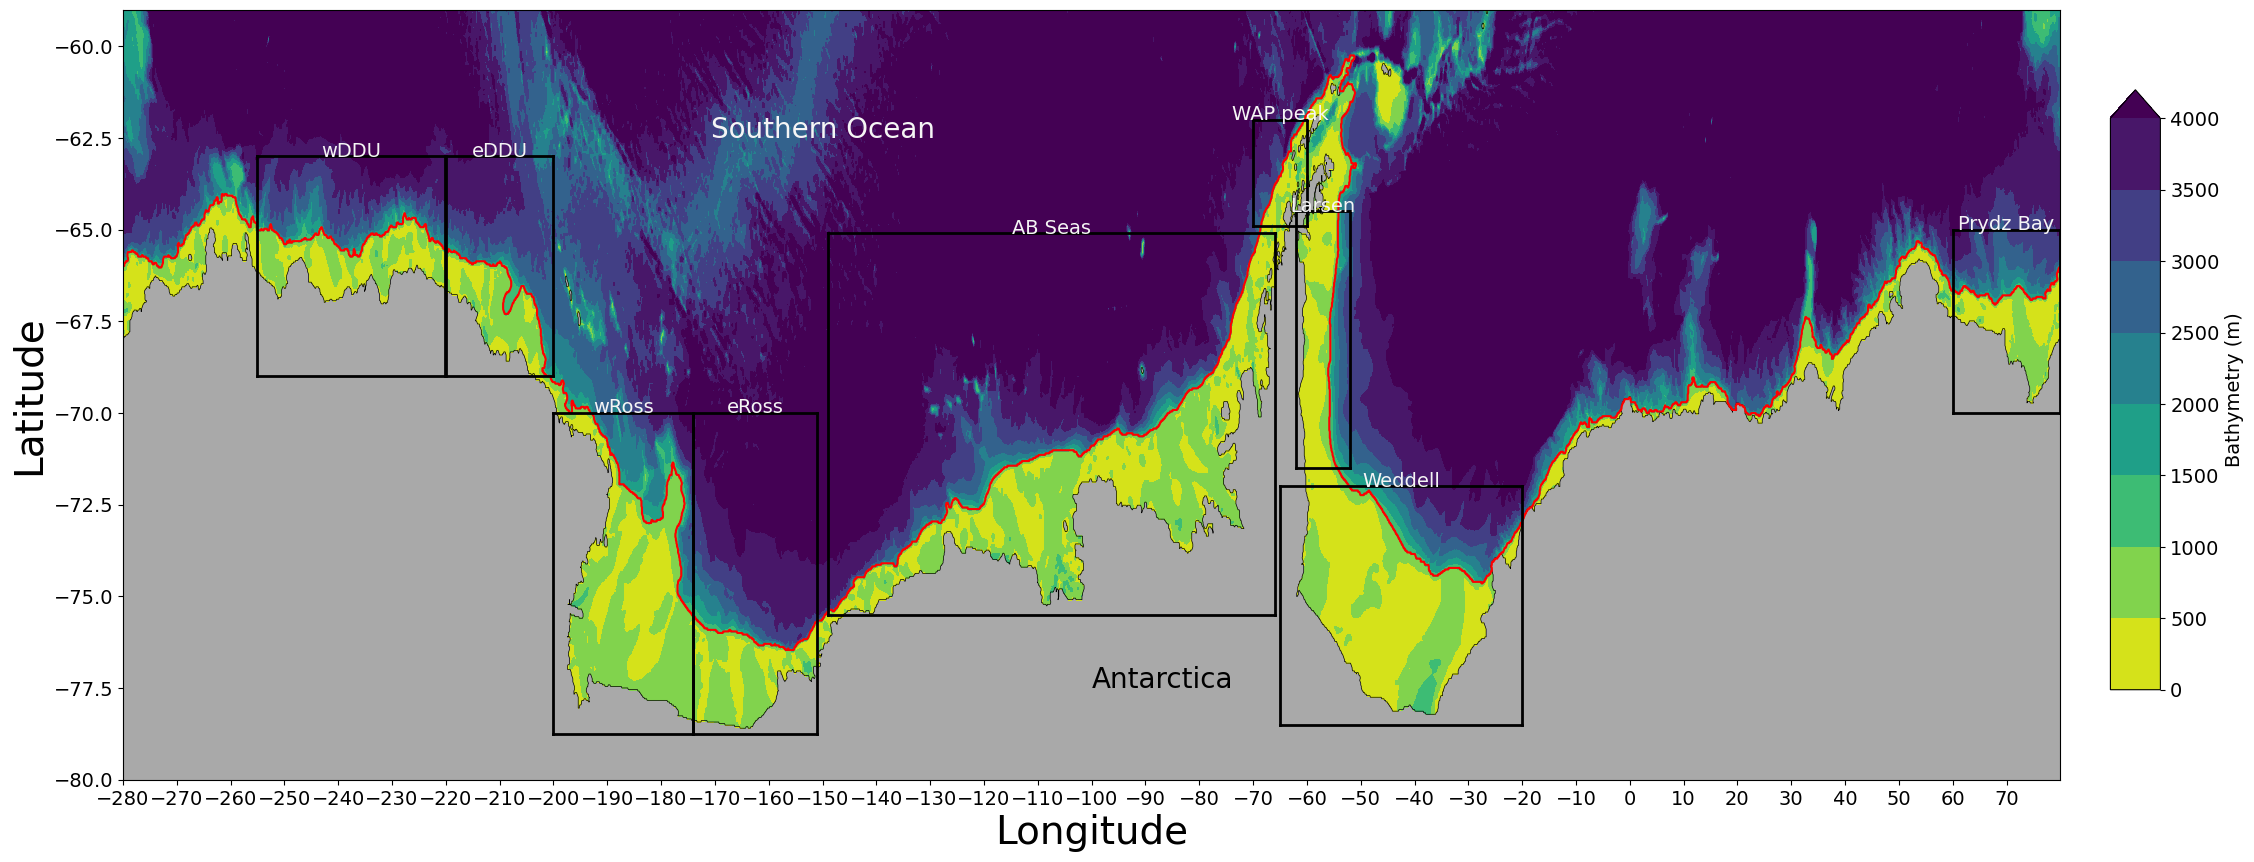

In [105]:
ht = cc.querying.getvar(expt='01deg_jra55v13_ryf9091', variable='ht', session=session, frequency='static', n=1)

fig=plt.figure(2,(25,10))
ax = plt.subplot()
ht_plot = ht.sel(yt_ocean = slice(-80,-59)).sel(xt_ocean = slice(-280,80))
levels=[0,500,1000,1500, 2000, 2500, 3000,3500,4000]   
plot = ax.contourf(ht_plot.xt_ocean,ht_plot.yt_ocean,np.squeeze(ht_plot.values),levels=levels,cmap='viridis_r',extend='max')
cax = plt.axes([0.92, 0.2, 0.02, 0.6])
cbar=plt.colorbar(plot, cax = cax,orientation='vertical', shrink = 0.5)
cbar.set_label(r'Bathymetry (m)')

# Plot land in grey
ax.contourf(hu.xu_ocean, land_mask_lat, land_mask_masked, colors='darkgrey', zorder=2)
# Plot coastline in black
ax.contour(hu.xu_ocean, hu.yu_ocean, land_mask, [0,1], colors = 'k', linewidths = 0.5)
# Plot shelf region line
ax.contour(shelf_mask['xt_ocean'], shelf_mask['yt_ocean'], shelf_mask, [0, 1], colors='red')


ax.text(-100, -77.5, 'Antarctica', color = 'black', fontsize=20)
ax.text(-150, -62.5, 'Southern Ocean', color = 'whitesmoke', horizontalalignment='center', fontsize=20)

ax.set_xlim((-280,80))
ax.set_ylim((-80,-59))
ax.set_ylabel('Latitude', fontsize = 28)
ax.set_xlabel('Longitude', fontsize = 28)
ax.set_xticks(np.arange(-280,80,10))

def drawing_boxes(bottomleft_lon,bottomleft_lat,topright_lon,topright_lat,region_name):
    ax.plot([bottomleft_lon,topright_lon], [bottomleft_lat,bottomleft_lat], 'black', linewidth = 2)
    ax.plot([bottomleft_lon,topright_lon], [topright_lat,topright_lat], 'black', linewidth = 2)
    ax.plot([bottomleft_lon,bottomleft_lon], [bottomleft_lat,topright_lat], 'black', linewidth = 2)
    ax.plot([topright_lon,topright_lon], [bottomleft_lat,topright_lat], 'black', linewidth = 2)
    ax.text((bottomleft_lon+topright_lon)/2, topright_lat, region_name, color = 'whitesmoke', horizontalalignment='center')

drawing_boxes(-255,-69,-220.1,-63,'wDDU') #west Dumont d'Urville Sea shelf region
drawing_boxes(-219.9,-69,-200,-63,'eDDU') #east Dumont d'Urville Sea shelf region
drawing_boxes(-200,-78.75,-174.1,-70,'wRoss') #west Ross Sea coastal shelf region
drawing_boxes(-174,-78.75,-151,-70,'eRoss') #east Ross Sea coastal shelf region
drawing_boxes(-149,-75.5,-66,-65.1,'AB Seas') #Amundsen-Bellingshausen Seas shelf region
drawing_boxes(-70,-64.9,-60,-62,'WAP peak') #peak of West Antarctic Peninsula shelf region
drawing_boxes(-62,-71.5,-52,-64.5,'Larsen') #Larsen shelf region
drawing_boxes(-65,-78.5,-20,-72,'Weddell') #Weddell Sea coastal shelf region
drawing_boxes(60,-70,80,-65,'Prydz Bay') #Prydz Bay shelf region

plt.show()

### Functions for regional monthly mean

In [19]:
def monthly_mean(var,area_t_expt,bottomleft_lon,bottomleft_lat,topright_lon,topright_lat):
    var_regional = var.sel(xt_ocean=slice(bottomleft_lon,topright_lon),yt_ocean=slice(bottomleft_lat,topright_lat)).weighted(area_t_expt)
    #Create time series for different regions by averaging over lon-lat (359 months)
    var_regional_mean = var_regional.mean(("xt_ocean", "yt_ocean"))
    return var_regional_mean

In [20]:
#For each region
temp_st_shelf_ryf_wDDU_monthly_mean = monthly_mean(temp_st_shelf_ryf,area_t_ryf,-255,-69,-220.1,-63)
temp_surface_shelf_ryf_wDDU_monthly_mean = monthly_mean(temp_surface_shelf_ryf,area_t_ryf,-255,-69,-220.1,-63)
temp_250m_shelf_ryf_wDDU_monthly_mean = monthly_mean(temp_250m_shelf_ryf,area_t_ryf,-255,-69,-220.1,-63)
temp_bottom_shelf_ryf_wDDU_monthly_mean = monthly_mean(temp_bottom_shelf_ryf,area_t_ryf,-255,-69,-220.1,-63)
temp_st_shelf_wthp_wDDU_monthly_mean = monthly_mean(temp_st_shelf_wthp,area_t_wthp,-255,-69,-220.1,-63)
temp_surface_shelf_wthp_wDDU_monthly_mean = monthly_mean(temp_surface_shelf_wthp,area_t_wthp,-255,-69,-220.1,-63)
temp_250m_shelf_wthp_wDDU_monthly_mean = monthly_mean(temp_250m_shelf_wthp,area_t_wthp,-255,-69,-220.1,-63)
temp_bottom_shelf_wthp_wDDU_monthly_mean = monthly_mean(temp_bottom_shelf_wthp,area_t_wthp,-255,-69,-220.1,-63)
temp_st_shelf_wthmp_wDDU_monthly_mean = monthly_mean(temp_st_shelf_wthmp,area_t_wthmp,-255,-69,-220.1,-63)
temp_surface_shelf_wthmp_wDDU_monthly_mean = monthly_mean(temp_surface_shelf_wthmp,area_t_wthmp,-255,-69,-220.1,-63)
temp_250m_shelf_wthmp_wDDU_monthly_mean = monthly_mean(temp_250m_shelf_wthmp,area_t_wthmp,-255,-69,-220.1,-63)
temp_bottom_shelf_wthmp_wDDU_monthly_mean = monthly_mean(temp_bottom_shelf_wthmp,area_t_wthmp,-255,-69,-220.1,-63)
salt_st_shelf_ryf_wDDU_monthly_mean = monthly_mean(salt_st_shelf_ryf,area_t_ryf,-255,-69,-220.1,-63)
salt_surface_shelf_ryf_wDDU_monthly_mean = monthly_mean(salt_surface_shelf_ryf,area_t_ryf,-255,-69,-220.1,-63)
salt_250m_shelf_ryf_wDDU_monthly_mean = monthly_mean(salt_250m_shelf_ryf,area_t_ryf,-255,-69,-220.1,-63)
salt_bottom_shelf_ryf_wDDU_monthly_mean = monthly_mean(salt_bottom_shelf_ryf,area_t_ryf,-255,-69,-220.1,-63)
salt_st_shelf_wthp_wDDU_monthly_mean = monthly_mean(salt_st_shelf_wthp,area_t_wthp,-255,-69,-220.1,-63)
salt_surface_shelf_wthp_wDDU_monthly_mean = monthly_mean(salt_surface_shelf_wthp,area_t_wthp,-255,-69,-220.1,-63)
salt_250m_shelf_wthp_wDDU_monthly_mean = monthly_mean(salt_250m_shelf_wthp,area_t_wthp,-255,-69,-220.1,-63)
salt_bottom_shelf_wthp_wDDU_monthly_mean = monthly_mean(salt_bottom_shelf_wthp,area_t_wthp,-255,-69,-220.1,-63)
salt_st_shelf_wthmp_wDDU_monthly_mean = monthly_mean(salt_st_shelf_wthmp,area_t_wthmp,-255,-69,-220.1,-63)
salt_surface_shelf_wthmp_wDDU_monthly_mean = monthly_mean(salt_surface_shelf_wthmp,area_t_wthmp,-255,-69,-220.1,-63)
salt_250m_shelf_wthmp_wDDU_monthly_mean = monthly_mean(salt_250m_shelf_wthmp,area_t_wthmp,-255,-69,-220.1,-63)
salt_bottom_shelf_wthmp_wDDU_monthly_mean = monthly_mean(salt_bottom_shelf_wthmp,area_t_wthmp,-255,-69,-220.1,-63)

temp_st_shelf_ryf_eDDU_monthly_mean = monthly_mean(temp_st_shelf_ryf,area_t_ryf,-219.9,-69,-200,-63)
temp_surface_shelf_ryf_eDDU_monthly_mean = monthly_mean(temp_surface_shelf_ryf,area_t_ryf,-219.9,-69,-200,-63)
temp_250m_shelf_ryf_eDDU_monthly_mean = monthly_mean(temp_250m_shelf_ryf,area_t_ryf,-219.9,-69,-200,-63)
temp_bottom_shelf_ryf_eDDU_monthly_mean = monthly_mean(temp_bottom_shelf_ryf,area_t_ryf,-219.9,-69,-200,-63)
temp_st_shelf_wthp_eDDU_monthly_mean = monthly_mean(temp_st_shelf_wthp,area_t_wthp,-219.9,-69,-200,-63)
temp_surface_shelf_wthp_eDDU_monthly_mean = monthly_mean(temp_surface_shelf_wthp,area_t_wthp,-219.9,-69,-200,-63)
temp_250m_shelf_wthp_eDDU_monthly_mean = monthly_mean(temp_250m_shelf_wthp,area_t_wthp,-219.9,-69,-200,-63)
temp_bottom_shelf_wthp_eDDU_monthly_mean = monthly_mean(temp_bottom_shelf_wthp,area_t_wthp,-219.9,-69,-200,-63)
temp_st_shelf_wthmp_eDDU_monthly_mean = monthly_mean(temp_st_shelf_wthmp,area_t_wthmp,-219.9,-69,-200,-63)
temp_surface_shelf_wthmp_eDDU_monthly_mean = monthly_mean(temp_surface_shelf_wthmp,area_t_wthmp,-219.9,-69,-200,-63)
temp_250m_shelf_wthmp_eDDU_monthly_mean = monthly_mean(temp_250m_shelf_wthmp,area_t_wthmp,-219.9,-69,-200,-63)
temp_bottom_shelf_wthmp_eDDU_monthly_mean = monthly_mean(temp_bottom_shelf_wthmp,area_t_wthmp,-219.9,-69,-200,-63)
salt_st_shelf_ryf_eDDU_monthly_mean = monthly_mean(salt_st_shelf_ryf,area_t_ryf,-219.9,-69,-200,-63)
salt_surface_shelf_ryf_eDDU_monthly_mean = monthly_mean(salt_surface_shelf_ryf,area_t_ryf,-219.9,-69,-200,-63)
salt_250m_shelf_ryf_eDDU_monthly_mean = monthly_mean(salt_250m_shelf_ryf,area_t_ryf,-219.9,-69,-200,-63)
salt_bottom_shelf_ryf_eDDU_monthly_mean = monthly_mean(salt_bottom_shelf_ryf,area_t_ryf,-219.9,-69,-200,-63)
salt_st_shelf_wthp_eDDU_monthly_mean = monthly_mean(salt_st_shelf_wthp,area_t_wthp,-219.9,-69,-200,-63)
salt_surface_shelf_wthp_eDDU_monthly_mean = monthly_mean(salt_surface_shelf_wthp,area_t_wthp,-219.9,-69,-200,-63)
salt_250m_shelf_wthp_eDDU_monthly_mean = monthly_mean(salt_250m_shelf_wthp,area_t_wthp,-219.9,-69,-200,-63)
salt_bottom_shelf_wthp_eDDU_monthly_mean = monthly_mean(salt_bottom_shelf_wthp,area_t_wthp,-219.9,-69,-200,-63)
salt_st_shelf_wthmp_eDDU_monthly_mean = monthly_mean(salt_st_shelf_wthmp,area_t_wthmp,-219.9,-69,-200,-63)
salt_surface_shelf_wthmp_eDDU_monthly_mean = monthly_mean(salt_surface_shelf_wthmp,area_t_wthmp,-219.9,-69,-200,-63)
salt_250m_shelf_wthmp_eDDU_monthly_mean = monthly_mean(salt_250m_shelf_wthmp,area_t_wthmp,-219.9,-69,-200,-63)
salt_bottom_shelf_wthmp_eDDU_monthly_mean = monthly_mean(salt_bottom_shelf_wthmp,area_t_wthmp,-219.9,-69,-200,-63)

temp_st_shelf_ryf_wRoss_monthly_mean = monthly_mean(temp_st_shelf_ryf,area_t_ryf,-200,-78.75,-174.1,-70)
temp_surface_shelf_ryf_wRoss_monthly_mean = monthly_mean(temp_surface_shelf_ryf,area_t_ryf,-200,-78.75,-174.1,-70)
temp_250m_shelf_ryf_wRoss_monthly_mean = monthly_mean(temp_250m_shelf_ryf,area_t_ryf,-200,-78.75,-174.1,-70)
temp_bottom_shelf_ryf_wRoss_monthly_mean = monthly_mean(temp_bottom_shelf_ryf,area_t_ryf,-200,-78.75,-174.1,-70)
temp_st_shelf_wthp_wRoss_monthly_mean = monthly_mean(temp_st_shelf_wthp,area_t_wthp,-200,-78.75,-174.1,-70)
temp_surface_shelf_wthp_wRoss_monthly_mean = monthly_mean(temp_surface_shelf_wthp,area_t_wthp,-200,-78.75,-174.1,-70)
temp_250m_shelf_wthp_wRoss_monthly_mean = monthly_mean(temp_250m_shelf_wthp,area_t_wthp,-200,-78.75,-174.1,-70)
temp_bottom_shelf_wthp_wRoss_monthly_mean = monthly_mean(temp_bottom_shelf_wthp,area_t_wthp,-200,-78.75,-174.1,-70)
temp_st_shelf_wthmp_wRoss_monthly_mean = monthly_mean(temp_st_shelf_wthmp,area_t_wthmp,-200,-78.75,-174.1,-70)
temp_surface_shelf_wthmp_wRoss_monthly_mean = monthly_mean(temp_surface_shelf_wthmp,area_t_wthmp,-200,-78.75,-174.1,-70)
temp_250m_shelf_wthmp_wRoss_monthly_mean = monthly_mean(temp_250m_shelf_wthmp,area_t_wthmp,-200,-78.75,-174.1,-70)
temp_bottom_shelf_wthmp_wRoss_monthly_mean = monthly_mean(temp_bottom_shelf_wthmp,area_t_wthmp,-200,-78.75,-174.1,-70)
salt_st_shelf_ryf_wRoss_monthly_mean = monthly_mean(salt_st_shelf_ryf,area_t_ryf,-200,-78.75,-174.1,-70)
salt_surface_shelf_ryf_wRoss_monthly_mean = monthly_mean(salt_surface_shelf_ryf,area_t_ryf,-200,-78.75,-174.1,-70)
salt_250m_shelf_ryf_wRoss_monthly_mean = monthly_mean(salt_250m_shelf_ryf,area_t_ryf,-200,-78.75,-174.1,-70)
salt_bottom_shelf_ryf_wRoss_monthly_mean = monthly_mean(salt_bottom_shelf_ryf,area_t_ryf,-200,-78.75,-174.1,-70)
salt_st_shelf_wthp_wRoss_monthly_mean = monthly_mean(salt_st_shelf_wthp,area_t_wthp,-200,-78.75,-174.1,-70)
salt_surface_shelf_wthp_wRoss_monthly_mean = monthly_mean(salt_surface_shelf_wthp,area_t_wthp,-200,-78.75,-174.1,-70)
salt_250m_shelf_wthp_wRoss_monthly_mean = monthly_mean(salt_250m_shelf_wthp,area_t_wthp,-200,-78.75,-174.1,-70)
salt_bottom_shelf_wthp_wRoss_monthly_mean = monthly_mean(salt_bottom_shelf_wthp,area_t_wthp,-200,-78.75,-174.1,-70)
salt_st_shelf_wthmp_wRoss_monthly_mean = monthly_mean(salt_st_shelf_wthmp,area_t_wthmp,-200,-78.75,-174.1,-70)
salt_surface_shelf_wthmp_wRoss_monthly_mean = monthly_mean(salt_surface_shelf_wthmp,area_t_wthmp,-200,-78.75,-174.1,-70)
salt_250m_shelf_wthmp_wRoss_monthly_mean = monthly_mean(salt_250m_shelf_wthmp,area_t_wthmp,-200,-78.75,-174.1,-70)
salt_bottom_shelf_wthmp_wRoss_monthly_mean = monthly_mean(salt_bottom_shelf_wthmp,area_t_wthmp,-200,-78.75,-174.1,-70)

temp_st_shelf_ryf_eRoss_monthly_mean = monthly_mean(temp_st_shelf_ryf,area_t_ryf,-174,-78.75,-151,-70)
temp_surface_shelf_ryf_eRoss_monthly_mean = monthly_mean(temp_surface_shelf_ryf,area_t_ryf,-174,-78.75,-151,-70)
temp_250m_shelf_ryf_eRoss_monthly_mean = monthly_mean(temp_250m_shelf_ryf,area_t_ryf,-174,-78.75,-151,-70)
temp_bottom_shelf_ryf_eRoss_monthly_mean = monthly_mean(temp_bottom_shelf_ryf,area_t_ryf,-174,-78.75,-151,-70)
temp_st_shelf_wthp_eRoss_monthly_mean = monthly_mean(temp_st_shelf_wthp,area_t_wthp,-174,-78.75,-151,-70)
temp_surface_shelf_wthp_eRoss_monthly_mean = monthly_mean(temp_surface_shelf_wthp,area_t_wthp,-174,-78.75,-151,-70)
temp_250m_shelf_wthp_eRoss_monthly_mean = monthly_mean(temp_250m_shelf_wthp,area_t_wthp,-174,-78.75,-151,-70)
temp_bottom_shelf_wthp_eRoss_monthly_mean = monthly_mean(temp_bottom_shelf_wthp,area_t_wthp,-174,-78.75,-151,-70)
temp_st_shelf_wthmp_eRoss_monthly_mean = monthly_mean(temp_st_shelf_wthmp,area_t_wthmp,-174,-78.75,-151,-70)
temp_surface_shelf_wthmp_eRoss_monthly_mean = monthly_mean(temp_surface_shelf_wthmp,area_t_wthmp,-174,-78.75,-151,-70)
temp_250m_shelf_wthmp_eRoss_monthly_mean = monthly_mean(temp_250m_shelf_wthmp,area_t_wthmp,-174,-78.75,-151,-70)
temp_bottom_shelf_wthmp_eRoss_monthly_mean = monthly_mean(temp_bottom_shelf_wthmp,area_t_wthmp,-174,-78.75,-151,-70)
salt_st_shelf_ryf_eRoss_monthly_mean = monthly_mean(salt_st_shelf_ryf,area_t_ryf,-174,-78.75,-151,-70)
salt_surface_shelf_ryf_eRoss_monthly_mean = monthly_mean(salt_surface_shelf_ryf,area_t_ryf,-174,-78.75,-151,-70)
salt_250m_shelf_ryf_eRoss_monthly_mean = monthly_mean(salt_250m_shelf_ryf,area_t_ryf,-174,-78.75,-151,-70)
salt_bottom_shelf_ryf_eRoss_monthly_mean = monthly_mean(salt_bottom_shelf_ryf,area_t_ryf,-174,-78.75,-151,-70)
salt_st_shelf_wthp_eRoss_monthly_mean = monthly_mean(salt_st_shelf_wthp,area_t_wthp,-174,-78.75,-151,-70)
salt_surface_shelf_wthp_eRoss_monthly_mean = monthly_mean(salt_surface_shelf_wthp,area_t_wthp,-174,-78.75,-151,-70)
salt_250m_shelf_wthp_eRoss_monthly_mean = monthly_mean(salt_250m_shelf_wthp,area_t_wthp,-174,-78.75,-151,-70)
salt_bottom_shelf_wthp_eRoss_monthly_mean = monthly_mean(salt_bottom_shelf_wthp,area_t_wthp,-174,-78.75,-151,-70)
salt_st_shelf_wthmp_eRoss_monthly_mean = monthly_mean(salt_st_shelf_wthmp,area_t_wthmp,-174,-78.75,-151,-70)
salt_surface_shelf_wthmp_eRoss_monthly_mean = monthly_mean(salt_surface_shelf_wthmp,area_t_wthmp,-174,-78.75,-151,-70)
salt_250m_shelf_wthmp_eRoss_monthly_mean = monthly_mean(salt_250m_shelf_wthmp,area_t_wthmp,-174,-78.75,-151,-70)
salt_bottom_shelf_wthmp_eRoss_monthly_mean = monthly_mean(salt_bottom_shelf_wthmp,area_t_wthmp,-174,-78.75,-151,-70)

temp_st_shelf_ryf_AB_monthly_mean = monthly_mean(temp_st_shelf_ryf,area_t_ryf,-149,-75.5,-66,-65.1)
temp_surface_shelf_ryf_AB_monthly_mean = monthly_mean(temp_surface_shelf_ryf,area_t_ryf,-149,-75.5,-66,-65.1)
temp_250m_shelf_ryf_AB_monthly_mean = monthly_mean(temp_250m_shelf_ryf,area_t_ryf,-149,-75.5,-66,-65.1)
temp_bottom_shelf_ryf_AB_monthly_mean = monthly_mean(temp_bottom_shelf_ryf,area_t_ryf,-149,-75.5,-66,-65.1)
temp_st_shelf_wthp_AB_monthly_mean = monthly_mean(temp_st_shelf_wthp,area_t_wthp,-149,-75.5,-66,-65.1)
temp_surface_shelf_wthp_AB_monthly_mean = monthly_mean(temp_surface_shelf_wthp,area_t_wthp,-149,-75.5,-66,-65.1)
temp_250m_shelf_wthp_AB_monthly_mean = monthly_mean(temp_250m_shelf_wthp,area_t_wthp,-149,-75.5,-66,-65.1)
temp_bottom_shelf_wthp_AB_monthly_mean = monthly_mean(temp_bottom_shelf_wthp,area_t_wthp,-149,-75.5,-66,-65.1)
temp_st_shelf_wthmp_AB_monthly_mean = monthly_mean(temp_st_shelf_wthmp,area_t_wthmp,-149,-75.5,-66,-65.1)
temp_surface_shelf_wthmp_AB_monthly_mean = monthly_mean(temp_surface_shelf_wthmp,area_t_wthmp,-149,-75.5,-66,-65.1)
temp_250m_shelf_wthmp_AB_monthly_mean = monthly_mean(temp_250m_shelf_wthmp,area_t_wthmp,-149,-75.5,-66,-65.1)
temp_bottom_shelf_wthmp_AB_monthly_mean = monthly_mean(temp_bottom_shelf_wthmp,area_t_wthmp,-149,-75.5,-66,-65.1)
salt_st_shelf_ryf_AB_monthly_mean = monthly_mean(salt_st_shelf_ryf,area_t_ryf,-149,-75.5,-66,-65.1)
salt_surface_shelf_ryf_AB_monthly_mean = monthly_mean(salt_surface_shelf_ryf,area_t_ryf,-149,-75.5,-66,-65.1)
salt_250m_shelf_ryf_AB_monthly_mean = monthly_mean(salt_250m_shelf_ryf,area_t_ryf,-149,-75.5,-66,-65.1)
salt_bottom_shelf_ryf_AB_monthly_mean = monthly_mean(salt_bottom_shelf_ryf,area_t_ryf,-149,-75.5,-66,-65.1)
salt_st_shelf_wthp_AB_monthly_mean = monthly_mean(salt_st_shelf_wthp,area_t_wthp,-149,-75.5,-66,-65.1)
salt_surface_shelf_wthp_AB_monthly_mean = monthly_mean(salt_surface_shelf_wthp,area_t_wthp,-149,-75.5,-66,-65.1)
salt_250m_shelf_wthp_AB_monthly_mean = monthly_mean(salt_250m_shelf_wthp,area_t_wthp,-149,-75.5,-66,-65.1)
salt_bottom_shelf_wthp_AB_monthly_mean = monthly_mean(salt_bottom_shelf_wthp,area_t_wthp,-149,-75.5,-66,-65.1)
salt_st_shelf_wthmp_AB_monthly_mean = monthly_mean(salt_st_shelf_wthmp,area_t_wthmp,-149,-75.5,-66,-65.1)
salt_surface_shelf_wthmp_AB_monthly_mean = monthly_mean(salt_surface_shelf_wthmp,area_t_wthmp,-149,-75.5,-66,-65.1)
salt_250m_shelf_wthmp_AB_monthly_mean = monthly_mean(salt_250m_shelf_wthmp,area_t_wthmp,-149,-75.5,-66,-65.1)
salt_bottom_shelf_wthmp_AB_monthly_mean = monthly_mean(salt_bottom_shelf_wthmp,area_t_wthmp,-149,-75.5,-66,-65.1)

temp_st_shelf_ryf_pWAP_monthly_mean = monthly_mean(temp_st_shelf_ryf,area_t_ryf,-70,-64.9,-60,-62)
temp_surface_shelf_ryf_pWAP_monthly_mean = monthly_mean(temp_surface_shelf_ryf,area_t_ryf,-70,-64.9,-60,-62)
temp_250m_shelf_ryf_pWAP_monthly_mean = monthly_mean(temp_250m_shelf_ryf,area_t_ryf,-70,-64.9,-60,-62)
temp_bottom_shelf_ryf_pWAP_monthly_mean = monthly_mean(temp_bottom_shelf_ryf,area_t_ryf,-70,-64.9,-60,-62)
temp_st_shelf_wthp_pWAP_monthly_mean = monthly_mean(temp_st_shelf_wthp,area_t_wthp,-70,-64.9,-60,-62)
temp_surface_shelf_wthp_pWAP_monthly_mean = monthly_mean(temp_surface_shelf_wthp,area_t_wthp,-70,-64.9,-60,-62)
temp_250m_shelf_wthp_pWAP_monthly_mean = monthly_mean(temp_250m_shelf_wthp,area_t_wthp,-70,-64.9,-60,-62)
temp_bottom_shelf_wthp_pWAP_monthly_mean = monthly_mean(temp_bottom_shelf_wthp,area_t_wthp,-70,-64.9,-60,-62)
temp_st_shelf_wthmp_pWAP_monthly_mean = monthly_mean(temp_st_shelf_wthmp,area_t_wthmp,-70,-64.9,-60,-62)
temp_surface_shelf_wthmp_pWAP_monthly_mean = monthly_mean(temp_surface_shelf_wthmp,area_t_wthmp,-70,-64.9,-60,-62)
temp_250m_shelf_wthmp_pWAP_monthly_mean = monthly_mean(temp_250m_shelf_wthmp,area_t_wthmp,-70,-64.9,-60,-62)
temp_bottom_shelf_wthmp_pWAP_monthly_mean = monthly_mean(temp_bottom_shelf_wthmp,area_t_wthmp,-70,-64.9,-60,-62)
salt_st_shelf_ryf_pWAP_monthly_mean = monthly_mean(salt_st_shelf_ryf,area_t_ryf,-70,-64.9,-60,-62)
salt_surface_shelf_ryf_pWAP_monthly_mean = monthly_mean(salt_surface_shelf_ryf,area_t_ryf,-70,-64.9,-60,-62)
salt_250m_shelf_ryf_pWAP_monthly_mean = monthly_mean(salt_250m_shelf_ryf,area_t_ryf,-70,-64.9,-60,-62)
salt_bottom_shelf_ryf_pWAP_monthly_mean = monthly_mean(salt_bottom_shelf_ryf,area_t_ryf,-70,-64.9,-60,-62)
salt_st_shelf_wthp_pWAP_monthly_mean = monthly_mean(salt_st_shelf_wthp,area_t_wthp,-70,-64.9,-60,-62)
salt_surface_shelf_wthp_pWAP_monthly_mean = monthly_mean(salt_surface_shelf_wthp,area_t_wthp,-70,-64.9,-60,-62)
salt_250m_shelf_wthp_pWAP_monthly_mean = monthly_mean(salt_250m_shelf_wthp,area_t_wthp,-70,-64.9,-60,-62)
salt_bottom_shelf_wthp_pWAP_monthly_mean = monthly_mean(salt_bottom_shelf_wthp,area_t_wthp,-70,-64.9,-60,-62)
salt_st_shelf_wthmp_pWAP_monthly_mean = monthly_mean(salt_st_shelf_wthmp,area_t_wthmp,-70,-64.9,-60,-62)
salt_surface_shelf_wthmp_pWAP_monthly_mean = monthly_mean(salt_surface_shelf_wthmp,area_t_wthmp,-70,-64.9,-60,-62)
salt_250m_shelf_wthmp_pWAP_monthly_mean = monthly_mean(salt_250m_shelf_wthmp,area_t_wthmp,-70,-64.9,-60,-62)
salt_bottom_shelf_wthmp_pWAP_monthly_mean = monthly_mean(salt_bottom_shelf_wthmp,area_t_wthmp,-70,-64.9,-60,-62)

temp_st_shelf_ryf_Weddell_monthly_mean = monthly_mean(temp_st_shelf_ryf,area_t_ryf,-65,-78.5,-20,-72)
temp_surface_shelf_ryf_Weddell_monthly_mean = monthly_mean(temp_surface_shelf_ryf,area_t_ryf,-65,-78.5,-20,-72)
temp_250m_shelf_ryf_Weddell_monthly_mean = monthly_mean(temp_250m_shelf_ryf,area_t_ryf,-65,-78.5,-20,-72)
temp_bottom_shelf_ryf_Weddell_monthly_mean = monthly_mean(temp_bottom_shelf_ryf,area_t_ryf,-65,-78.5,-20,-72)
temp_st_shelf_wthp_Weddell_monthly_mean = monthly_mean(temp_st_shelf_wthp,area_t_wthp,-65,-78.5,-20,-72)
temp_surface_shelf_wthp_Weddell_monthly_mean = monthly_mean(temp_surface_shelf_wthp,area_t_wthp,-65,-78.5,-20,-72)
temp_250m_shelf_wthp_Weddell_monthly_mean = monthly_mean(temp_250m_shelf_wthp,area_t_wthp,-65,-78.5,-20,-72)
temp_bottom_shelf_wthp_Weddell_monthly_mean = monthly_mean(temp_bottom_shelf_wthp,area_t_wthp,-65,-78.5,-20,-72)
temp_st_shelf_wthmp_Weddell_monthly_mean = monthly_mean(temp_st_shelf_wthmp,area_t_wthmp,-65,-78.5,-20,-72)
temp_surface_shelf_wthmp_Weddell_monthly_mean = monthly_mean(temp_surface_shelf_wthmp,area_t_wthmp,-65,-78.5,-20,-72)
temp_250m_shelf_wthmp_Weddell_monthly_mean = monthly_mean(temp_250m_shelf_wthmp,area_t_wthmp,-65,-78.5,-20,-72)
temp_bottom_shelf_wthmp_Weddell_monthly_mean = monthly_mean(temp_bottom_shelf_wthmp,area_t_wthmp,-65,-78.5,-20,-72)
salt_st_shelf_ryf_Weddell_monthly_mean = monthly_mean(salt_st_shelf_ryf,area_t_ryf,-65,-78.5,-20,-72)
salt_surface_shelf_ryf_Weddell_monthly_mean = monthly_mean(salt_surface_shelf_ryf,area_t_ryf,-65,-78.5,-20,-72)
salt_250m_shelf_ryf_Weddell_monthly_mean = monthly_mean(salt_250m_shelf_ryf,area_t_ryf,-65,-78.5,-20,-72)
salt_bottom_shelf_ryf_Weddell_monthly_mean = monthly_mean(salt_bottom_shelf_ryf,area_t_ryf,-65,-78.5,-20,-72)
salt_st_shelf_wthp_Weddell_monthly_mean = monthly_mean(salt_st_shelf_wthp,area_t_wthp,-65,-78.5,-20,-72)
salt_surface_shelf_wthp_Weddell_monthly_mean = monthly_mean(salt_surface_shelf_wthp,area_t_wthp,-65,-78.5,-20,-72)
salt_250m_shelf_wthp_Weddell_monthly_mean = monthly_mean(salt_250m_shelf_wthp,area_t_wthp,-65,-78.5,-20,-72)
salt_bottom_shelf_wthp_Weddell_monthly_mean = monthly_mean(salt_bottom_shelf_wthp,area_t_wthp,-65,-78.5,-20,-72)
salt_st_shelf_wthmp_Weddell_monthly_mean = monthly_mean(salt_st_shelf_wthmp,area_t_wthmp,-65,-78.5,-20,-72)
salt_surface_shelf_wthmp_Weddell_monthly_mean = monthly_mean(salt_surface_shelf_wthmp,area_t_wthmp,-65,-78.5,-20,-72)
salt_250m_shelf_wthmp_Weddell_monthly_mean = monthly_mean(salt_250m_shelf_wthmp,area_t_wthmp,-65,-78.5,-20,-72)
salt_bottom_shelf_wthmp_Weddell_monthly_mean = monthly_mean(salt_bottom_shelf_wthmp,area_t_wthmp,-65,-78.5,-20,-72)

temp_st_shelf_ryf_Prydz_monthly_mean = monthly_mean(temp_st_shelf_ryf,area_t_ryf,60,-70,80,-65)
temp_surface_shelf_ryf_Prydz_monthly_mean = monthly_mean(temp_surface_shelf_ryf,area_t_ryf,60,-70,80,-65)
temp_250m_shelf_ryf_Prydz_monthly_mean = monthly_mean(temp_250m_shelf_ryf,area_t_ryf,60,-70,80,-65)
temp_bottom_shelf_ryf_Prydz_monthly_mean = monthly_mean(temp_bottom_shelf_ryf,area_t_ryf,60,-70,80,-65)
temp_st_shelf_wthp_Prydz_monthly_mean = monthly_mean(temp_st_shelf_wthp,area_t_wthp,60,-70,80,-65)
temp_surface_shelf_wthp_Prydz_monthly_mean = monthly_mean(temp_surface_shelf_wthp,area_t_wthp,60,-70,80,-65)
temp_250m_shelf_wthp_Prydz_monthly_mean = monthly_mean(temp_250m_shelf_wthp,area_t_wthp,60,-70,80,-65)
temp_bottom_shelf_wthp_Prydz_monthly_mean = monthly_mean(temp_bottom_shelf_wthp,area_t_wthp,60,-70,80,-65)
temp_st_shelf_wthmp_Prydz_monthly_mean = monthly_mean(temp_st_shelf_wthmp,area_t_wthmp,60,-70,80,-65)
temp_surface_shelf_wthmp_Prydz_monthly_mean = monthly_mean(temp_surface_shelf_wthmp,area_t_wthmp,60,-70,80,-65)
temp_250m_shelf_wthmp_Prydz_monthly_mean = monthly_mean(temp_250m_shelf_wthmp,area_t_wthmp,60,-70,80,-65)
temp_bottom_shelf_wthmp_Prydz_monthly_mean = monthly_mean(temp_bottom_shelf_wthmp,area_t_wthmp,60,-70,80,-65)
salt_st_shelf_ryf_Prydz_monthly_mean = monthly_mean(salt_st_shelf_ryf,area_t_ryf,60,-70,80,-65)
salt_surface_shelf_ryf_Prydz_monthly_mean = monthly_mean(salt_surface_shelf_ryf,area_t_ryf,60,-70,80,-65)
salt_250m_shelf_ryf_Prydz_monthly_mean = monthly_mean(salt_250m_shelf_ryf,area_t_ryf,60,-70,80,-65)
salt_bottom_shelf_ryf_Prydz_monthly_mean = monthly_mean(salt_bottom_shelf_ryf,area_t_ryf,60,-70,80,-65)
salt_st_shelf_wthp_Prydz_monthly_mean = monthly_mean(salt_st_shelf_wthp,area_t_wthp,60,-70,80,-65)
salt_surface_shelf_wthp_Prydz_monthly_mean = monthly_mean(salt_surface_shelf_wthp,area_t_wthp,60,-70,80,-65)
salt_250m_shelf_wthp_Prydz_monthly_mean = monthly_mean(salt_250m_shelf_wthp,area_t_wthp,60,-70,80,-65)
salt_bottom_shelf_wthp_Prydz_monthly_mean = monthly_mean(salt_bottom_shelf_wthp,area_t_wthp,60,-70,80,-65)
salt_st_shelf_wthmp_Prydz_monthly_mean = monthly_mean(salt_st_shelf_wthmp,area_t_wthmp,60,-70,80,-65)
salt_surface_shelf_wthmp_Prydz_monthly_mean = monthly_mean(salt_surface_shelf_wthmp,area_t_wthmp,60,-70,80,-65)
salt_250m_shelf_wthmp_Prydz_monthly_mean = monthly_mean(salt_250m_shelf_wthmp,area_t_wthmp,60,-70,80,-65)
salt_bottom_shelf_wthmp_Prydz_monthly_mean = monthly_mean(salt_bottom_shelf_wthmp,area_t_wthmp,60,-70,80,-65)

### Functions for regional monthly anomaly

In [21]:
def monthly_anom(var_monthly,var_monthly_ryf):
    #Now create a monthly climatology for the experimental period
    var_monthly_ryf_clim = var_monthly_ryf.groupby('time.month').mean(dim='time')
    #Plot all 12 climatological months as an example
    #var_monthly_ryf_clim.plot(col='month',col_wrap=3)    
    #Calculate monthly anomalies from the climatology calculated above
    var_monthly_anom = (var_monthly.groupby('time.month') - var_monthly_ryf_clim)
    return var_monthly_anom 

In [22]:
#For each region
temp_st_shelf_ryf_wDDU_monthly_anom = monthly_anom(temp_st_shelf_ryf_wDDU_monthly_mean,temp_st_shelf_ryf_wDDU_monthly_mean)
temp_surface_shelf_ryf_wDDU_monthly_anom = monthly_anom(temp_surface_shelf_ryf_wDDU_monthly_mean,temp_surface_shelf_ryf_wDDU_monthly_mean)
temp_250m_shelf_ryf_wDDU_monthly_anom = monthly_anom(temp_250m_shelf_ryf_wDDU_monthly_mean,temp_250m_shelf_ryf_wDDU_monthly_mean)
temp_bottom_shelf_ryf_wDDU_monthly_anom = monthly_anom(temp_bottom_shelf_ryf_wDDU_monthly_mean,temp_bottom_shelf_ryf_wDDU_monthly_mean)
temp_st_shelf_wthp_wDDU_monthly_anom = monthly_anom(temp_st_shelf_wthp_wDDU_monthly_mean,temp_st_shelf_ryf_wDDU_monthly_mean)
temp_surface_shelf_wthp_wDDU_monthly_anom = monthly_anom(temp_surface_shelf_wthp_wDDU_monthly_mean,temp_surface_shelf_ryf_wDDU_monthly_mean)
temp_250m_shelf_wthp_wDDU_monthly_anom = monthly_anom(temp_250m_shelf_wthp_wDDU_monthly_mean,temp_250m_shelf_ryf_wDDU_monthly_mean)
temp_bottom_shelf_wthp_wDDU_monthly_anom = monthly_anom(temp_bottom_shelf_wthp_wDDU_monthly_mean,temp_bottom_shelf_ryf_wDDU_monthly_mean)
temp_st_shelf_wthmp_wDDU_monthly_anom = monthly_anom(temp_st_shelf_wthmp_wDDU_monthly_mean,temp_st_shelf_ryf_wDDU_monthly_mean)
temp_surface_shelf_wthmp_wDDU_monthly_anom = monthly_anom(temp_surface_shelf_wthmp_wDDU_monthly_mean,temp_surface_shelf_ryf_wDDU_monthly_mean)
temp_250m_shelf_wthmp_wDDU_monthly_anom = monthly_anom(temp_250m_shelf_wthmp_wDDU_monthly_mean,temp_250m_shelf_ryf_wDDU_monthly_mean)
temp_bottom_shelf_wthmp_wDDU_monthly_anom = monthly_anom(temp_bottom_shelf_wthmp_wDDU_monthly_mean,temp_bottom_shelf_ryf_wDDU_monthly_mean)
salt_st_shelf_ryf_wDDU_monthly_anom = monthly_anom(salt_st_shelf_ryf_wDDU_monthly_mean,salt_st_shelf_ryf_wDDU_monthly_mean)
salt_surface_shelf_ryf_wDDU_monthly_anom = monthly_anom(salt_surface_shelf_ryf_wDDU_monthly_mean,salt_surface_shelf_ryf_wDDU_monthly_mean)
salt_250m_shelf_ryf_wDDU_monthly_anom = monthly_anom(salt_250m_shelf_ryf_wDDU_monthly_mean,salt_250m_shelf_ryf_wDDU_monthly_mean)
salt_bottom_shelf_ryf_wDDU_monthly_anom = monthly_anom(salt_bottom_shelf_ryf_wDDU_monthly_mean,salt_bottom_shelf_ryf_wDDU_monthly_mean)
salt_st_shelf_wthp_wDDU_monthly_anom = monthly_anom(salt_st_shelf_wthp_wDDU_monthly_mean,salt_st_shelf_ryf_wDDU_monthly_mean)
salt_surface_shelf_wthp_wDDU_monthly_anom = monthly_anom(salt_surface_shelf_wthp_wDDU_monthly_mean,salt_surface_shelf_ryf_wDDU_monthly_mean)
salt_250m_shelf_wthp_wDDU_monthly_anom = monthly_anom(salt_250m_shelf_wthp_wDDU_monthly_mean,salt_250m_shelf_ryf_wDDU_monthly_mean)
salt_bottom_shelf_wthp_wDDU_monthly_anom = monthly_anom(salt_bottom_shelf_wthp_wDDU_monthly_mean,salt_bottom_shelf_ryf_wDDU_monthly_mean)
salt_st_shelf_wthmp_wDDU_monthly_anom = monthly_anom(salt_st_shelf_wthmp_wDDU_monthly_mean,salt_st_shelf_ryf_wDDU_monthly_mean)
salt_surface_shelf_wthmp_wDDU_monthly_anom = monthly_anom(salt_surface_shelf_wthmp_wDDU_monthly_mean,salt_surface_shelf_ryf_wDDU_monthly_mean)
salt_250m_shelf_wthmp_wDDU_monthly_anom = monthly_anom(salt_250m_shelf_wthmp_wDDU_monthly_mean,salt_250m_shelf_ryf_wDDU_monthly_mean)
salt_bottom_shelf_wthmp_wDDU_monthly_anom = monthly_anom(salt_bottom_shelf_wthmp_wDDU_monthly_mean,salt_bottom_shelf_ryf_wDDU_monthly_mean)

temp_st_shelf_ryf_eDDU_monthly_anom = monthly_anom(temp_st_shelf_ryf_eDDU_monthly_mean,temp_st_shelf_ryf_eDDU_monthly_mean)
temp_surface_shelf_ryf_eDDU_monthly_anom = monthly_anom(temp_surface_shelf_ryf_eDDU_monthly_mean,temp_surface_shelf_ryf_eDDU_monthly_mean)
temp_250m_shelf_ryf_eDDU_monthly_anom = monthly_anom(temp_250m_shelf_ryf_eDDU_monthly_mean,temp_250m_shelf_ryf_eDDU_monthly_mean)
temp_bottom_shelf_ryf_eDDU_monthly_anom = monthly_anom(temp_bottom_shelf_ryf_eDDU_monthly_mean,temp_bottom_shelf_ryf_eDDU_monthly_mean)
temp_st_shelf_wthp_eDDU_monthly_anom = monthly_anom(temp_st_shelf_wthp_eDDU_monthly_mean,temp_st_shelf_ryf_eDDU_monthly_mean)
temp_surface_shelf_wthp_eDDU_monthly_anom = monthly_anom(temp_surface_shelf_wthp_eDDU_monthly_mean,temp_surface_shelf_ryf_eDDU_monthly_mean)
temp_250m_shelf_wthp_eDDU_monthly_anom = monthly_anom(temp_250m_shelf_wthp_eDDU_monthly_mean,temp_250m_shelf_ryf_eDDU_monthly_mean)
temp_bottom_shelf_wthp_eDDU_monthly_anom = monthly_anom(temp_bottom_shelf_wthp_eDDU_monthly_mean,temp_bottom_shelf_ryf_eDDU_monthly_mean)
temp_st_shelf_wthmp_eDDU_monthly_anom = monthly_anom(temp_st_shelf_wthmp_eDDU_monthly_mean,temp_st_shelf_ryf_eDDU_monthly_mean)
temp_surface_shelf_wthmp_eDDU_monthly_anom = monthly_anom(temp_surface_shelf_wthmp_eDDU_monthly_mean,temp_surface_shelf_ryf_eDDU_monthly_mean)
temp_250m_shelf_wthmp_eDDU_monthly_anom = monthly_anom(temp_250m_shelf_wthmp_eDDU_monthly_mean,temp_250m_shelf_ryf_eDDU_monthly_mean)
temp_bottom_shelf_wthmp_eDDU_monthly_anom = monthly_anom(temp_bottom_shelf_wthmp_eDDU_monthly_mean,temp_bottom_shelf_ryf_eDDU_monthly_mean)
salt_st_shelf_ryf_eDDU_monthly_anom = monthly_anom(salt_st_shelf_ryf_eDDU_monthly_mean,salt_st_shelf_ryf_eDDU_monthly_mean)
salt_surface_shelf_ryf_eDDU_monthly_anom = monthly_anom(salt_surface_shelf_ryf_eDDU_monthly_mean,salt_surface_shelf_ryf_eDDU_monthly_mean)
salt_250m_shelf_ryf_eDDU_monthly_anom = monthly_anom(salt_250m_shelf_ryf_eDDU_monthly_mean,salt_250m_shelf_ryf_eDDU_monthly_mean)
salt_bottom_shelf_ryf_eDDU_monthly_anom = monthly_anom(salt_bottom_shelf_ryf_eDDU_monthly_mean,salt_bottom_shelf_ryf_eDDU_monthly_mean)
salt_st_shelf_wthp_eDDU_monthly_anom = monthly_anom(salt_st_shelf_wthp_eDDU_monthly_mean,salt_st_shelf_ryf_eDDU_monthly_mean)
salt_surface_shelf_wthp_eDDU_monthly_anom = monthly_anom(salt_surface_shelf_wthp_eDDU_monthly_mean,salt_surface_shelf_ryf_eDDU_monthly_mean)
salt_250m_shelf_wthp_eDDU_monthly_anom = monthly_anom(salt_250m_shelf_wthp_eDDU_monthly_mean,salt_250m_shelf_ryf_eDDU_monthly_mean)
salt_bottom_shelf_wthp_eDDU_monthly_anom = monthly_anom(salt_bottom_shelf_wthp_eDDU_monthly_mean,salt_bottom_shelf_ryf_eDDU_monthly_mean)
salt_st_shelf_wthmp_eDDU_monthly_anom = monthly_anom(salt_st_shelf_wthmp_eDDU_monthly_mean,salt_st_shelf_ryf_eDDU_monthly_mean)
salt_surface_shelf_wthmp_eDDU_monthly_anom = monthly_anom(salt_surface_shelf_wthmp_eDDU_monthly_mean,salt_surface_shelf_ryf_eDDU_monthly_mean)
salt_250m_shelf_wthmp_eDDU_monthly_anom = monthly_anom(salt_250m_shelf_wthmp_eDDU_monthly_mean,salt_250m_shelf_ryf_eDDU_monthly_mean)
salt_bottom_shelf_wthmp_eDDU_monthly_anom = monthly_anom(salt_bottom_shelf_wthmp_eDDU_monthly_mean,salt_bottom_shelf_ryf_eDDU_monthly_mean)

temp_st_shelf_ryf_wRoss_monthly_anom = monthly_anom(temp_st_shelf_ryf_wRoss_monthly_mean,temp_st_shelf_ryf_wRoss_monthly_mean)
temp_surface_shelf_ryf_wRoss_monthly_anom = monthly_anom(temp_surface_shelf_ryf_wRoss_monthly_mean,temp_surface_shelf_ryf_wRoss_monthly_mean)
temp_250m_shelf_ryf_wRoss_monthly_anom = monthly_anom(temp_250m_shelf_ryf_wRoss_monthly_mean,temp_250m_shelf_ryf_wRoss_monthly_mean)
temp_bottom_shelf_ryf_wRoss_monthly_anom = monthly_anom(temp_bottom_shelf_ryf_wRoss_monthly_mean,temp_bottom_shelf_ryf_wRoss_monthly_mean)
temp_st_shelf_wthp_wRoss_monthly_anom = monthly_anom(temp_st_shelf_wthp_wRoss_monthly_mean,temp_st_shelf_ryf_wRoss_monthly_mean)
temp_surface_shelf_wthp_wRoss_monthly_anom = monthly_anom(temp_surface_shelf_wthp_wRoss_monthly_mean,temp_surface_shelf_ryf_wRoss_monthly_mean)
temp_250m_shelf_wthp_wRoss_monthly_anom = monthly_anom(temp_250m_shelf_wthp_wRoss_monthly_mean,temp_250m_shelf_ryf_wRoss_monthly_mean)
temp_bottom_shelf_wthp_wRoss_monthly_anom = monthly_anom(temp_bottom_shelf_wthp_wRoss_monthly_mean,temp_bottom_shelf_ryf_wRoss_monthly_mean)
temp_st_shelf_wthmp_wRoss_monthly_anom = monthly_anom(temp_st_shelf_wthmp_wRoss_monthly_mean,temp_st_shelf_ryf_wRoss_monthly_mean)
temp_surface_shelf_wthmp_wRoss_monthly_anom = monthly_anom(temp_surface_shelf_wthmp_wRoss_monthly_mean,temp_surface_shelf_ryf_wRoss_monthly_mean)
temp_250m_shelf_wthmp_wRoss_monthly_anom = monthly_anom(temp_250m_shelf_wthmp_wRoss_monthly_mean,temp_250m_shelf_ryf_wRoss_monthly_mean)
temp_bottom_shelf_wthmp_wRoss_monthly_anom = monthly_anom(temp_bottom_shelf_wthmp_wRoss_monthly_mean,temp_bottom_shelf_ryf_wRoss_monthly_mean)
salt_st_shelf_ryf_wRoss_monthly_anom = monthly_anom(salt_st_shelf_ryf_wRoss_monthly_mean,salt_st_shelf_ryf_wRoss_monthly_mean)
salt_surface_shelf_ryf_wRoss_monthly_anom = monthly_anom(salt_surface_shelf_ryf_wRoss_monthly_mean,salt_surface_shelf_ryf_wRoss_monthly_mean)
salt_250m_shelf_ryf_wRoss_monthly_anom = monthly_anom(salt_250m_shelf_ryf_wRoss_monthly_mean,salt_250m_shelf_ryf_wRoss_monthly_mean)
salt_bottom_shelf_ryf_wRoss_monthly_anom = monthly_anom(salt_bottom_shelf_ryf_wRoss_monthly_mean,salt_bottom_shelf_ryf_wRoss_monthly_mean)
salt_st_shelf_wthp_wRoss_monthly_anom = monthly_anom(salt_st_shelf_wthp_wRoss_monthly_mean,salt_st_shelf_ryf_wRoss_monthly_mean)
salt_surface_shelf_wthp_wRoss_monthly_anom = monthly_anom(salt_surface_shelf_wthp_wRoss_monthly_mean,salt_surface_shelf_ryf_wRoss_monthly_mean)
salt_250m_shelf_wthp_wRoss_monthly_anom = monthly_anom(salt_250m_shelf_wthp_wRoss_monthly_mean,salt_250m_shelf_ryf_wRoss_monthly_mean)
salt_bottom_shelf_wthp_wRoss_monthly_anom = monthly_anom(salt_bottom_shelf_wthp_wRoss_monthly_mean,salt_bottom_shelf_ryf_wRoss_monthly_mean)
salt_st_shelf_wthmp_wRoss_monthly_anom = monthly_anom(salt_st_shelf_wthmp_wRoss_monthly_mean,salt_st_shelf_ryf_wRoss_monthly_mean)
salt_surface_shelf_wthmp_wRoss_monthly_anom = monthly_anom(salt_surface_shelf_wthmp_wRoss_monthly_mean,salt_surface_shelf_ryf_wRoss_monthly_mean)
salt_250m_shelf_wthmp_wRoss_monthly_anom = monthly_anom(salt_250m_shelf_wthmp_wRoss_monthly_mean,salt_250m_shelf_ryf_wRoss_monthly_mean)
salt_bottom_shelf_wthmp_wRoss_monthly_anom = monthly_anom(salt_bottom_shelf_wthmp_wRoss_monthly_mean,salt_bottom_shelf_ryf_wRoss_monthly_mean)

temp_st_shelf_ryf_eRoss_monthly_anom = monthly_anom(temp_st_shelf_ryf_eRoss_monthly_mean,temp_st_shelf_ryf_eRoss_monthly_mean)
temp_surface_shelf_ryf_eRoss_monthly_anom = monthly_anom(temp_surface_shelf_ryf_eRoss_monthly_mean,temp_surface_shelf_ryf_eRoss_monthly_mean)
temp_250m_shelf_ryf_eRoss_monthly_anom = monthly_anom(temp_250m_shelf_ryf_eRoss_monthly_mean,temp_250m_shelf_ryf_eRoss_monthly_mean)
temp_bottom_shelf_ryf_eRoss_monthly_anom = monthly_anom(temp_bottom_shelf_ryf_eRoss_monthly_mean,temp_bottom_shelf_ryf_eRoss_monthly_mean)
temp_st_shelf_wthp_eRoss_monthly_anom = monthly_anom(temp_st_shelf_wthp_eRoss_monthly_mean,temp_st_shelf_ryf_eRoss_monthly_mean)
temp_surface_shelf_wthp_eRoss_monthly_anom = monthly_anom(temp_surface_shelf_wthp_eRoss_monthly_mean,temp_surface_shelf_ryf_eRoss_monthly_mean)
temp_250m_shelf_wthp_eRoss_monthly_anom = monthly_anom(temp_250m_shelf_wthp_eRoss_monthly_mean,temp_250m_shelf_ryf_eRoss_monthly_mean)
temp_bottom_shelf_wthp_eRoss_monthly_anom = monthly_anom(temp_bottom_shelf_wthp_eRoss_monthly_mean,temp_bottom_shelf_ryf_eRoss_monthly_mean)
temp_st_shelf_wthmp_eRoss_monthly_anom = monthly_anom(temp_st_shelf_wthmp_eRoss_monthly_mean,temp_st_shelf_ryf_eRoss_monthly_mean)
temp_surface_shelf_wthmp_eRoss_monthly_anom = monthly_anom(temp_surface_shelf_wthmp_eRoss_monthly_mean,temp_surface_shelf_ryf_eRoss_monthly_mean)
temp_250m_shelf_wthmp_eRoss_monthly_anom = monthly_anom(temp_250m_shelf_wthmp_eRoss_monthly_mean,temp_250m_shelf_ryf_eRoss_monthly_mean)
temp_bottom_shelf_wthmp_eRoss_monthly_anom = monthly_anom(temp_bottom_shelf_wthmp_eRoss_monthly_mean,temp_bottom_shelf_ryf_eRoss_monthly_mean)
salt_st_shelf_ryf_eRoss_monthly_anom = monthly_anom(salt_st_shelf_ryf_eRoss_monthly_mean,salt_st_shelf_ryf_eRoss_monthly_mean)
salt_surface_shelf_ryf_eRoss_monthly_anom = monthly_anom(salt_surface_shelf_ryf_eRoss_monthly_mean,salt_surface_shelf_ryf_eRoss_monthly_mean)
salt_250m_shelf_ryf_eRoss_monthly_anom = monthly_anom(salt_250m_shelf_ryf_eRoss_monthly_mean,salt_250m_shelf_ryf_eRoss_monthly_mean)
salt_bottom_shelf_ryf_eRoss_monthly_anom = monthly_anom(salt_bottom_shelf_ryf_eRoss_monthly_mean,salt_bottom_shelf_ryf_eRoss_monthly_mean)
salt_st_shelf_wthp_eRoss_monthly_anom = monthly_anom(salt_st_shelf_wthp_eRoss_monthly_mean,salt_st_shelf_ryf_eRoss_monthly_mean)
salt_surface_shelf_wthp_eRoss_monthly_anom = monthly_anom(salt_surface_shelf_wthp_eRoss_monthly_mean,salt_surface_shelf_ryf_eRoss_monthly_mean)
salt_250m_shelf_wthp_eRoss_monthly_anom = monthly_anom(salt_250m_shelf_wthp_eRoss_monthly_mean,salt_250m_shelf_ryf_eRoss_monthly_mean)
salt_bottom_shelf_wthp_eRoss_monthly_anom = monthly_anom(salt_bottom_shelf_wthp_eRoss_monthly_mean,salt_bottom_shelf_ryf_eRoss_monthly_mean)
salt_st_shelf_wthmp_eRoss_monthly_anom = monthly_anom(salt_st_shelf_wthmp_eRoss_monthly_mean,salt_st_shelf_ryf_eRoss_monthly_mean)
salt_surface_shelf_wthmp_eRoss_monthly_anom = monthly_anom(salt_surface_shelf_wthmp_eRoss_monthly_mean,salt_surface_shelf_ryf_eRoss_monthly_mean)
salt_250m_shelf_wthmp_eRoss_monthly_anom = monthly_anom(salt_250m_shelf_wthmp_eRoss_monthly_mean,salt_250m_shelf_ryf_eRoss_monthly_mean)
salt_bottom_shelf_wthmp_eRoss_monthly_anom = monthly_anom(salt_bottom_shelf_wthmp_eRoss_monthly_mean,salt_bottom_shelf_ryf_eRoss_monthly_mean)

temp_st_shelf_ryf_AB_monthly_anom = monthly_anom(temp_st_shelf_ryf_AB_monthly_mean,temp_st_shelf_ryf_AB_monthly_mean)
temp_surface_shelf_ryf_AB_monthly_anom = monthly_anom(temp_surface_shelf_ryf_AB_monthly_mean,temp_surface_shelf_ryf_AB_monthly_mean)
temp_250m_shelf_ryf_AB_monthly_anom = monthly_anom(temp_250m_shelf_ryf_AB_monthly_mean,temp_250m_shelf_ryf_AB_monthly_mean)
temp_bottom_shelf_ryf_AB_monthly_anom = monthly_anom(temp_bottom_shelf_ryf_AB_monthly_mean,temp_bottom_shelf_ryf_AB_monthly_mean)
temp_st_shelf_wthp_AB_monthly_anom = monthly_anom(temp_st_shelf_wthp_AB_monthly_mean,temp_st_shelf_ryf_AB_monthly_mean)
temp_surface_shelf_wthp_AB_monthly_anom = monthly_anom(temp_surface_shelf_wthp_AB_monthly_mean,temp_surface_shelf_ryf_AB_monthly_mean)
temp_250m_shelf_wthp_AB_monthly_anom = monthly_anom(temp_250m_shelf_wthp_AB_monthly_mean,temp_250m_shelf_ryf_AB_monthly_mean)
temp_bottom_shelf_wthp_AB_monthly_anom = monthly_anom(temp_bottom_shelf_wthp_AB_monthly_mean,temp_bottom_shelf_ryf_AB_monthly_mean)
temp_st_shelf_wthmp_AB_monthly_anom = monthly_anom(temp_st_shelf_wthmp_AB_monthly_mean,temp_st_shelf_ryf_AB_monthly_mean)
temp_surface_shelf_wthmp_AB_monthly_anom = monthly_anom(temp_surface_shelf_wthmp_AB_monthly_mean,temp_surface_shelf_ryf_AB_monthly_mean)
temp_250m_shelf_wthmp_AB_monthly_anom = monthly_anom(temp_250m_shelf_wthmp_AB_monthly_mean,temp_250m_shelf_ryf_AB_monthly_mean)
temp_bottom_shelf_wthmp_AB_monthly_anom = monthly_anom(temp_bottom_shelf_wthmp_AB_monthly_mean,temp_bottom_shelf_ryf_AB_monthly_mean)
salt_st_shelf_ryf_AB_monthly_anom = monthly_anom(salt_st_shelf_ryf_AB_monthly_mean,salt_st_shelf_ryf_AB_monthly_mean)
salt_surface_shelf_ryf_AB_monthly_anom = monthly_anom(salt_surface_shelf_ryf_AB_monthly_mean,salt_surface_shelf_ryf_AB_monthly_mean)
salt_250m_shelf_ryf_AB_monthly_anom = monthly_anom(salt_250m_shelf_ryf_AB_monthly_mean,salt_250m_shelf_ryf_AB_monthly_mean)
salt_bottom_shelf_ryf_AB_monthly_anom = monthly_anom(salt_bottom_shelf_ryf_AB_monthly_mean,salt_bottom_shelf_ryf_AB_monthly_mean)
salt_st_shelf_wthp_AB_monthly_anom = monthly_anom(salt_st_shelf_wthp_AB_monthly_mean,salt_st_shelf_ryf_AB_monthly_mean)
salt_surface_shelf_wthp_AB_monthly_anom = monthly_anom(salt_surface_shelf_wthp_AB_monthly_mean,salt_surface_shelf_ryf_AB_monthly_mean)
salt_250m_shelf_wthp_AB_monthly_anom = monthly_anom(salt_250m_shelf_wthp_AB_monthly_mean,salt_250m_shelf_ryf_AB_monthly_mean)
salt_bottom_shelf_wthp_AB_monthly_anom = monthly_anom(salt_bottom_shelf_wthp_AB_monthly_mean,salt_bottom_shelf_ryf_AB_monthly_mean)
salt_st_shelf_wthmp_AB_monthly_anom = monthly_anom(salt_st_shelf_wthmp_AB_monthly_mean,salt_st_shelf_ryf_AB_monthly_mean)
salt_surface_shelf_wthmp_AB_monthly_anom = monthly_anom(salt_surface_shelf_wthmp_AB_monthly_mean,salt_surface_shelf_ryf_AB_monthly_mean)
salt_250m_shelf_wthmp_AB_monthly_anom = monthly_anom(salt_250m_shelf_wthmp_AB_monthly_mean,salt_250m_shelf_ryf_AB_monthly_mean)
salt_bottom_shelf_wthmp_AB_monthly_anom = monthly_anom(salt_bottom_shelf_wthmp_AB_monthly_mean,salt_bottom_shelf_ryf_AB_monthly_mean)

temp_st_shelf_ryf_pWAP_monthly_anom = monthly_anom(temp_st_shelf_ryf_pWAP_monthly_mean,temp_st_shelf_ryf_pWAP_monthly_mean)
temp_surface_shelf_ryf_pWAP_monthly_anom = monthly_anom(temp_surface_shelf_ryf_pWAP_monthly_mean,temp_surface_shelf_ryf_pWAP_monthly_mean)
temp_250m_shelf_ryf_pWAP_monthly_anom = monthly_anom(temp_250m_shelf_ryf_pWAP_monthly_mean,temp_250m_shelf_ryf_pWAP_monthly_mean)
temp_bottom_shelf_ryf_pWAP_monthly_anom = monthly_anom(temp_bottom_shelf_ryf_pWAP_monthly_mean,temp_bottom_shelf_ryf_pWAP_monthly_mean)
temp_st_shelf_wthp_pWAP_monthly_anom = monthly_anom(temp_st_shelf_wthp_pWAP_monthly_mean,temp_st_shelf_ryf_pWAP_monthly_mean)
temp_surface_shelf_wthp_pWAP_monthly_anom = monthly_anom(temp_surface_shelf_wthp_pWAP_monthly_mean,temp_surface_shelf_ryf_pWAP_monthly_mean)
temp_250m_shelf_wthp_pWAP_monthly_anom = monthly_anom(temp_250m_shelf_wthp_pWAP_monthly_mean,temp_250m_shelf_ryf_pWAP_monthly_mean)
temp_bottom_shelf_wthp_pWAP_monthly_anom = monthly_anom(temp_bottom_shelf_wthp_pWAP_monthly_mean,temp_bottom_shelf_ryf_pWAP_monthly_mean)
temp_st_shelf_wthmp_pWAP_monthly_anom = monthly_anom(temp_st_shelf_wthmp_pWAP_monthly_mean,temp_st_shelf_ryf_pWAP_monthly_mean)
temp_surface_shelf_wthmp_pWAP_monthly_anom = monthly_anom(temp_surface_shelf_wthmp_pWAP_monthly_mean,temp_surface_shelf_ryf_pWAP_monthly_mean)
temp_250m_shelf_wthmp_pWAP_monthly_anom = monthly_anom(temp_250m_shelf_wthmp_pWAP_monthly_mean,temp_250m_shelf_ryf_pWAP_monthly_mean)
temp_bottom_shelf_wthmp_pWAP_monthly_anom = monthly_anom(temp_bottom_shelf_wthmp_pWAP_monthly_mean,temp_bottom_shelf_ryf_pWAP_monthly_mean)
salt_st_shelf_ryf_pWAP_monthly_anom = monthly_anom(salt_st_shelf_ryf_pWAP_monthly_mean,salt_st_shelf_ryf_pWAP_monthly_mean)
salt_surface_shelf_ryf_pWAP_monthly_anom = monthly_anom(salt_surface_shelf_ryf_pWAP_monthly_mean,salt_surface_shelf_ryf_pWAP_monthly_mean)
salt_250m_shelf_ryf_pWAP_monthly_anom = monthly_anom(salt_250m_shelf_ryf_pWAP_monthly_mean,salt_250m_shelf_ryf_pWAP_monthly_mean)
salt_bottom_shelf_ryf_pWAP_monthly_anom = monthly_anom(salt_bottom_shelf_ryf_pWAP_monthly_mean,salt_bottom_shelf_ryf_pWAP_monthly_mean)
salt_st_shelf_wthp_pWAP_monthly_anom = monthly_anom(salt_st_shelf_wthp_pWAP_monthly_mean,salt_st_shelf_ryf_pWAP_monthly_mean)
salt_surface_shelf_wthp_pWAP_monthly_anom = monthly_anom(salt_surface_shelf_wthp_pWAP_monthly_mean,salt_surface_shelf_ryf_pWAP_monthly_mean)
salt_250m_shelf_wthp_pWAP_monthly_anom = monthly_anom(salt_250m_shelf_wthp_pWAP_monthly_mean,salt_250m_shelf_ryf_pWAP_monthly_mean)
salt_bottom_shelf_wthp_pWAP_monthly_anom = monthly_anom(salt_bottom_shelf_wthp_pWAP_monthly_mean,salt_bottom_shelf_ryf_pWAP_monthly_mean)
salt_st_shelf_wthmp_pWAP_monthly_anom = monthly_anom(salt_st_shelf_wthmp_pWAP_monthly_mean,salt_st_shelf_ryf_pWAP_monthly_mean)
salt_surface_shelf_wthmp_pWAP_monthly_anom = monthly_anom(salt_surface_shelf_wthmp_pWAP_monthly_mean,salt_surface_shelf_ryf_pWAP_monthly_mean)
salt_250m_shelf_wthmp_pWAP_monthly_anom = monthly_anom(salt_250m_shelf_wthmp_pWAP_monthly_mean,salt_250m_shelf_ryf_pWAP_monthly_mean)
salt_bottom_shelf_wthmp_pWAP_monthly_anom = monthly_anom(salt_bottom_shelf_wthmp_pWAP_monthly_mean,salt_bottom_shelf_ryf_pWAP_monthly_mean)

temp_st_shelf_ryf_Weddell_monthly_anom = monthly_anom(temp_st_shelf_ryf_Weddell_monthly_mean,temp_st_shelf_ryf_Weddell_monthly_mean)
temp_surface_shelf_ryf_Weddell_monthly_anom = monthly_anom(temp_surface_shelf_ryf_Weddell_monthly_mean,temp_surface_shelf_ryf_Weddell_monthly_mean)
temp_250m_shelf_ryf_Weddell_monthly_anom = monthly_anom(temp_250m_shelf_ryf_Weddell_monthly_mean,temp_250m_shelf_ryf_Weddell_monthly_mean)
temp_bottom_shelf_ryf_Weddell_monthly_anom = monthly_anom(temp_bottom_shelf_ryf_Weddell_monthly_mean,temp_bottom_shelf_ryf_Weddell_monthly_mean)
temp_st_shelf_wthp_Weddell_monthly_anom = monthly_anom(temp_st_shelf_wthp_Weddell_monthly_mean,temp_st_shelf_ryf_Weddell_monthly_mean)
temp_surface_shelf_wthp_Weddell_monthly_anom = monthly_anom(temp_surface_shelf_wthp_Weddell_monthly_mean,temp_surface_shelf_ryf_Weddell_monthly_mean)
temp_250m_shelf_wthp_Weddell_monthly_anom = monthly_anom(temp_250m_shelf_wthp_Weddell_monthly_mean,temp_250m_shelf_ryf_Weddell_monthly_mean)
temp_bottom_shelf_wthp_Weddell_monthly_anom = monthly_anom(temp_bottom_shelf_wthp_Weddell_monthly_mean,temp_bottom_shelf_ryf_Weddell_monthly_mean)
temp_st_shelf_wthmp_Weddell_monthly_anom = monthly_anom(temp_st_shelf_wthmp_Weddell_monthly_mean,temp_st_shelf_ryf_Weddell_monthly_mean)
temp_surface_shelf_wthmp_Weddell_monthly_anom = monthly_anom(temp_surface_shelf_wthmp_Weddell_monthly_mean,temp_surface_shelf_ryf_Weddell_monthly_mean)
temp_250m_shelf_wthmp_Weddell_monthly_anom = monthly_anom(temp_250m_shelf_wthmp_Weddell_monthly_mean,temp_250m_shelf_ryf_Weddell_monthly_mean)
temp_bottom_shelf_wthmp_Weddell_monthly_anom = monthly_anom(temp_bottom_shelf_wthmp_Weddell_monthly_mean,temp_bottom_shelf_ryf_Weddell_monthly_mean)
salt_st_shelf_ryf_Weddell_monthly_anom = monthly_anom(salt_st_shelf_ryf_Weddell_monthly_mean,salt_st_shelf_ryf_Weddell_monthly_mean)
salt_surface_shelf_ryf_Weddell_monthly_anom = monthly_anom(salt_surface_shelf_ryf_Weddell_monthly_mean,salt_surface_shelf_ryf_Weddell_monthly_mean)
salt_250m_shelf_ryf_Weddell_monthly_anom = monthly_anom(salt_250m_shelf_ryf_Weddell_monthly_mean,salt_250m_shelf_ryf_Weddell_monthly_mean)
salt_bottom_shelf_ryf_Weddell_monthly_anom = monthly_anom(salt_bottom_shelf_ryf_Weddell_monthly_mean,salt_bottom_shelf_ryf_Weddell_monthly_mean)
salt_st_shelf_wthp_Weddell_monthly_anom = monthly_anom(salt_st_shelf_wthp_Weddell_monthly_mean,salt_st_shelf_ryf_Weddell_monthly_mean)
salt_surface_shelf_wthp_Weddell_monthly_anom = monthly_anom(salt_surface_shelf_wthp_Weddell_monthly_mean,salt_surface_shelf_ryf_Weddell_monthly_mean)
salt_250m_shelf_wthp_Weddell_monthly_anom = monthly_anom(salt_250m_shelf_wthp_Weddell_monthly_mean,salt_250m_shelf_ryf_Weddell_monthly_mean)
salt_bottom_shelf_wthp_Weddell_monthly_anom = monthly_anom(salt_bottom_shelf_wthp_Weddell_monthly_mean,salt_bottom_shelf_ryf_Weddell_monthly_mean)
salt_st_shelf_wthmp_Weddell_monthly_anom = monthly_anom(salt_st_shelf_wthmp_Weddell_monthly_mean,salt_st_shelf_ryf_Weddell_monthly_mean)
salt_surface_shelf_wthmp_Weddell_monthly_anom = monthly_anom(salt_surface_shelf_wthmp_Weddell_monthly_mean,salt_surface_shelf_ryf_Weddell_monthly_mean)
salt_250m_shelf_wthmp_Weddell_monthly_anom = monthly_anom(salt_250m_shelf_wthmp_Weddell_monthly_mean,salt_250m_shelf_ryf_Weddell_monthly_mean)
salt_bottom_shelf_wthmp_Weddell_monthly_anom = monthly_anom(salt_bottom_shelf_wthmp_Weddell_monthly_mean,salt_bottom_shelf_ryf_Weddell_monthly_mean)

temp_st_shelf_ryf_Prydz_monthly_anom = monthly_anom(temp_st_shelf_ryf_Prydz_monthly_mean,temp_st_shelf_ryf_Prydz_monthly_mean)
temp_surface_shelf_ryf_Prydz_monthly_anom = monthly_anom(temp_surface_shelf_ryf_Prydz_monthly_mean,temp_surface_shelf_ryf_Prydz_monthly_mean)
temp_250m_shelf_ryf_Prydz_monthly_anom = monthly_anom(temp_250m_shelf_ryf_Prydz_monthly_mean,temp_250m_shelf_ryf_Prydz_monthly_mean)
temp_bottom_shelf_ryf_Prydz_monthly_anom = monthly_anom(temp_bottom_shelf_ryf_Prydz_monthly_mean,temp_bottom_shelf_ryf_Prydz_monthly_mean)
temp_st_shelf_wthp_Prydz_monthly_anom = monthly_anom(temp_st_shelf_wthp_Prydz_monthly_mean,temp_st_shelf_ryf_Prydz_monthly_mean)
temp_surface_shelf_wthp_Prydz_monthly_anom = monthly_anom(temp_surface_shelf_wthp_Prydz_monthly_mean,temp_surface_shelf_ryf_Prydz_monthly_mean)
temp_250m_shelf_wthp_Prydz_monthly_anom = monthly_anom(temp_250m_shelf_wthp_Prydz_monthly_mean,temp_250m_shelf_ryf_Prydz_monthly_mean)
temp_bottom_shelf_wthp_Prydz_monthly_anom = monthly_anom(temp_bottom_shelf_wthp_Prydz_monthly_mean,temp_bottom_shelf_ryf_Prydz_monthly_mean)
temp_st_shelf_wthmp_Prydz_monthly_anom = monthly_anom(temp_st_shelf_wthmp_Prydz_monthly_mean,temp_st_shelf_ryf_Prydz_monthly_mean)
temp_surface_shelf_wthmp_Prydz_monthly_anom = monthly_anom(temp_surface_shelf_wthmp_Prydz_monthly_mean,temp_surface_shelf_ryf_Prydz_monthly_mean)
temp_250m_shelf_wthmp_Prydz_monthly_anom = monthly_anom(temp_250m_shelf_wthmp_Prydz_monthly_mean,temp_250m_shelf_ryf_Prydz_monthly_mean)
temp_bottom_shelf_wthmp_Prydz_monthly_anom = monthly_anom(temp_bottom_shelf_wthmp_Prydz_monthly_mean,temp_bottom_shelf_ryf_Prydz_monthly_mean)
salt_st_shelf_ryf_Prydz_monthly_anom = monthly_anom(salt_st_shelf_ryf_Prydz_monthly_mean,salt_st_shelf_ryf_Prydz_monthly_mean)
salt_surface_shelf_ryf_Prydz_monthly_anom = monthly_anom(salt_surface_shelf_ryf_Prydz_monthly_mean,salt_surface_shelf_ryf_Prydz_monthly_mean)
salt_250m_shelf_ryf_Prydz_monthly_anom = monthly_anom(salt_250m_shelf_ryf_Prydz_monthly_mean,salt_250m_shelf_ryf_Prydz_monthly_mean)
salt_bottom_shelf_ryf_Prydz_monthly_anom = monthly_anom(salt_bottom_shelf_ryf_Prydz_monthly_mean,salt_bottom_shelf_ryf_Prydz_monthly_mean)
salt_st_shelf_wthp_Prydz_monthly_anom = monthly_anom(salt_st_shelf_wthp_Prydz_monthly_mean,salt_st_shelf_ryf_Prydz_monthly_mean)
salt_surface_shelf_wthp_Prydz_monthly_anom = monthly_anom(salt_surface_shelf_wthp_Prydz_monthly_mean,salt_surface_shelf_ryf_Prydz_monthly_mean)
salt_250m_shelf_wthp_Prydz_monthly_anom = monthly_anom(salt_250m_shelf_wthp_Prydz_monthly_mean,salt_250m_shelf_ryf_Prydz_monthly_mean)
salt_bottom_shelf_wthp_Prydz_monthly_anom = monthly_anom(salt_bottom_shelf_wthp_Prydz_monthly_mean,salt_bottom_shelf_ryf_Prydz_monthly_mean)
salt_st_shelf_wthmp_Prydz_monthly_anom = monthly_anom(salt_st_shelf_wthmp_Prydz_monthly_mean,salt_st_shelf_ryf_Prydz_monthly_mean)
salt_surface_shelf_wthmp_Prydz_monthly_anom = monthly_anom(salt_surface_shelf_wthmp_Prydz_monthly_mean,salt_surface_shelf_ryf_Prydz_monthly_mean)
salt_250m_shelf_wthmp_Prydz_monthly_anom = monthly_anom(salt_250m_shelf_wthmp_Prydz_monthly_mean,salt_250m_shelf_ryf_Prydz_monthly_mean)
salt_bottom_shelf_wthmp_Prydz_monthly_anom = monthly_anom(salt_bottom_shelf_wthmp_Prydz_monthly_mean,salt_bottom_shelf_ryf_Prydz_monthly_mean)

### Functions for regional annual mean and anomaly

In [23]:
def annual(var):
    #Create annual anomaly time series for different regions (30 yrs)
    var_annual = var.groupby('time.year').mean(dim='time')
    return var_annual

In [24]:
#For each region
temp_st_shelf_ryf_wDDU_annual_mean = annual(temp_st_shelf_ryf_wDDU_monthly_mean)
temp_st_shelf_ryf_wDDU_annual_anom = annual(temp_st_shelf_ryf_wDDU_monthly_anom)
temp_surface_shelf_ryf_wDDU_annual_mean = annual(temp_surface_shelf_ryf_wDDU_monthly_mean)
temp_surface_shelf_ryf_wDDU_annual_anom = annual(temp_surface_shelf_ryf_wDDU_monthly_anom)
temp_250m_shelf_ryf_wDDU_annual_mean = annual(temp_250m_shelf_ryf_wDDU_monthly_mean)
temp_250m_shelf_ryf_wDDU_annual_anom = annual(temp_250m_shelf_ryf_wDDU_monthly_anom)
temp_bottom_shelf_ryf_wDDU_annual_mean = annual(temp_bottom_shelf_ryf_wDDU_monthly_mean)
temp_bottom_shelf_ryf_wDDU_annual_anom = annual(temp_bottom_shelf_ryf_wDDU_monthly_anom)
temp_st_shelf_wthp_wDDU_annual_mean = annual(temp_st_shelf_wthp_wDDU_monthly_mean)
temp_st_shelf_wthp_wDDU_annual_anom = annual(temp_st_shelf_wthp_wDDU_monthly_anom)
temp_surface_shelf_wthp_wDDU_annual_mean = annual(temp_surface_shelf_wthp_wDDU_monthly_mean)
temp_surface_shelf_wthp_wDDU_annual_anom = annual(temp_surface_shelf_wthp_wDDU_monthly_anom)
temp_250m_shelf_wthp_wDDU_annual_mean = annual(temp_250m_shelf_wthp_wDDU_monthly_mean)
temp_250m_shelf_wthp_wDDU_annual_anom = annual(temp_250m_shelf_wthp_wDDU_monthly_anom)
temp_bottom_shelf_wthp_wDDU_annual_mean = annual(temp_bottom_shelf_wthp_wDDU_monthly_mean)
temp_bottom_shelf_wthp_wDDU_annual_anom = annual(temp_bottom_shelf_wthp_wDDU_monthly_anom)
temp_st_shelf_wthmp_wDDU_annual_mean = annual(temp_st_shelf_wthmp_wDDU_monthly_mean)
temp_st_shelf_wthmp_wDDU_annual_anom = annual(temp_st_shelf_wthmp_wDDU_monthly_anom)
temp_surface_shelf_wthmp_wDDU_annual_mean = annual(temp_surface_shelf_wthmp_wDDU_monthly_mean)
temp_surface_shelf_wthmp_wDDU_annual_anom = annual(temp_surface_shelf_wthmp_wDDU_monthly_anom)
temp_250m_shelf_wthmp_wDDU_annual_mean = annual(temp_250m_shelf_wthmp_wDDU_monthly_mean)
temp_250m_shelf_wthmp_wDDU_annual_anom = annual(temp_250m_shelf_wthmp_wDDU_monthly_anom)
temp_bottom_shelf_wthmp_wDDU_annual_mean = annual(temp_bottom_shelf_wthmp_wDDU_monthly_mean)
temp_bottom_shelf_wthmp_wDDU_annual_anom = annual(temp_bottom_shelf_wthmp_wDDU_monthly_anom)
salt_st_shelf_ryf_wDDU_annual_mean = annual(salt_st_shelf_ryf_wDDU_monthly_mean)
salt_st_shelf_ryf_wDDU_annual_anom = annual(salt_st_shelf_ryf_wDDU_monthly_anom)
salt_surface_shelf_ryf_wDDU_annual_mean = annual(salt_surface_shelf_ryf_wDDU_monthly_mean)
salt_surface_shelf_ryf_wDDU_annual_anom = annual(salt_surface_shelf_ryf_wDDU_monthly_anom)
salt_250m_shelf_ryf_wDDU_annual_mean = annual(salt_250m_shelf_ryf_wDDU_monthly_mean)
salt_250m_shelf_ryf_wDDU_annual_anom = annual(salt_250m_shelf_ryf_wDDU_monthly_anom)
salt_bottom_shelf_ryf_wDDU_annual_mean = annual(salt_bottom_shelf_ryf_wDDU_monthly_mean)
salt_bottom_shelf_ryf_wDDU_annual_anom = annual(salt_bottom_shelf_ryf_wDDU_monthly_anom)
salt_st_shelf_wthp_wDDU_annual_mean = annual(salt_st_shelf_wthp_wDDU_monthly_mean)
salt_st_shelf_wthp_wDDU_annual_anom = annual(salt_st_shelf_wthp_wDDU_monthly_anom)
salt_surface_shelf_wthp_wDDU_annual_mean = annual(salt_surface_shelf_wthp_wDDU_monthly_mean)
salt_surface_shelf_wthp_wDDU_annual_anom = annual(salt_surface_shelf_wthp_wDDU_monthly_anom)
salt_250m_shelf_wthp_wDDU_annual_mean = annual(salt_250m_shelf_wthp_wDDU_monthly_mean)
salt_250m_shelf_wthp_wDDU_annual_anom = annual(salt_250m_shelf_wthp_wDDU_monthly_anom)
salt_bottom_shelf_wthp_wDDU_annual_mean = annual(salt_bottom_shelf_wthp_wDDU_monthly_mean)
salt_bottom_shelf_wthp_wDDU_annual_anom = annual(salt_bottom_shelf_wthp_wDDU_monthly_anom)
salt_st_shelf_wthmp_wDDU_annual_mean = annual(salt_st_shelf_wthmp_wDDU_monthly_mean)
salt_st_shelf_wthmp_wDDU_annual_anom = annual(salt_st_shelf_wthmp_wDDU_monthly_anom)
salt_surface_shelf_wthmp_wDDU_annual_mean = annual(salt_surface_shelf_wthmp_wDDU_monthly_mean)
salt_surface_shelf_wthmp_wDDU_annual_anom = annual(salt_surface_shelf_wthmp_wDDU_monthly_anom)
salt_250m_shelf_wthmp_wDDU_annual_mean = annual(salt_250m_shelf_wthmp_wDDU_monthly_mean)
salt_250m_shelf_wthmp_wDDU_annual_anom = annual(salt_250m_shelf_wthmp_wDDU_monthly_anom)
salt_bottom_shelf_wthmp_wDDU_annual_mean = annual(salt_bottom_shelf_wthmp_wDDU_monthly_mean)
salt_bottom_shelf_wthmp_wDDU_annual_anom = annual(salt_bottom_shelf_wthmp_wDDU_monthly_anom)

temp_st_shelf_ryf_eDDU_annual_mean = annual(temp_st_shelf_ryf_eDDU_monthly_mean)
temp_st_shelf_ryf_eDDU_annual_anom = annual(temp_st_shelf_ryf_eDDU_monthly_anom)
temp_surface_shelf_ryf_eDDU_annual_mean = annual(temp_surface_shelf_ryf_eDDU_monthly_mean)
temp_surface_shelf_ryf_eDDU_annual_anom = annual(temp_surface_shelf_ryf_eDDU_monthly_anom)
temp_250m_shelf_ryf_eDDU_annual_mean = annual(temp_250m_shelf_ryf_eDDU_monthly_mean)
temp_250m_shelf_ryf_eDDU_annual_anom = annual(temp_250m_shelf_ryf_eDDU_monthly_anom)
temp_bottom_shelf_ryf_eDDU_annual_mean = annual(temp_bottom_shelf_ryf_eDDU_monthly_mean)
temp_bottom_shelf_ryf_eDDU_annual_anom = annual(temp_bottom_shelf_ryf_eDDU_monthly_anom)
temp_st_shelf_wthp_eDDU_annual_mean = annual(temp_st_shelf_wthp_eDDU_monthly_mean)
temp_st_shelf_wthp_eDDU_annual_anom = annual(temp_st_shelf_wthp_eDDU_monthly_anom)
temp_surface_shelf_wthp_eDDU_annual_mean = annual(temp_surface_shelf_wthp_eDDU_monthly_mean)
temp_surface_shelf_wthp_eDDU_annual_anom = annual(temp_surface_shelf_wthp_eDDU_monthly_anom)
temp_250m_shelf_wthp_eDDU_annual_mean = annual(temp_250m_shelf_wthp_eDDU_monthly_mean)
temp_250m_shelf_wthp_eDDU_annual_anom = annual(temp_250m_shelf_wthp_eDDU_monthly_anom)
temp_bottom_shelf_wthp_eDDU_annual_mean = annual(temp_bottom_shelf_wthp_eDDU_monthly_mean)
temp_bottom_shelf_wthp_eDDU_annual_anom = annual(temp_bottom_shelf_wthp_eDDU_monthly_anom)
temp_st_shelf_wthmp_eDDU_annual_mean = annual(temp_st_shelf_wthmp_eDDU_monthly_mean)
temp_st_shelf_wthmp_eDDU_annual_anom = annual(temp_st_shelf_wthmp_eDDU_monthly_anom)
temp_surface_shelf_wthmp_eDDU_annual_mean = annual(temp_surface_shelf_wthmp_eDDU_monthly_mean)
temp_surface_shelf_wthmp_eDDU_annual_anom = annual(temp_surface_shelf_wthmp_eDDU_monthly_anom)
temp_250m_shelf_wthmp_eDDU_annual_mean = annual(temp_250m_shelf_wthmp_eDDU_monthly_mean)
temp_250m_shelf_wthmp_eDDU_annual_anom = annual(temp_250m_shelf_wthmp_eDDU_monthly_anom)
temp_bottom_shelf_wthmp_eDDU_annual_mean = annual(temp_bottom_shelf_wthmp_eDDU_monthly_mean)
temp_bottom_shelf_wthmp_eDDU_annual_anom = annual(temp_bottom_shelf_wthmp_eDDU_monthly_anom)
salt_st_shelf_ryf_eDDU_annual_mean = annual(salt_st_shelf_ryf_eDDU_monthly_mean)
salt_st_shelf_ryf_eDDU_annual_anom = annual(salt_st_shelf_ryf_eDDU_monthly_anom)
salt_surface_shelf_ryf_eDDU_annual_mean = annual(salt_surface_shelf_ryf_eDDU_monthly_mean)
salt_surface_shelf_ryf_eDDU_annual_anom = annual(salt_surface_shelf_ryf_eDDU_monthly_anom)
salt_250m_shelf_ryf_eDDU_annual_mean = annual(salt_250m_shelf_ryf_eDDU_monthly_mean)
salt_250m_shelf_ryf_eDDU_annual_anom = annual(salt_250m_shelf_ryf_eDDU_monthly_anom)
salt_bottom_shelf_ryf_eDDU_annual_mean = annual(salt_bottom_shelf_ryf_eDDU_monthly_mean)
salt_bottom_shelf_ryf_eDDU_annual_anom = annual(salt_bottom_shelf_ryf_eDDU_monthly_anom)
salt_st_shelf_wthp_eDDU_annual_mean = annual(salt_st_shelf_wthp_eDDU_monthly_mean)
salt_st_shelf_wthp_eDDU_annual_anom = annual(salt_st_shelf_wthp_eDDU_monthly_anom)
salt_surface_shelf_wthp_eDDU_annual_mean = annual(salt_surface_shelf_wthp_eDDU_monthly_mean)
salt_surface_shelf_wthp_eDDU_annual_anom = annual(salt_surface_shelf_wthp_eDDU_monthly_anom)
salt_250m_shelf_wthp_eDDU_annual_mean = annual(salt_250m_shelf_wthp_eDDU_monthly_mean)
salt_250m_shelf_wthp_eDDU_annual_anom = annual(salt_250m_shelf_wthp_eDDU_monthly_anom)
salt_bottom_shelf_wthp_eDDU_annual_mean = annual(salt_bottom_shelf_wthp_eDDU_monthly_mean)
salt_bottom_shelf_wthp_eDDU_annual_anom = annual(salt_bottom_shelf_wthp_eDDU_monthly_anom)
salt_st_shelf_wthmp_eDDU_annual_mean = annual(salt_st_shelf_wthmp_eDDU_monthly_mean)
salt_st_shelf_wthmp_eDDU_annual_anom = annual(salt_st_shelf_wthmp_eDDU_monthly_anom)
salt_surface_shelf_wthmp_eDDU_annual_mean = annual(salt_surface_shelf_wthmp_eDDU_monthly_mean)
salt_surface_shelf_wthmp_eDDU_annual_anom = annual(salt_surface_shelf_wthmp_eDDU_monthly_anom)
salt_250m_shelf_wthmp_eDDU_annual_mean = annual(salt_250m_shelf_wthmp_eDDU_monthly_mean)
salt_250m_shelf_wthmp_eDDU_annual_anom = annual(salt_250m_shelf_wthmp_eDDU_monthly_anom)
salt_bottom_shelf_wthmp_eDDU_annual_mean = annual(salt_bottom_shelf_wthmp_eDDU_monthly_mean)
salt_bottom_shelf_wthmp_eDDU_annual_anom = annual(salt_bottom_shelf_wthmp_eDDU_monthly_anom)

temp_st_shelf_ryf_wRoss_annual_mean = annual(temp_st_shelf_ryf_wRoss_monthly_mean)
temp_st_shelf_ryf_wRoss_annual_anom = annual(temp_st_shelf_ryf_wRoss_monthly_anom)
temp_surface_shelf_ryf_wRoss_annual_mean = annual(temp_surface_shelf_ryf_wRoss_monthly_mean)
temp_surface_shelf_ryf_wRoss_annual_anom = annual(temp_surface_shelf_ryf_wRoss_monthly_anom)
temp_250m_shelf_ryf_wRoss_annual_mean = annual(temp_250m_shelf_ryf_wRoss_monthly_mean)
temp_250m_shelf_ryf_wRoss_annual_anom = annual(temp_250m_shelf_ryf_wRoss_monthly_anom)
temp_bottom_shelf_ryf_wRoss_annual_mean = annual(temp_bottom_shelf_ryf_wRoss_monthly_mean)
temp_bottom_shelf_ryf_wRoss_annual_anom = annual(temp_bottom_shelf_ryf_wRoss_monthly_anom)
temp_st_shelf_wthp_wRoss_annual_mean = annual(temp_st_shelf_wthp_wRoss_monthly_mean)
temp_st_shelf_wthp_wRoss_annual_anom = annual(temp_st_shelf_wthp_wRoss_monthly_anom)
temp_surface_shelf_wthp_wRoss_annual_mean = annual(temp_surface_shelf_wthp_wRoss_monthly_mean)
temp_surface_shelf_wthp_wRoss_annual_anom = annual(temp_surface_shelf_wthp_wRoss_monthly_anom)
temp_250m_shelf_wthp_wRoss_annual_mean = annual(temp_250m_shelf_wthp_wRoss_monthly_mean)
temp_250m_shelf_wthp_wRoss_annual_anom = annual(temp_250m_shelf_wthp_wRoss_monthly_anom)
temp_bottom_shelf_wthp_wRoss_annual_mean = annual(temp_bottom_shelf_wthp_wRoss_monthly_mean)
temp_bottom_shelf_wthp_wRoss_annual_anom = annual(temp_bottom_shelf_wthp_wRoss_monthly_anom)
temp_st_shelf_wthmp_wRoss_annual_mean = annual(temp_st_shelf_wthmp_wRoss_monthly_mean)
temp_st_shelf_wthmp_wRoss_annual_anom = annual(temp_st_shelf_wthmp_wRoss_monthly_anom)
temp_surface_shelf_wthmp_wRoss_annual_mean = annual(temp_surface_shelf_wthmp_wRoss_monthly_mean)
temp_surface_shelf_wthmp_wRoss_annual_anom = annual(temp_surface_shelf_wthmp_wRoss_monthly_anom)
temp_250m_shelf_wthmp_wRoss_annual_mean = annual(temp_250m_shelf_wthmp_wRoss_monthly_mean)
temp_250m_shelf_wthmp_wRoss_annual_anom = annual(temp_250m_shelf_wthmp_wRoss_monthly_anom)
temp_bottom_shelf_wthmp_wRoss_annual_mean = annual(temp_bottom_shelf_wthmp_wRoss_monthly_mean)
temp_bottom_shelf_wthmp_wRoss_annual_anom = annual(temp_bottom_shelf_wthmp_wRoss_monthly_anom)
salt_st_shelf_ryf_wRoss_annual_mean = annual(salt_st_shelf_ryf_wRoss_monthly_mean)
salt_st_shelf_ryf_wRoss_annual_anom = annual(salt_st_shelf_ryf_wRoss_monthly_anom)
salt_surface_shelf_ryf_wRoss_annual_mean = annual(salt_surface_shelf_ryf_wRoss_monthly_mean)
salt_surface_shelf_ryf_wRoss_annual_anom = annual(salt_surface_shelf_ryf_wRoss_monthly_anom)
salt_250m_shelf_ryf_wRoss_annual_mean = annual(salt_250m_shelf_ryf_wRoss_monthly_mean)
salt_250m_shelf_ryf_wRoss_annual_anom = annual(salt_250m_shelf_ryf_wRoss_monthly_anom)
salt_bottom_shelf_ryf_wRoss_annual_mean = annual(salt_bottom_shelf_ryf_wRoss_monthly_mean)
salt_bottom_shelf_ryf_wRoss_annual_anom = annual(salt_bottom_shelf_ryf_wRoss_monthly_anom)
salt_st_shelf_wthp_wRoss_annual_mean = annual(salt_st_shelf_wthp_wRoss_monthly_mean)
salt_st_shelf_wthp_wRoss_annual_anom = annual(salt_st_shelf_wthp_wRoss_monthly_anom)
salt_surface_shelf_wthp_wRoss_annual_mean = annual(salt_surface_shelf_wthp_wRoss_monthly_mean)
salt_surface_shelf_wthp_wRoss_annual_anom = annual(salt_surface_shelf_wthp_wRoss_monthly_anom)
salt_250m_shelf_wthp_wRoss_annual_mean = annual(salt_250m_shelf_wthp_wRoss_monthly_mean)
salt_250m_shelf_wthp_wRoss_annual_anom = annual(salt_250m_shelf_wthp_wRoss_monthly_anom)
salt_bottom_shelf_wthp_wRoss_annual_mean = annual(salt_bottom_shelf_wthp_wRoss_monthly_mean)
salt_bottom_shelf_wthp_wRoss_annual_anom = annual(salt_bottom_shelf_wthp_wRoss_monthly_anom)
salt_st_shelf_wthmp_wRoss_annual_mean = annual(salt_st_shelf_wthmp_wRoss_monthly_mean)
salt_st_shelf_wthmp_wRoss_annual_anom = annual(salt_st_shelf_wthmp_wRoss_monthly_anom)
salt_surface_shelf_wthmp_wRoss_annual_mean = annual(salt_surface_shelf_wthmp_wRoss_monthly_mean)
salt_surface_shelf_wthmp_wRoss_annual_anom = annual(salt_surface_shelf_wthmp_wRoss_monthly_anom)
salt_250m_shelf_wthmp_wRoss_annual_mean = annual(salt_250m_shelf_wthmp_wRoss_monthly_mean)
salt_250m_shelf_wthmp_wRoss_annual_anom = annual(salt_250m_shelf_wthmp_wRoss_monthly_anom)
salt_bottom_shelf_wthmp_wRoss_annual_mean = annual(salt_bottom_shelf_wthmp_wRoss_monthly_mean)
salt_bottom_shelf_wthmp_wRoss_annual_anom = annual(salt_bottom_shelf_wthmp_wRoss_monthly_anom)

temp_st_shelf_ryf_eRoss_annual_mean = annual(temp_st_shelf_ryf_eRoss_monthly_mean)
temp_st_shelf_ryf_eRoss_annual_anom = annual(temp_st_shelf_ryf_eRoss_monthly_anom)
temp_surface_shelf_ryf_eRoss_annual_mean = annual(temp_surface_shelf_ryf_eRoss_monthly_mean)
temp_surface_shelf_ryf_eRoss_annual_anom = annual(temp_surface_shelf_ryf_eRoss_monthly_anom)
temp_250m_shelf_ryf_eRoss_annual_mean = annual(temp_250m_shelf_ryf_eRoss_monthly_mean)
temp_250m_shelf_ryf_eRoss_annual_anom = annual(temp_250m_shelf_ryf_eRoss_monthly_anom)
temp_bottom_shelf_ryf_eRoss_annual_mean = annual(temp_bottom_shelf_ryf_eRoss_monthly_mean)
temp_bottom_shelf_ryf_eRoss_annual_anom = annual(temp_bottom_shelf_ryf_eRoss_monthly_anom)
temp_st_shelf_wthp_eRoss_annual_mean = annual(temp_st_shelf_wthp_eRoss_monthly_mean)
temp_st_shelf_wthp_eRoss_annual_anom = annual(temp_st_shelf_wthp_eRoss_monthly_anom)
temp_surface_shelf_wthp_eRoss_annual_mean = annual(temp_surface_shelf_wthp_eRoss_monthly_mean)
temp_surface_shelf_wthp_eRoss_annual_anom = annual(temp_surface_shelf_wthp_eRoss_monthly_anom)
temp_250m_shelf_wthp_eRoss_annual_mean = annual(temp_250m_shelf_wthp_eRoss_monthly_mean)
temp_250m_shelf_wthp_eRoss_annual_anom = annual(temp_250m_shelf_wthp_eRoss_monthly_anom)
temp_bottom_shelf_wthp_eRoss_annual_mean = annual(temp_bottom_shelf_wthp_eRoss_monthly_mean)
temp_bottom_shelf_wthp_eRoss_annual_anom = annual(temp_bottom_shelf_wthp_eRoss_monthly_anom)
temp_st_shelf_wthmp_eRoss_annual_mean = annual(temp_st_shelf_wthmp_eRoss_monthly_mean)
temp_st_shelf_wthmp_eRoss_annual_anom = annual(temp_st_shelf_wthmp_eRoss_monthly_anom)
temp_surface_shelf_wthmp_eRoss_annual_mean = annual(temp_surface_shelf_wthmp_eRoss_monthly_mean)
temp_surface_shelf_wthmp_eRoss_annual_anom = annual(temp_surface_shelf_wthmp_eRoss_monthly_anom)
temp_250m_shelf_wthmp_eRoss_annual_mean = annual(temp_250m_shelf_wthmp_eRoss_monthly_mean)
temp_250m_shelf_wthmp_eRoss_annual_anom = annual(temp_250m_shelf_wthmp_eRoss_monthly_anom)
temp_bottom_shelf_wthmp_eRoss_annual_mean = annual(temp_bottom_shelf_wthmp_eRoss_monthly_mean)
temp_bottom_shelf_wthmp_eRoss_annual_anom = annual(temp_bottom_shelf_wthmp_eRoss_monthly_anom)
salt_st_shelf_ryf_eRoss_annual_mean = annual(salt_st_shelf_ryf_eRoss_monthly_mean)
salt_st_shelf_ryf_eRoss_annual_anom = annual(salt_st_shelf_ryf_eRoss_monthly_anom)
salt_surface_shelf_ryf_eRoss_annual_mean = annual(salt_surface_shelf_ryf_eRoss_monthly_mean)
salt_surface_shelf_ryf_eRoss_annual_anom = annual(salt_surface_shelf_ryf_eRoss_monthly_anom)
salt_250m_shelf_ryf_eRoss_annual_mean = annual(salt_250m_shelf_ryf_eRoss_monthly_mean)
salt_250m_shelf_ryf_eRoss_annual_anom = annual(salt_250m_shelf_ryf_eRoss_monthly_anom)
salt_bottom_shelf_ryf_eRoss_annual_mean = annual(salt_bottom_shelf_ryf_eRoss_monthly_mean)
salt_bottom_shelf_ryf_eRoss_annual_anom = annual(salt_bottom_shelf_ryf_eRoss_monthly_anom)
salt_st_shelf_wthp_eRoss_annual_mean = annual(salt_st_shelf_wthp_eRoss_monthly_mean)
salt_st_shelf_wthp_eRoss_annual_anom = annual(salt_st_shelf_wthp_eRoss_monthly_anom)
salt_surface_shelf_wthp_eRoss_annual_mean = annual(salt_surface_shelf_wthp_eRoss_monthly_mean)
salt_surface_shelf_wthp_eRoss_annual_anom = annual(salt_surface_shelf_wthp_eRoss_monthly_anom)
salt_250m_shelf_wthp_eRoss_annual_mean = annual(salt_250m_shelf_wthp_eRoss_monthly_mean)
salt_250m_shelf_wthp_eRoss_annual_anom = annual(salt_250m_shelf_wthp_eRoss_monthly_anom)
salt_bottom_shelf_wthp_eRoss_annual_mean = annual(salt_bottom_shelf_wthp_eRoss_monthly_mean)
salt_bottom_shelf_wthp_eRoss_annual_anom = annual(salt_bottom_shelf_wthp_eRoss_monthly_anom)
salt_st_shelf_wthmp_eRoss_annual_mean = annual(salt_st_shelf_wthmp_eRoss_monthly_mean)
salt_st_shelf_wthmp_eRoss_annual_anom = annual(salt_st_shelf_wthmp_eRoss_monthly_anom)
salt_surface_shelf_wthmp_eRoss_annual_mean = annual(salt_surface_shelf_wthmp_eRoss_monthly_mean)
salt_surface_shelf_wthmp_eRoss_annual_anom = annual(salt_surface_shelf_wthmp_eRoss_monthly_anom)
salt_250m_shelf_wthmp_eRoss_annual_mean = annual(salt_250m_shelf_wthmp_eRoss_monthly_mean)
salt_250m_shelf_wthmp_eRoss_annual_anom = annual(salt_250m_shelf_wthmp_eRoss_monthly_anom)
salt_bottom_shelf_wthmp_eRoss_annual_mean = annual(salt_bottom_shelf_wthmp_eRoss_monthly_mean)
salt_bottom_shelf_wthmp_eRoss_annual_anom = annual(salt_bottom_shelf_wthmp_eRoss_monthly_anom)

temp_st_shelf_ryf_AB_annual_mean = annual(temp_st_shelf_ryf_AB_monthly_mean)
temp_st_shelf_ryf_AB_annual_anom = annual(temp_st_shelf_ryf_AB_monthly_anom)
temp_surface_shelf_ryf_AB_annual_mean = annual(temp_surface_shelf_ryf_AB_monthly_mean)
temp_surface_shelf_ryf_AB_annual_anom = annual(temp_surface_shelf_ryf_AB_monthly_anom)
temp_250m_shelf_ryf_AB_annual_mean = annual(temp_250m_shelf_ryf_AB_monthly_mean)
temp_250m_shelf_ryf_AB_annual_anom = annual(temp_250m_shelf_ryf_AB_monthly_anom)
temp_bottom_shelf_ryf_AB_annual_mean = annual(temp_bottom_shelf_ryf_AB_monthly_mean)
temp_bottom_shelf_ryf_AB_annual_anom = annual(temp_bottom_shelf_ryf_AB_monthly_anom)
temp_st_shelf_wthp_AB_annual_mean = annual(temp_st_shelf_wthp_AB_monthly_mean)
temp_st_shelf_wthp_AB_annual_anom = annual(temp_st_shelf_wthp_AB_monthly_anom)
temp_surface_shelf_wthp_AB_annual_mean = annual(temp_surface_shelf_wthp_AB_monthly_mean)
temp_surface_shelf_wthp_AB_annual_anom = annual(temp_surface_shelf_wthp_AB_monthly_anom)
temp_250m_shelf_wthp_AB_annual_mean = annual(temp_250m_shelf_wthp_AB_monthly_mean)
temp_250m_shelf_wthp_AB_annual_anom = annual(temp_250m_shelf_wthp_AB_monthly_anom)
temp_bottom_shelf_wthp_AB_annual_mean = annual(temp_bottom_shelf_wthp_AB_monthly_mean)
temp_bottom_shelf_wthp_AB_annual_anom = annual(temp_bottom_shelf_wthp_AB_monthly_anom)
temp_st_shelf_wthmp_AB_annual_mean = annual(temp_st_shelf_wthmp_AB_monthly_mean)
temp_st_shelf_wthmp_AB_annual_anom = annual(temp_st_shelf_wthmp_AB_monthly_anom)
temp_surface_shelf_wthmp_AB_annual_mean = annual(temp_surface_shelf_wthmp_AB_monthly_mean)
temp_surface_shelf_wthmp_AB_annual_anom = annual(temp_surface_shelf_wthmp_AB_monthly_anom)
temp_250m_shelf_wthmp_AB_annual_mean = annual(temp_250m_shelf_wthmp_AB_monthly_mean)
temp_250m_shelf_wthmp_AB_annual_anom = annual(temp_250m_shelf_wthmp_AB_monthly_anom)
temp_bottom_shelf_wthmp_AB_annual_mean = annual(temp_bottom_shelf_wthmp_AB_monthly_mean)
temp_bottom_shelf_wthmp_AB_annual_anom = annual(temp_bottom_shelf_wthmp_AB_monthly_anom)
salt_st_shelf_ryf_AB_annual_mean = annual(salt_st_shelf_ryf_AB_monthly_mean)
salt_st_shelf_ryf_AB_annual_anom = annual(salt_st_shelf_ryf_AB_monthly_anom)
salt_surface_shelf_ryf_AB_annual_mean = annual(salt_surface_shelf_ryf_AB_monthly_mean)
salt_surface_shelf_ryf_AB_annual_anom = annual(salt_surface_shelf_ryf_AB_monthly_anom)
salt_250m_shelf_ryf_AB_annual_mean = annual(salt_250m_shelf_ryf_AB_monthly_mean)
salt_250m_shelf_ryf_AB_annual_anom = annual(salt_250m_shelf_ryf_AB_monthly_anom)
salt_bottom_shelf_ryf_AB_annual_mean = annual(salt_bottom_shelf_ryf_AB_monthly_mean)
salt_bottom_shelf_ryf_AB_annual_anom = annual(salt_bottom_shelf_ryf_AB_monthly_anom)
salt_st_shelf_wthp_AB_annual_mean = annual(salt_st_shelf_wthp_AB_monthly_mean)
salt_st_shelf_wthp_AB_annual_anom = annual(salt_st_shelf_wthp_AB_monthly_anom)
salt_surface_shelf_wthp_AB_annual_mean = annual(salt_surface_shelf_wthp_AB_monthly_mean)
salt_surface_shelf_wthp_AB_annual_anom = annual(salt_surface_shelf_wthp_AB_monthly_anom)
salt_250m_shelf_wthp_AB_annual_mean = annual(salt_250m_shelf_wthp_AB_monthly_mean)
salt_250m_shelf_wthp_AB_annual_anom = annual(salt_250m_shelf_wthp_AB_monthly_anom)
salt_bottom_shelf_wthp_AB_annual_mean = annual(salt_bottom_shelf_wthp_AB_monthly_mean)
salt_bottom_shelf_wthp_AB_annual_anom = annual(salt_bottom_shelf_wthp_AB_monthly_anom)
salt_st_shelf_wthmp_AB_annual_mean = annual(salt_st_shelf_wthmp_AB_monthly_mean)
salt_st_shelf_wthmp_AB_annual_anom = annual(salt_st_shelf_wthmp_AB_monthly_anom)
salt_surface_shelf_wthmp_AB_annual_mean = annual(salt_surface_shelf_wthmp_AB_monthly_mean)
salt_surface_shelf_wthmp_AB_annual_anom = annual(salt_surface_shelf_wthmp_AB_monthly_anom)
salt_250m_shelf_wthmp_AB_annual_mean = annual(salt_250m_shelf_wthmp_AB_monthly_mean)
salt_250m_shelf_wthmp_AB_annual_anom = annual(salt_250m_shelf_wthmp_AB_monthly_anom)
salt_bottom_shelf_wthmp_AB_annual_mean = annual(salt_bottom_shelf_wthmp_AB_monthly_mean)
salt_bottom_shelf_wthmp_AB_annual_anom = annual(salt_bottom_shelf_wthmp_AB_monthly_anom)

temp_st_shelf_ryf_pWAP_annual_mean = annual(temp_st_shelf_ryf_pWAP_monthly_mean)
temp_st_shelf_ryf_pWAP_annual_anom = annual(temp_st_shelf_ryf_pWAP_monthly_anom)
temp_surface_shelf_ryf_pWAP_annual_mean = annual(temp_surface_shelf_ryf_pWAP_monthly_mean)
temp_surface_shelf_ryf_pWAP_annual_anom = annual(temp_surface_shelf_ryf_pWAP_monthly_anom)
temp_250m_shelf_ryf_pWAP_annual_mean = annual(temp_250m_shelf_ryf_pWAP_monthly_mean)
temp_250m_shelf_ryf_pWAP_annual_anom = annual(temp_250m_shelf_ryf_pWAP_monthly_anom)
temp_bottom_shelf_ryf_pWAP_annual_mean = annual(temp_bottom_shelf_ryf_pWAP_monthly_mean)
temp_bottom_shelf_ryf_pWAP_annual_anom = annual(temp_bottom_shelf_ryf_pWAP_monthly_anom)
temp_st_shelf_wthp_pWAP_annual_mean = annual(temp_st_shelf_wthp_pWAP_monthly_mean)
temp_st_shelf_wthp_pWAP_annual_anom = annual(temp_st_shelf_wthp_pWAP_monthly_anom)
temp_surface_shelf_wthp_pWAP_annual_mean = annual(temp_surface_shelf_wthp_pWAP_monthly_mean)
temp_surface_shelf_wthp_pWAP_annual_anom = annual(temp_surface_shelf_wthp_pWAP_monthly_anom)
temp_250m_shelf_wthp_pWAP_annual_mean = annual(temp_250m_shelf_wthp_pWAP_monthly_mean)
temp_250m_shelf_wthp_pWAP_annual_anom = annual(temp_250m_shelf_wthp_pWAP_monthly_anom)
temp_bottom_shelf_wthp_pWAP_annual_mean = annual(temp_bottom_shelf_wthp_pWAP_monthly_mean)
temp_bottom_shelf_wthp_pWAP_annual_anom = annual(temp_bottom_shelf_wthp_pWAP_monthly_anom)
temp_st_shelf_wthmp_pWAP_annual_mean = annual(temp_st_shelf_wthmp_pWAP_monthly_mean)
temp_st_shelf_wthmp_pWAP_annual_anom = annual(temp_st_shelf_wthmp_pWAP_monthly_anom)
temp_surface_shelf_wthmp_pWAP_annual_mean = annual(temp_surface_shelf_wthmp_pWAP_monthly_mean)
temp_surface_shelf_wthmp_pWAP_annual_anom = annual(temp_surface_shelf_wthmp_pWAP_monthly_anom)
temp_250m_shelf_wthmp_pWAP_annual_mean = annual(temp_250m_shelf_wthmp_pWAP_monthly_mean)
temp_250m_shelf_wthmp_pWAP_annual_anom = annual(temp_250m_shelf_wthmp_pWAP_monthly_anom)
temp_bottom_shelf_wthmp_pWAP_annual_mean = annual(temp_bottom_shelf_wthmp_pWAP_monthly_mean)
temp_bottom_shelf_wthmp_pWAP_annual_anom = annual(temp_bottom_shelf_wthmp_pWAP_monthly_anom)
salt_st_shelf_ryf_pWAP_annual_mean = annual(salt_st_shelf_ryf_pWAP_monthly_mean)
salt_st_shelf_ryf_pWAP_annual_anom = annual(salt_st_shelf_ryf_pWAP_monthly_anom)
salt_surface_shelf_ryf_pWAP_annual_mean = annual(salt_surface_shelf_ryf_pWAP_monthly_mean)
salt_surface_shelf_ryf_pWAP_annual_anom = annual(salt_surface_shelf_ryf_pWAP_monthly_anom)
salt_250m_shelf_ryf_pWAP_annual_mean = annual(salt_250m_shelf_ryf_pWAP_monthly_mean)
salt_250m_shelf_ryf_pWAP_annual_anom = annual(salt_250m_shelf_ryf_pWAP_monthly_anom)
salt_bottom_shelf_ryf_pWAP_annual_mean = annual(salt_bottom_shelf_ryf_pWAP_monthly_mean)
salt_bottom_shelf_ryf_pWAP_annual_anom = annual(salt_bottom_shelf_ryf_pWAP_monthly_anom)
salt_st_shelf_wthp_pWAP_annual_mean = annual(salt_st_shelf_wthp_pWAP_monthly_mean)
salt_st_shelf_wthp_pWAP_annual_anom = annual(salt_st_shelf_wthp_pWAP_monthly_anom)
salt_surface_shelf_wthp_pWAP_annual_mean = annual(salt_surface_shelf_wthp_pWAP_monthly_mean)
salt_surface_shelf_wthp_pWAP_annual_anom = annual(salt_surface_shelf_wthp_pWAP_monthly_anom)
salt_250m_shelf_wthp_pWAP_annual_mean = annual(salt_250m_shelf_wthp_pWAP_monthly_mean)
salt_250m_shelf_wthp_pWAP_annual_anom = annual(salt_250m_shelf_wthp_pWAP_monthly_anom)
salt_bottom_shelf_wthp_pWAP_annual_mean = annual(salt_bottom_shelf_wthp_pWAP_monthly_mean)
salt_bottom_shelf_wthp_pWAP_annual_anom = annual(salt_bottom_shelf_wthp_pWAP_monthly_anom)
salt_st_shelf_wthmp_pWAP_annual_mean = annual(salt_st_shelf_wthmp_pWAP_monthly_mean)
salt_st_shelf_wthmp_pWAP_annual_anom = annual(salt_st_shelf_wthmp_pWAP_monthly_anom)
salt_surface_shelf_wthmp_pWAP_annual_mean = annual(salt_surface_shelf_wthmp_pWAP_monthly_mean)
salt_surface_shelf_wthmp_pWAP_annual_anom = annual(salt_surface_shelf_wthmp_pWAP_monthly_anom)
salt_250m_shelf_wthmp_pWAP_annual_mean = annual(salt_250m_shelf_wthmp_pWAP_monthly_mean)
salt_250m_shelf_wthmp_pWAP_annual_anom = annual(salt_250m_shelf_wthmp_pWAP_monthly_anom)
salt_bottom_shelf_wthmp_pWAP_annual_mean = annual(salt_bottom_shelf_wthmp_pWAP_monthly_mean)
salt_bottom_shelf_wthmp_pWAP_annual_anom = annual(salt_bottom_shelf_wthmp_pWAP_monthly_anom)

temp_st_shelf_ryf_Weddell_annual_mean = annual(temp_st_shelf_ryf_Weddell_monthly_mean)
temp_st_shelf_ryf_Weddell_annual_anom = annual(temp_st_shelf_ryf_Weddell_monthly_anom)
temp_surface_shelf_ryf_Weddell_annual_mean = annual(temp_surface_shelf_ryf_Weddell_monthly_mean)
temp_surface_shelf_ryf_Weddell_annual_anom = annual(temp_surface_shelf_ryf_Weddell_monthly_anom)
temp_250m_shelf_ryf_Weddell_annual_mean = annual(temp_250m_shelf_ryf_Weddell_monthly_mean)
temp_250m_shelf_ryf_Weddell_annual_anom = annual(temp_250m_shelf_ryf_Weddell_monthly_anom)
temp_bottom_shelf_ryf_Weddell_annual_mean = annual(temp_bottom_shelf_ryf_Weddell_monthly_mean)
temp_bottom_shelf_ryf_Weddell_annual_anom = annual(temp_bottom_shelf_ryf_Weddell_monthly_anom)
temp_st_shelf_wthp_Weddell_annual_mean = annual(temp_st_shelf_wthp_Weddell_monthly_mean)
temp_st_shelf_wthp_Weddell_annual_anom = annual(temp_st_shelf_wthp_Weddell_monthly_anom)
temp_surface_shelf_wthp_Weddell_annual_mean = annual(temp_surface_shelf_wthp_Weddell_monthly_mean)
temp_surface_shelf_wthp_Weddell_annual_anom = annual(temp_surface_shelf_wthp_Weddell_monthly_anom)
temp_250m_shelf_wthp_Weddell_annual_mean = annual(temp_250m_shelf_wthp_Weddell_monthly_mean)
temp_250m_shelf_wthp_Weddell_annual_anom = annual(temp_250m_shelf_wthp_Weddell_monthly_anom)
temp_bottom_shelf_wthp_Weddell_annual_mean = annual(temp_bottom_shelf_wthp_Weddell_monthly_mean)
temp_bottom_shelf_wthp_Weddell_annual_anom = annual(temp_bottom_shelf_wthp_Weddell_monthly_anom)
temp_st_shelf_wthmp_Weddell_annual_mean = annual(temp_st_shelf_wthmp_Weddell_monthly_mean)
temp_st_shelf_wthmp_Weddell_annual_anom = annual(temp_st_shelf_wthmp_Weddell_monthly_anom)
temp_surface_shelf_wthmp_Weddell_annual_mean = annual(temp_surface_shelf_wthmp_Weddell_monthly_mean)
temp_surface_shelf_wthmp_Weddell_annual_anom = annual(temp_surface_shelf_wthmp_Weddell_monthly_anom)
temp_250m_shelf_wthmp_Weddell_annual_mean = annual(temp_250m_shelf_wthmp_Weddell_monthly_mean)
temp_250m_shelf_wthmp_Weddell_annual_anom = annual(temp_250m_shelf_wthmp_Weddell_monthly_anom)
temp_bottom_shelf_wthmp_Weddell_annual_mean = annual(temp_bottom_shelf_wthmp_Weddell_monthly_mean)
temp_bottom_shelf_wthmp_Weddell_annual_anom = annual(temp_bottom_shelf_wthmp_Weddell_monthly_anom)
salt_st_shelf_ryf_Weddell_annual_mean = annual(salt_st_shelf_ryf_Weddell_monthly_mean)
salt_st_shelf_ryf_Weddell_annual_anom = annual(salt_st_shelf_ryf_Weddell_monthly_anom)
salt_surface_shelf_ryf_Weddell_annual_mean = annual(salt_surface_shelf_ryf_Weddell_monthly_mean)
salt_surface_shelf_ryf_Weddell_annual_anom = annual(salt_surface_shelf_ryf_Weddell_monthly_anom)
salt_250m_shelf_ryf_Weddell_annual_mean = annual(salt_250m_shelf_ryf_Weddell_monthly_mean)
salt_250m_shelf_ryf_Weddell_annual_anom = annual(salt_250m_shelf_ryf_Weddell_monthly_anom)
salt_bottom_shelf_ryf_Weddell_annual_mean = annual(salt_bottom_shelf_ryf_Weddell_monthly_mean)
salt_bottom_shelf_ryf_Weddell_annual_anom = annual(salt_bottom_shelf_ryf_Weddell_monthly_anom)
salt_st_shelf_wthp_Weddell_annual_mean = annual(salt_st_shelf_wthp_Weddell_monthly_mean)
salt_st_shelf_wthp_Weddell_annual_anom = annual(salt_st_shelf_wthp_Weddell_monthly_anom)
salt_surface_shelf_wthp_Weddell_annual_mean = annual(salt_surface_shelf_wthp_Weddell_monthly_mean)
salt_surface_shelf_wthp_Weddell_annual_anom = annual(salt_surface_shelf_wthp_Weddell_monthly_anom)
salt_250m_shelf_wthp_Weddell_annual_mean = annual(salt_250m_shelf_wthp_Weddell_monthly_mean)
salt_250m_shelf_wthp_Weddell_annual_anom = annual(salt_250m_shelf_wthp_Weddell_monthly_anom)
salt_bottom_shelf_wthp_Weddell_annual_mean = annual(salt_bottom_shelf_wthp_Weddell_monthly_mean)
salt_bottom_shelf_wthp_Weddell_annual_anom = annual(salt_bottom_shelf_wthp_Weddell_monthly_anom)
salt_st_shelf_wthmp_Weddell_annual_mean = annual(salt_st_shelf_wthmp_Weddell_monthly_mean)
salt_st_shelf_wthmp_Weddell_annual_anom = annual(salt_st_shelf_wthmp_Weddell_monthly_anom)
salt_surface_shelf_wthmp_Weddell_annual_mean = annual(salt_surface_shelf_wthmp_Weddell_monthly_mean)
salt_surface_shelf_wthmp_Weddell_annual_anom = annual(salt_surface_shelf_wthmp_Weddell_monthly_anom)
salt_250m_shelf_wthmp_Weddell_annual_mean = annual(salt_250m_shelf_wthmp_Weddell_monthly_mean)
salt_250m_shelf_wthmp_Weddell_annual_anom = annual(salt_250m_shelf_wthmp_Weddell_monthly_anom)
salt_bottom_shelf_wthmp_Weddell_annual_mean = annual(salt_bottom_shelf_wthmp_Weddell_monthly_mean)
salt_bottom_shelf_wthmp_Weddell_annual_anom = annual(salt_bottom_shelf_wthmp_Weddell_monthly_anom)

temp_st_shelf_ryf_Prydz_annual_mean = annual(temp_st_shelf_ryf_Prydz_monthly_mean)
temp_st_shelf_ryf_Prydz_annual_anom = annual(temp_st_shelf_ryf_Prydz_monthly_anom)
temp_surface_shelf_ryf_Prydz_annual_mean = annual(temp_surface_shelf_ryf_Prydz_monthly_mean)
temp_surface_shelf_ryf_Prydz_annual_anom = annual(temp_surface_shelf_ryf_Prydz_monthly_anom)
temp_250m_shelf_ryf_Prydz_annual_mean = annual(temp_250m_shelf_ryf_Prydz_monthly_mean)
temp_250m_shelf_ryf_Prydz_annual_anom = annual(temp_250m_shelf_ryf_Prydz_monthly_anom)
temp_bottom_shelf_ryf_Prydz_annual_mean = annual(temp_bottom_shelf_ryf_Prydz_monthly_mean)
temp_bottom_shelf_ryf_Prydz_annual_anom = annual(temp_bottom_shelf_ryf_Prydz_monthly_anom)
temp_st_shelf_wthp_Prydz_annual_mean = annual(temp_st_shelf_wthp_Prydz_monthly_mean)
temp_st_shelf_wthp_Prydz_annual_anom = annual(temp_st_shelf_wthp_Prydz_monthly_anom)
temp_surface_shelf_wthp_Prydz_annual_mean = annual(temp_surface_shelf_wthp_Prydz_monthly_mean)
temp_surface_shelf_wthp_Prydz_annual_anom = annual(temp_surface_shelf_wthp_Prydz_monthly_anom)
temp_250m_shelf_wthp_Prydz_annual_mean = annual(temp_250m_shelf_wthp_Prydz_monthly_mean)
temp_250m_shelf_wthp_Prydz_annual_anom = annual(temp_250m_shelf_wthp_Prydz_monthly_anom)
temp_bottom_shelf_wthp_Prydz_annual_mean = annual(temp_bottom_shelf_wthp_Prydz_monthly_mean)
temp_bottom_shelf_wthp_Prydz_annual_anom = annual(temp_bottom_shelf_wthp_Prydz_monthly_anom)
temp_st_shelf_wthmp_Prydz_annual_mean = annual(temp_st_shelf_wthmp_Prydz_monthly_mean)
temp_st_shelf_wthmp_Prydz_annual_anom = annual(temp_st_shelf_wthmp_Prydz_monthly_anom)
temp_surface_shelf_wthmp_Prydz_annual_mean = annual(temp_surface_shelf_wthmp_Prydz_monthly_mean)
temp_surface_shelf_wthmp_Prydz_annual_anom = annual(temp_surface_shelf_wthmp_Prydz_monthly_anom)
temp_250m_shelf_wthmp_Prydz_annual_mean = annual(temp_250m_shelf_wthmp_Prydz_monthly_mean)
temp_250m_shelf_wthmp_Prydz_annual_anom = annual(temp_250m_shelf_wthmp_Prydz_monthly_anom)
temp_bottom_shelf_wthmp_Prydz_annual_mean = annual(temp_bottom_shelf_wthmp_Prydz_monthly_mean)
temp_bottom_shelf_wthmp_Prydz_annual_anom = annual(temp_bottom_shelf_wthmp_Prydz_monthly_anom)
salt_st_shelf_ryf_Prydz_annual_mean = annual(salt_st_shelf_ryf_Prydz_monthly_mean)
salt_st_shelf_ryf_Prydz_annual_anom = annual(salt_st_shelf_ryf_Prydz_monthly_anom)
salt_surface_shelf_ryf_Prydz_annual_mean = annual(salt_surface_shelf_ryf_Prydz_monthly_mean)
salt_surface_shelf_ryf_Prydz_annual_anom = annual(salt_surface_shelf_ryf_Prydz_monthly_anom)
salt_250m_shelf_ryf_Prydz_annual_mean = annual(salt_250m_shelf_ryf_Prydz_monthly_mean)
salt_250m_shelf_ryf_Prydz_annual_anom = annual(salt_250m_shelf_ryf_Prydz_monthly_anom)
salt_bottom_shelf_ryf_Prydz_annual_mean = annual(salt_bottom_shelf_ryf_Prydz_monthly_mean)
salt_bottom_shelf_ryf_Prydz_annual_anom = annual(salt_bottom_shelf_ryf_Prydz_monthly_anom)
salt_st_shelf_wthp_Prydz_annual_mean = annual(salt_st_shelf_wthp_Prydz_monthly_mean)
salt_st_shelf_wthp_Prydz_annual_anom = annual(salt_st_shelf_wthp_Prydz_monthly_anom)
salt_surface_shelf_wthp_Prydz_annual_mean = annual(salt_surface_shelf_wthp_Prydz_monthly_mean)
salt_surface_shelf_wthp_Prydz_annual_anom = annual(salt_surface_shelf_wthp_Prydz_monthly_anom)
salt_250m_shelf_wthp_Prydz_annual_mean = annual(salt_250m_shelf_wthp_Prydz_monthly_mean)
salt_250m_shelf_wthp_Prydz_annual_anom = annual(salt_250m_shelf_wthp_Prydz_monthly_anom)
salt_bottom_shelf_wthp_Prydz_annual_mean = annual(salt_bottom_shelf_wthp_Prydz_monthly_mean)
salt_bottom_shelf_wthp_Prydz_annual_anom = annual(salt_bottom_shelf_wthp_Prydz_monthly_anom)
salt_st_shelf_wthmp_Prydz_annual_mean = annual(salt_st_shelf_wthmp_Prydz_monthly_mean)
salt_st_shelf_wthmp_Prydz_annual_anom = annual(salt_st_shelf_wthmp_Prydz_monthly_anom)
salt_surface_shelf_wthmp_Prydz_annual_mean = annual(salt_surface_shelf_wthmp_Prydz_monthly_mean)
salt_surface_shelf_wthmp_Prydz_annual_anom = annual(salt_surface_shelf_wthmp_Prydz_monthly_anom)
salt_250m_shelf_wthmp_Prydz_annual_mean = annual(salt_250m_shelf_wthmp_Prydz_monthly_mean)
salt_250m_shelf_wthmp_Prydz_annual_anom = annual(salt_250m_shelf_wthmp_Prydz_monthly_anom)
salt_bottom_shelf_wthmp_Prydz_annual_mean = annual(salt_bottom_shelf_wthmp_Prydz_monthly_mean)
salt_bottom_shelf_wthmp_Prydz_annual_anom = annual(salt_bottom_shelf_wthmp_Prydz_monthly_anom)

### Functions for regional time series and anomaly between experiments

In [16]:
#Functions for regional time series plotting
def subplotting(var_ryf1,var_wthp1,var_wthmp1,title_name1,ylabel_name1,
                var_ryf2,var_wthp2,var_wthmp2,title_name2,ylabel_name2,
                var_ryf3,var_wthp3,var_wthmp3,title_name3,ylabel_name3,
                var_ryf4,var_wthp4,var_wthmp4,title_name4,ylabel_name4,
                var_ryf5,var_wthp5,var_wthmp5,title_name5,ylabel_name5,
                var_ryf6,var_wthp6,var_wthmp6,title_name6,ylabel_name6,
                var_ryf7,var_wthp7,var_wthmp7,title_name7,ylabel_name7,
                var_ryf8,var_wthp8,var_wthmp8,title_name8,ylabel_name8):
    
    #Plotting shelf temperature averaging over all depths
    plt.subplot(4,2,1)
    var_ryf1.plot(color='black', linewidth=2, label='Control')
    var_wthp1.plot(color='red', linewidth=2, linestyle='dashed', label='Warming')
    var_wthmp1.plot(color='blue', linewidth=2, label='wthmp')
    plt.title(title_name1, fontsize=13, loc='center')
    plt.xlabel('Time (yrs)', fontsize=12, loc='right')
    plt.ylabel(ylabel_name1, fontsize=12)
    plt.legend(loc='upper right', frameon=False, fontsize=10)
    #plt.legend(fancybox=True, framealpha=1, shadow=True, borderpad=1)
    #plt.legend(frameon=False, loc='upper center', ncol=3)
    
    #Plotting shelf salinity averaging over all depths
    plt.subplot(4,2,2)
    var_ryf2.plot(color='black', linewidth=2, label='Control')
    var_wthp2.plot(color='red', linewidth=2, linestyle='dashed', label='Warming')
    var_wthmp2.plot(color='blue', linewidth=2, label='Warming & Melting')
    plt.title(title_name2, fontsize=13, loc='center')
    plt.xlabel('Time (yrs)', fontsize=12, loc='right')
    plt.ylabel(ylabel_name2, fontsize=12)
    plt.legend(loc='upper right', frameon=False, fontsize=10)

    #Plotting shelf temperature at surface
    plt.subplot(4,2,3)
    var_ryf3.plot(color='black', linewidth=2, label='Control')
    var_wthp3.plot(color='red', linewidth=2, linestyle='dashed', label='Warming')
    var_wthmp3.plot(color='blue', linewidth=2, label='Warming & Melting')
    plt.title(title_name3, fontsize=13, loc='center')
    plt.xlabel('Time (yrs)', fontsize=12, loc='right')
    plt.ylabel(ylabel_name3, fontsize=12)
    plt.legend(loc='upper right', frameon=False, fontsize=10)
    
    #Plotting shelf salinity averaging at surface
    plt.subplot(4,2,4)
    var_ryf4.plot(color='black', linewidth=2, label='Control')
    var_wthp4.plot(color='red', linewidth=2, linestyle='dashed', label='Warming')
    var_wthmp4.plot(color='blue', linewidth=2, label='Warming & Melting')
    plt.title(title_name4, fontsize=13, loc='center')
    plt.xlabel('Time (yrs)', fontsize=12, loc='right')
    plt.ylabel(ylabel_name4, fontsize=12)
    plt.legend(loc='upper right', frameon=False, fontsize=10)
    
    #Plotting shelf temperature at 250m depth
    plt.subplot(4,2,5)
    var_ryf5.plot(color='black', linewidth=2, label='Control')
    var_wthp5.plot(color='red', linewidth=2, linestyle='dashed', label='Warming')
    var_wthmp5.plot(color='blue', linewidth=2, label='Warming & Melting')
    plt.title(title_name5, fontsize=13, loc='center')
    plt.xlabel('Time (yrs)', fontsize=12, loc='right')
    plt.ylabel(ylabel_name5, fontsize=12)
    plt.legend(loc='upper right', frameon=False, fontsize=10)
    
    #Plotting shelf salinity averaging at 250m depth
    plt.subplot(4,2,6)
    var_ryf6.plot(color='black', linewidth=2, label='Control')
    var_wthp6.plot(color='red', linewidth=2, linestyle='dashed', label='Warming')
    var_wthmp6.plot(color='blue', linewidth=2, label='Warming & Melting')
    plt.title(title_name6, fontsize=13, loc='center')
    plt.xlabel('Time (yrs)', fontsize=12, loc='right')
    plt.ylabel(ylabel_name6, fontsize=12)
    plt.legend(loc='upper right', frameon=False, fontsize=10)
    
    #Plotting shelf temperature at bottom
    plt.subplot(4,2,7)
    var_ryf7.plot(color='black', linewidth=2, label='Control')
    var_wthp7.plot(color='red', linewidth=2, linestyle='dashed', label='Warming')
    var_wthmp7.plot(color='blue', linewidth=2, label='Warming & Melting')
    plt.title(title_name7, fontsize=13, loc='center')
    plt.xlabel('Time (yrs)', fontsize=12, loc='right')
    plt.ylabel(ylabel_name7, fontsize=12)
    plt.legend(loc='upper right', frameon=False, fontsize=10)
    
    #Plotting shelf salinity averaging at bottom
    plt.subplot(4,2,8)
    var_ryf8.plot(color='black', linewidth=2, label='Control')
    var_wthp8.plot(color='red', linewidth=2, linestyle='dashed', label='Warming')
    var_wthmp8.plot(color='blue', linewidth=2, label='Warming & Melting')
    plt.title(title_name8, fontsize=13, loc='center')
    plt.xlabel('Time (yrs)', fontsize=12, loc='right')
    plt.ylabel(ylabel_name8, fontsize=12)
    plt.legend(loc='upper right', frameon=False, fontsize=10)
    
    plt.show()

In [17]:
#Functions for regional plotting among-experiments anomaly time series
def subplotting_monthly_anomaly(var_ryf1,var_wthp1,var_wthmp1,title_name1,ylabel_name1,
                var_ryf2,var_wthp2,var_wthmp2,title_name2,ylabel_name2,
                var_ryf3,var_wthp3,var_wthmp3,title_name3,ylabel_name3,
                var_ryf4,var_wthp4,var_wthmp4,title_name4,ylabel_name4,
                var_ryf5,var_wthp5,var_wthmp5,title_name5,ylabel_name5,
                var_ryf6,var_wthp6,var_wthmp6,title_name6,ylabel_name6,
                var_ryf7,var_wthp7,var_wthmp7,title_name7,ylabel_name7,
                var_ryf8,var_wthp8,var_wthmp8,title_name8,ylabel_name8):
    
    #Plotting shelf temperature averaging over all depths
    plt.subplot(4,2,1)
    (var_wthp1 - var_ryf1).sel(time=slice('2100-01-01 00:00:00','2140-12-31 00:00:00')).plot(color='red', linewidth=2, label='Warming')
    (var_wthmp1 - var_wthp1).sel(time=slice('2110-01-01 00:00:00','2140-12-31 00:00:00')).plot(color='blue', linewidth=2, linestyle='dashed', label='Melting')
    (var_wthmp1 - var_ryf1).sel(time=slice('2110-01-01 00:00:00','2140-12-31 00:00:00')).plot(color='black', linewidth=2, label='Warming & Melting')
    plt.title(title_name1, fontsize=13, loc='center')
    plt.xlabel('Time (yrs)', fontsize=12, loc='right')
    plt.ylabel(ylabel_name1, fontsize=12)
    plt.legend(loc='upper right', frameon=False, fontsize=10)
    
    #Plotting shelf salinity averaging over all depths
    plt.subplot(4,2,2)
    (var_wthp2 - var_ryf2).sel(time=slice('2100-01-01 00:00:00','2140-12-31 00:00:00')).plot(color='red', linewidth=2, label='Warming')
    (var_wthmp2 - var_wthp2).sel(time=slice('2110-01-01 00:00:00','2140-12-31 00:00:00')).plot(color='blue', linewidth=2, linestyle='dashed', label='Melting')
    (var_wthmp2 - var_ryf2).sel(time=slice('2110-01-01 00:00:00','2140-12-31 00:00:00')).plot(color='black', linewidth=2, label='Warming & Melting')
    plt.title(title_name2, fontsize=13, loc='center')
    plt.xlabel('Time (yrs)', fontsize=12, loc='right')
    plt.ylabel(ylabel_name2, fontsize=12)
    plt.legend(loc='upper right', frameon=False, fontsize=10)

    #Plotting shelf temperature at surface
    plt.subplot(4,2,3)
    (var_wthp3 - var_ryf3).sel(time=slice('2100-01-01 00:00:00','2140-12-31 00:00:00')).plot(color='red', linewidth=2, label='Warming')
    (var_wthmp3 - var_wthp3).sel(time=slice('2110-01-01 00:00:00','2140-12-31 00:00:00')).plot(color='blue', linewidth=2, linestyle='dashed', label='Melting')
    (var_wthmp3 - var_ryf3).sel(time=slice('2110-01-01 00:00:00','2140-12-31 00:00:00')).plot(color='black', linewidth=2, label='Warming & Melting')
    plt.title(title_name3, fontsize=13, loc='center')
    plt.xlabel('Time (yrs)', fontsize=12, loc='right')
    plt.ylabel(ylabel_name3, fontsize=12)
    plt.legend(loc='upper right', frameon=False, fontsize=10)
    
    #Plotting shelf salinity averaging at surface
    plt.subplot(4,2,4)
    (var_wthp4 - var_ryf4).sel(time=slice('2100-01-01 00:00:00','2140-12-31 00:00:00')).plot(color='red', linewidth=2, label='Warming')
    (var_wthmp4 - var_wthp4).sel(time=slice('2110-01-01 00:00:00','2140-12-31 00:00:00')).plot(color='blue', linewidth=2, linestyle='dashed', label='Melting')
    (var_wthmp4 - var_ryf4).sel(time=slice('2110-01-01 00:00:00','2140-12-31 00:00:00')).plot(color='black', linewidth=2, label='Warming & Melting')
    plt.title(title_name4, fontsize=13, loc='center')
    plt.xlabel('Time (yrs)', fontsize=12, loc='right')
    plt.ylabel(ylabel_name4, fontsize=12)
    plt.legend(loc='upper right', frameon=False, fontsize=10)
    
    #Plotting shelf temperature at 250m depth
    plt.subplot(4,2,5)
    (var_wthp5 - var_ryf5).sel(time=slice('2100-01-01 00:00:00','2140-12-31 00:00:00')).plot(color='red', linewidth=2, label='Warming')
    (var_wthmp5 - var_wthp5).sel(time=slice('2110-01-01 00:00:00','2140-12-31 00:00:00')).plot(color='blue', linewidth=2, linestyle='dashed', label='Melting')
    (var_wthmp5 - var_ryf5).sel(time=slice('2110-01-01 00:00:00','2140-12-31 00:00:00')).plot(color='black', linewidth=2, label='Warming & Melting')
    plt.title(title_name5, fontsize=13, loc='center')
    plt.xlabel('Time (yrs)', fontsize=12, loc='right')
    plt.ylabel(ylabel_name5, fontsize=12)
    plt.legend(loc='upper right', frameon=False, fontsize=10)
    
    #Plotting shelf salinity averaging at 250m depth
    plt.subplot(4,2,6)
    (var_wthp6 - var_ryf6).sel(time=slice('2100-01-01 00:00:00','2140-12-31 00:00:00')).plot(color='red', linewidth=2, label='Warming')
    (var_wthmp6 - var_wthp6).sel(time=slice('2110-01-01 00:00:00','2140-12-31 00:00:00')).plot(color='blue', linewidth=2, linestyle='dashed', label='Melting')
    (var_wthmp6 - var_ryf6).sel(time=slice('2110-01-01 00:00:00','2140-12-31 00:00:00')).plot(color='black', linewidth=2, label='Warming & Melting')
    plt.title(title_name6, fontsize=13, loc='center')
    plt.xlabel('Time (yrs)', fontsize=12, loc='right')
    plt.ylabel(ylabel_name6, fontsize=12)
    plt.legend(loc='upper right', frameon=False, fontsize=10)
    
    #Plotting shelf temperature at bottom
    plt.subplot(4,2,7)
    (var_wthp7 - var_ryf7).sel(time=slice('2100-01-01 00:00:00','2140-12-31 00:00:00')).plot(color='red', linewidth=2, label='Warming')
    (var_wthmp7 - var_wthp7).sel(time=slice('2110-01-01 00:00:00','2140-12-31 00:00:00')).plot(color='blue', linewidth=2, linestyle='dashed', label='Melting')
    (var_wthmp7 - var_ryf7).sel(time=slice('2110-01-01 00:00:00','2140-12-31 00:00:00')).plot(color='black', linewidth=2, label='Warming & Melting')
    plt.title(title_name7, fontsize=13, loc='center')
    plt.xlabel('Time (yrs)', fontsize=12, loc='right')
    plt.ylabel(ylabel_name7, fontsize=12)
    plt.legend(loc='upper right', frameon=False, fontsize=10)
    
    #Plotting shelf salinity averaging at bottom
    plt.subplot(4,2,8)
    (var_wthp8 - var_ryf8).sel(time=slice('2100-01-01 00:00:00','2140-12-31 00:00:00')).plot(color='red', linewidth=2, label='Warming')
    (var_wthmp8 - var_wthp8).sel(time=slice('2110-01-01 00:00:00','2140-12-31 00:00:00')).plot(color='blue', linewidth=2, linestyle='dashed', label='Melting')
    (var_wthmp8 - var_ryf8).sel(time=slice('2110-01-01 00:00:00','2140-12-31 00:00:00')).plot(color='black', linewidth=2, label='Warming & Melting')
    plt.title(title_name8, fontsize=13, loc='center')
    plt.xlabel('Time (yrs)', fontsize=12, loc='right')
    plt.ylabel(ylabel_name8, fontsize=12)
    plt.legend(loc='upper right', frameon=False, fontsize=10)
    
    plt.show()

## West Dumont d'Urville Sea shelf region

In [36]:
#Plotting time series for different regions for 359 months
fig = plt.figure(figsize=(15, 14))
fig.suptitle('Averaging monthly shelf T/S means of west DDU Sea shelf region', fontsize=20)

subplotting(temp_st_shelf_ryf_wDDU_monthly_mean,temp_st_shelf_wthp_wDDU_monthly_mean,
            temp_st_shelf_wthmp_wDDU_monthly_mean,'Shelf temperature over all depths','Temperature (degree C)',
            salt_st_shelf_ryf_wDDU_monthly_mean,salt_st_shelf_wthp_wDDU_monthly_mean,
            salt_st_shelf_wthmp_wDDU_monthly_mean,'Shelf salinity over all depths','Practical Salinity (psu)',
            temp_surface_shelf_ryf_wDDU_monthly_mean,temp_surface_shelf_wthp_wDDU_monthly_mean,
            temp_surface_shelf_wthmp_wDDU_monthly_mean,'Shelf temperature at surface','Temperature (degree C)',
            salt_surface_shelf_ryf_wDDU_monthly_mean,salt_surface_shelf_wthp_wDDU_monthly_mean,
            salt_surface_shelf_wthmp_wDDU_monthly_mean,'Shelf salinity at surface','Practical Salinity (psu)',
            temp_250m_shelf_ryf_wDDU_monthly_mean,temp_250m_shelf_wthp_wDDU_monthly_mean,
            temp_250m_shelf_wthmp_wDDU_monthly_mean,'Shelf temperature at 250m depth','Temperature (degree C)',
            salt_250m_shelf_ryf_wDDU_monthly_mean,salt_250m_shelf_wthp_wDDU_monthly_mean,
            salt_250m_shelf_wthmp_wDDU_monthly_mean,'Shelf salinity at 250m depth','Practical Salinity (psu)',
            temp_bottom_shelf_ryf_wDDU_monthly_mean,temp_bottom_shelf_wthp_wDDU_monthly_mean,
            temp_bottom_shelf_wthmp_wDDU_monthly_mean,'Shelf temperature at bottom','Temperature (degree C)',
            salt_bottom_shelf_ryf_wDDU_monthly_mean,salt_bottom_shelf_wthp_wDDU_monthly_mean,
            salt_bottom_shelf_wthmp_wDDU_monthly_mean,'Shelf salinity at bottom','Practical Salinity (psu)')

In [22]:
#Plotting annually averaged time series for different regions (30 yrs)
fig = plt.figure(figsize=(15, 14))
fig.suptitle('Averaging annual shelf T/S means of west DDU Sea shelf region', fontsize=20)

subplotting(temp_st_shelf_ryf_wDDU_annual_mean,temp_st_shelf_wthp_wDDU_annual_mean,
            temp_st_shelf_wthmp_wDDU_annual_mean,'Shelf temperature over all depths','Temperature (degree C)',
            salt_st_shelf_ryf_wDDU_annual_mean,salt_st_shelf_wthp_wDDU_annual_mean,
            salt_st_shelf_wthmp_wDDU_annual_mean,'Shelf salinity over all depths','Practical Salinity (psu)',
            temp_surface_shelf_ryf_wDDU_annual_mean,temp_surface_shelf_wthp_wDDU_annual_mean,
            temp_surface_shelf_wthmp_wDDU_annual_mean,'Shelf temperature at surface','Temperature (degree C)',
            salt_surface_shelf_ryf_wDDU_annual_mean,salt_surface_shelf_wthp_wDDU_annual_mean,
            salt_surface_shelf_wthmp_wDDU_annual_mean,'Shelf salinity at surface','Practical Salinity (psu)',
            temp_250m_shelf_ryf_wDDU_annual_mean,temp_250m_shelf_wthp_wDDU_annual_mean,
            temp_250m_shelf_wthmp_wDDU_annual_mean,'Shelf temperature at 250m depth','Temperature (degree C)',
            salt_250m_shelf_ryf_wDDU_annual_mean,salt_250m_shelf_wthp_wDDU_annual_mean,
            salt_250m_shelf_wthmp_wDDU_annual_mean,'Shelf salinity at 250m depth','Practical Salinity (psu)',
            temp_bottom_shelf_ryf_wDDU_annual_mean,temp_bottom_shelf_wthp_wDDU_annual_mean,
            temp_bottom_shelf_wthmp_wDDU_annual_mean,'Shelf temperature at bottom','Temperature (degree C)',
            salt_bottom_shelf_ryf_wDDU_annual_mean,salt_bottom_shelf_wthp_wDDU_annual_mean,
            salt_bottom_shelf_wthmp_wDDU_annual_mean,'Shelf salinity at bottom','Practical Salinity (psu)')

In [ ]:
#Plotting anomaly time series for different regions for 359 months
fig = plt.figure(figsize=(15, 14))
fig.suptitle('Averaging monthly shelf T/S anomalies of west DDU Sea shelf region', fontsize=20)

subplotting(temp_st_shelf_ryf_wDDU_monthly_anom,temp_st_shelf_wthp_wDDU_monthly_anom,
            temp_st_shelf_wthmp_wDDU_monthly_anom,'Shelf temperature over all depths','Temperature (degree C)',
            salt_st_shelf_ryf_wDDU_monthly_anom,salt_st_shelf_wthp_wDDU_monthly_anom,
            salt_st_shelf_wthmp_wDDU_monthly_anom,'Shelf salinity over all depths','Practical Salinity (psu)',
            temp_surface_shelf_ryf_wDDU_monthly_anom,temp_surface_shelf_wthp_wDDU_monthly_anom,
            temp_surface_shelf_wthmp_wDDU_monthly_anom,'Shelf temperature at surface','Temperature (degree C)',
            salt_surface_shelf_ryf_wDDU_monthly_anom,salt_surface_shelf_wthp_wDDU_monthly_anom,
            salt_surface_shelf_wthmp_wDDU_monthly_anom,'Shelf salinity at surface','Practical Salinity (psu)',
            temp_250m_shelf_ryf_wDDU_monthly_anom,temp_250m_shelf_wthp_wDDU_monthly_anom,
            temp_250m_shelf_wthmp_wDDU_monthly_anom,'Shelf temperature at 250m depth','Temperature (degree C)',
            salt_250m_shelf_ryf_wDDU_monthly_anom,salt_250m_shelf_wthp_wDDU_monthly_anom,
            salt_250m_shelf_wthmp_wDDU_monthly_anom,'Shelf salinity at 250m depth','Practical Salinity (psu)',
            temp_bottom_shelf_ryf_wDDU_monthly_anom,temp_bottom_shelf_wthp_wDDU_monthly_anom,
            temp_bottom_shelf_wthmp_wDDU_monthly_anom,'Shelf temperature at bottom','Temperature (degree C)',
            salt_bottom_shelf_ryf_wDDU_monthly_anom,salt_bottom_shelf_wthp_wDDU_monthly_anom,
            salt_bottom_shelf_wthmp_wDDU_monthly_anom,'Shelf salinity at bottom','Practical Salinity (psu)')

In [ ]:
#Plotting annually averaged time series for different regions (30 yrs)
fig = plt.figure(figsize=(15, 14))
fig.suptitle('Averaging annual shelf T/S anomalies of west DDU Sea shelf region', fontsize=20)

subplotting(temp_st_shelf_ryf_wDDU_annual_anom,temp_st_shelf_wthp_wDDU_annual_anom,
            temp_st_shelf_wthmp_wDDU_annual_anom,'Shelf temperature over all depths','Temperature (degree C)',
            salt_st_shelf_ryf_wDDU_annual_anom,salt_st_shelf_wthp_wDDU_annual_anom,
            salt_st_shelf_wthmp_wDDU_annual_anom,'Shelf salinity over all depths','Practical Salinity (psu)',
            temp_surface_shelf_ryf_wDDU_annual_anom,temp_surface_shelf_wthp_wDDU_annual_anom,
            temp_surface_shelf_wthmp_wDDU_annual_anom,'Shelf temperature at surface','Temperature (degree C)',
            salt_surface_shelf_ryf_wDDU_annual_anom,salt_surface_shelf_wthp_wDDU_annual_anom,
            salt_surface_shelf_wthmp_wDDU_annual_anom,'Shelf salinity at surface','Practical Salinity (psu)',
            temp_250m_shelf_ryf_wDDU_annual_anom,temp_250m_shelf_wthp_wDDU_annual_anom,
            temp_250m_shelf_wthmp_wDDU_annual_anom,'Shelf temperature at 250m depth','Temperature (degree C)',
            salt_250m_shelf_ryf_wDDU_annual_anom,salt_250m_shelf_wthp_wDDU_annual_anom,
            salt_250m_shelf_wthmp_wDDU_annual_anom,'Shelf salinity at 250m depth','Practical Salinity (psu)',
            temp_bottom_shelf_ryf_wDDU_annual_anom,temp_bottom_shelf_wthp_wDDU_annual_anom,
            temp_bottom_shelf_wthmp_wDDU_annual_anom,'Shelf temperature at bottom','Temperature (degree C)',
            salt_bottom_shelf_ryf_wDDU_annual_anom,salt_bottom_shelf_wthp_wDDU_annual_anom,
            salt_bottom_shelf_wthmp_wDDU_annual_anom,'Shelf salinity at bottom','Practical Salinity (psu)')

In [ ]:
#Plotting among-experiments anomaly time series for different regions for 359 months
fig = plt.figure(figsize=(15, 14))
fig.suptitle('Averaging monthly shelf T/S anomalies among experiments of west DDU Sea shelf region', fontsize=20)

subplotting_monthly_anomaly(temp_st_shelf_ryf_wDDU_monthly_mean,temp_st_shelf_wthp_wDDU_monthly_mean,
            temp_st_shelf_wthmp_wDDU_monthly_mean,'Shelf temperature over all depths','Temperature (degree C)',
            salt_st_shelf_ryf_wDDU_monthly_mean,salt_st_shelf_wthp_wDDU_monthly_mean,
            salt_st_shelf_wthmp_wDDU_monthly_mean,'Shelf salinity over all depths','Practical Salinity (psu)',
            temp_surface_shelf_ryf_wDDU_monthly_mean,temp_surface_shelf_wthp_wDDU_monthly_mean,
            temp_surface_shelf_wthmp_wDDU_monthly_mean,'Shelf temperature at surface','Temperature (degree C)',
            salt_surface_shelf_ryf_wDDU_monthly_mean,salt_surface_shelf_wthp_wDDU_monthly_mean,
            salt_surface_shelf_wthmp_wDDU_monthly_mean,'Shelf salinity at surface','Practical Salinity (psu)',
            temp_250m_shelf_ryf_wDDU_monthly_mean,temp_250m_shelf_wthp_wDDU_monthly_mean,
            temp_250m_shelf_wthmp_wDDU_monthly_mean,'Shelf temperature at 250m depth','Temperature (degree C)',
            salt_250m_shelf_ryf_wDDU_monthly_mean,salt_250m_shelf_wthp_wDDU_monthly_mean,
            salt_250m_shelf_wthmp_wDDU_monthly_mean,'Shelf salinity at 250m depth','Practical Salinity (psu)',
            temp_bottom_shelf_ryf_wDDU_monthly_mean,temp_bottom_shelf_wthp_wDDU_monthly_mean,
            temp_bottom_shelf_wthmp_wDDU_monthly_mean,'Shelf temperature at bottom','Temperature (degree C)',
            salt_bottom_shelf_ryf_wDDU_monthly_mean,salt_bottom_shelf_wthp_wDDU_monthly_mean,
            salt_bottom_shelf_wthmp_wDDU_monthly_mean,'Shelf salinity at bottom','Practical Salinity (psu)')

## East Dumont d'Urville Sea shelf region

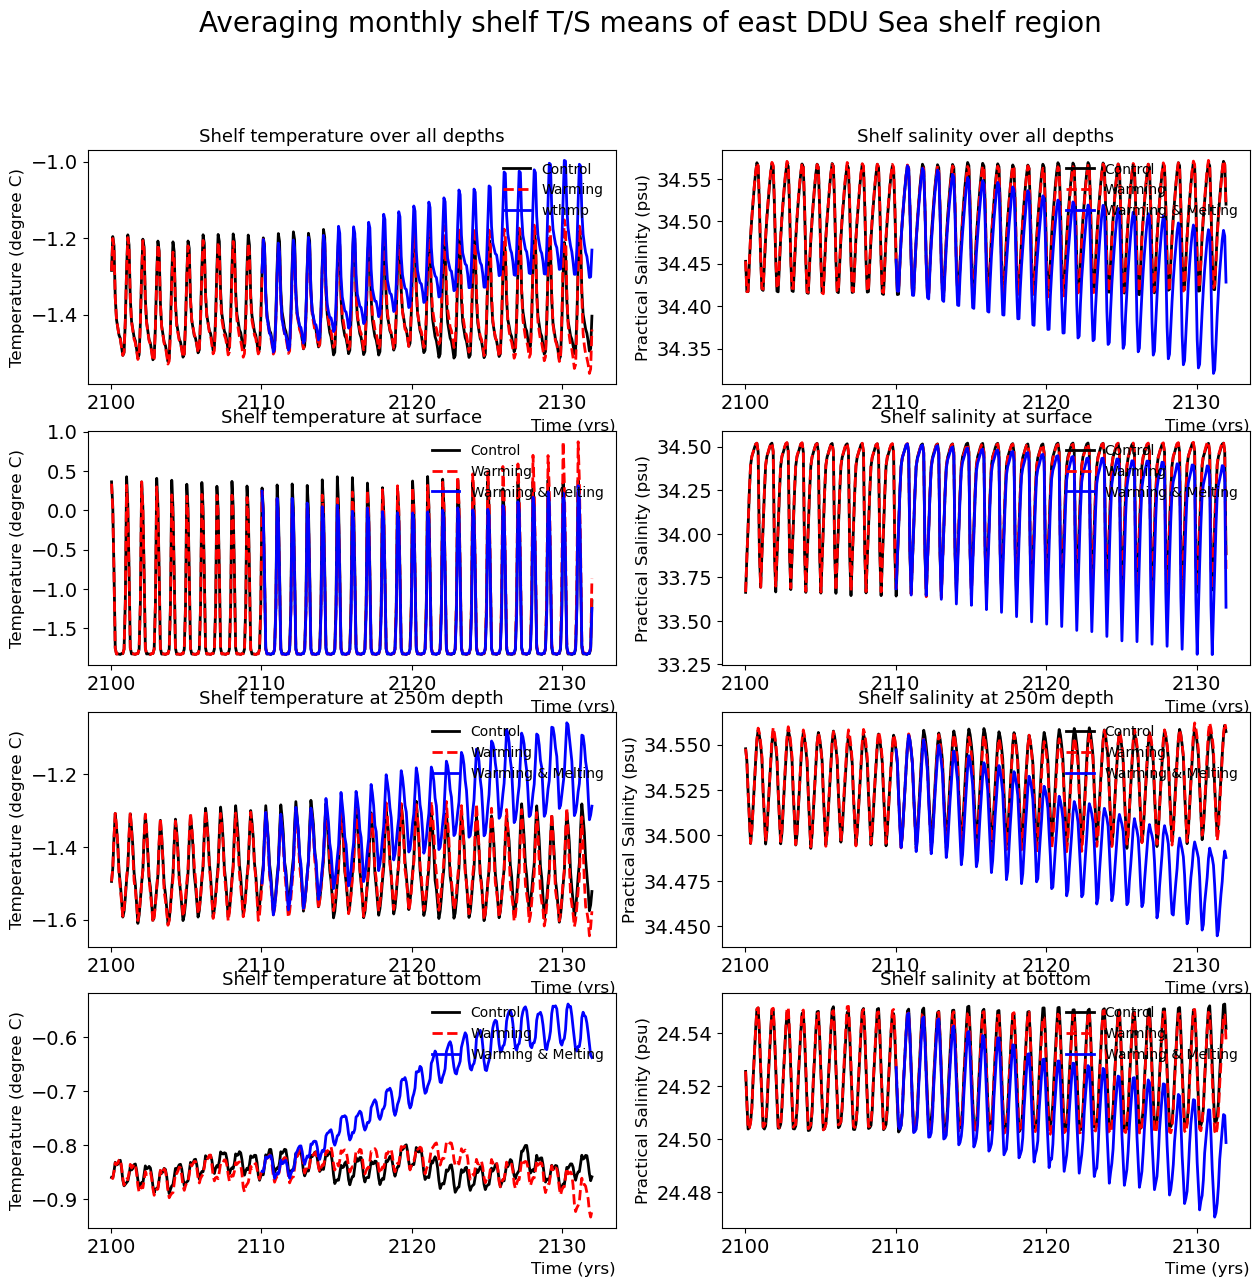

In [74]:
#Plotting time series for different regions for 359 months
fig = plt.figure(figsize=(15, 14))
fig.suptitle('Averaging monthly shelf T/S means of east DDU Sea shelf region', fontsize=20)

subplotting(temp_st_shelf_ryf_eDDU_monthly_mean,temp_st_shelf_wthp_eDDU_monthly_mean,
            temp_st_shelf_wthmp_eDDU_monthly_mean,'Shelf temperature over all depths','Temperature (degree C)',
            salt_st_shelf_ryf_eDDU_monthly_mean,salt_st_shelf_wthp_eDDU_monthly_mean,
            salt_st_shelf_wthmp_eDDU_monthly_mean,'Shelf salinity over all depths','Practical Salinity (psu)',
            temp_surface_shelf_ryf_eDDU_monthly_mean,temp_surface_shelf_wthp_eDDU_monthly_mean,
            temp_surface_shelf_wthmp_eDDU_monthly_mean,'Shelf temperature at surface','Temperature (degree C)',
            salt_surface_shelf_ryf_eDDU_monthly_mean,salt_surface_shelf_wthp_eDDU_monthly_mean,
            salt_surface_shelf_wthmp_eDDU_monthly_mean,'Shelf salinity at surface','Practical Salinity (psu)',
            temp_250m_shelf_ryf_eDDU_monthly_mean,temp_250m_shelf_wthp_eDDU_monthly_mean,
            temp_250m_shelf_wthmp_eDDU_monthly_mean,'Shelf temperature at 250m depth','Temperature (degree C)',
            salt_250m_shelf_ryf_eDDU_monthly_mean,salt_250m_shelf_wthp_eDDU_monthly_mean,
            salt_250m_shelf_wthmp_eDDU_monthly_mean,'Shelf salinity at 250m depth','Practical Salinity (psu)',
            temp_bottom_shelf_ryf_eDDU_monthly_mean,temp_bottom_shelf_wthp_eDDU_monthly_mean,
            temp_bottom_shelf_wthmp_eDDU_monthly_mean,'Shelf temperature at bottom','Temperature (degree C)',
            salt_bottom_shelf_ryf_eDDU_monthly_mean,salt_bottom_shelf_wthp_eDDU_monthly_mean,
            salt_bottom_shelf_wthmp_eDDU_monthly_mean,'Shelf salinity at bottom','Practical Salinity (psu)')

In [ ]:
#Plotting annually averaged time series for different regions (30 yrs)
fig = plt.figure(figsize=(15, 14))
fig.suptitle('Averaging annual shelf T/S means of east DDU Sea shelf region', fontsize=20)

subplotting(temp_st_shelf_ryf_eDDU_annual_mean,temp_st_shelf_wthp_eDDU_annual_mean,
            temp_st_shelf_wthmp_eDDU_annual_mean,'Shelf temperature over all depths','Temperature (degree C)',
            salt_st_shelf_ryf_eDDU_annual_mean,salt_st_shelf_wthp_eDDU_annual_mean,
            salt_st_shelf_wthmp_eDDU_annual_mean,'Shelf salinity over all depths','Practical Salinity (psu)',
            temp_surface_shelf_ryf_eDDU_annual_mean,temp_surface_shelf_wthp_eDDU_annual_mean,
            temp_surface_shelf_wthmp_eDDU_annual_mean,'Shelf temperature at surface','Temperature (degree C)',
            salt_surface_shelf_ryf_eDDU_annual_mean,salt_surface_shelf_wthp_eDDU_annual_mean,
            salt_surface_shelf_wthmp_eDDU_annual_mean,'Shelf salinity at surface','Practical Salinity (psu)',
            temp_250m_shelf_ryf_eDDU_annual_mean,temp_250m_shelf_wthp_eDDU_annual_mean,
            temp_250m_shelf_wthmp_eDDU_annual_mean,'Shelf temperature at 250m depth','Temperature (degree C)',
            salt_250m_shelf_ryf_eDDU_annual_mean,salt_250m_shelf_wthp_eDDU_annual_mean,
            salt_250m_shelf_wthmp_eDDU_annual_mean,'Shelf salinity at 250m depth','Practical Salinity (psu)',
            temp_bottom_shelf_ryf_eDDU_annual_mean,temp_bottom_shelf_wthp_eDDU_annual_mean,
            temp_bottom_shelf_wthmp_eDDU_annual_mean,'Shelf temperature at bottom','Temperature (degree C)',
            salt_bottom_shelf_ryf_eDDU_annual_mean,salt_bottom_shelf_wthp_eDDU_annual_mean,
            salt_bottom_shelf_wthmp_eDDU_annual_mean,'Shelf salinity at bottom','Practical Salinity (psu)')

In [ ]:
#Plotting anomaly time series for different regions for 359 months
fig = plt.figure(figsize=(15, 14))
fig.suptitle('Averaging monthly shelf T/S anomalies of east DDU Sea shelf region', fontsize=20)

subplotting(temp_st_shelf_ryf_eDDU_monthly_anom,temp_st_shelf_wthp_eDDU_monthly_anom,
            temp_st_shelf_wthmp_eDDU_monthly_anom,'Shelf temperature over all depths','Temperature (degree C)',
            salt_st_shelf_ryf_eDDU_monthly_anom,salt_st_shelf_wthp_eDDU_monthly_anom,
            salt_st_shelf_wthmp_eDDU_monthly_anom,'Shelf salinity over all depths','Practical Salinity (psu)',
            temp_surface_shelf_ryf_eDDU_monthly_anom,temp_surface_shelf_wthp_eDDU_monthly_anom,
            temp_surface_shelf_wthmp_eDDU_monthly_anom,'Shelf temperature at surface','Temperature (degree C)',
            salt_surface_shelf_ryf_eDDU_monthly_anom,salt_surface_shelf_wthp_eDDU_monthly_anom,
            salt_surface_shelf_wthmp_eDDU_monthly_anom,'Shelf salinity at surface','Practical Salinity (psu)',
            temp_250m_shelf_ryf_eDDU_monthly_anom,temp_250m_shelf_wthp_eDDU_monthly_anom,
            temp_250m_shelf_wthmp_eDDU_monthly_anom,'Shelf temperature at 250m depth','Temperature (degree C)',
            salt_250m_shelf_ryf_eDDU_monthly_anom,salt_250m_shelf_wthp_eDDU_monthly_anom,
            salt_250m_shelf_wthmp_eDDU_monthly_anom,'Shelf salinity at 250m depth','Practical Salinity (psu)',
            temp_bottom_shelf_ryf_eDDU_monthly_anom,temp_bottom_shelf_wthp_eDDU_monthly_anom,
            temp_bottom_shelf_wthmp_eDDU_monthly_anom,'Shelf temperature at bottom','Temperature (degree C)',
            salt_bottom_shelf_ryf_eDDU_monthly_anom,salt_bottom_shelf_wthp_eDDU_monthly_anom,
            salt_bottom_shelf_wthmp_eDDU_monthly_anom,'Shelf salinity at bottom','Practical Salinity (psu)')

In [ ]:
#Plotting annually averaged time series for different regions (30 yrs)
fig = plt.figure(figsize=(15, 14))
fig.suptitle('Averaging annual shelf T/S anomalies of east DDU Sea shelf region', fontsize=20)

subplotting(temp_st_shelf_ryf_eDDU_annual_anom,temp_st_shelf_wthp_eDDU_annual_anom,
            temp_st_shelf_wthmp_eDDU_annual_anom,'Shelf temperature over all depths','Temperature (degree C)',
            salt_st_shelf_ryf_eDDU_annual_anom,salt_st_shelf_wthp_eDDU_annual_anom,
            salt_st_shelf_wthmp_eDDU_annual_anom,'Shelf salinity over all depths','Practical Salinity (psu)',
            temp_surface_shelf_ryf_eDDU_annual_anom,temp_surface_shelf_wthp_eDDU_annual_anom,
            temp_surface_shelf_wthmp_eDDU_annual_anom,'Shelf temperature at surface','Temperature (degree C)',
            salt_surface_shelf_ryf_eDDU_annual_anom,salt_surface_shelf_wthp_eDDU_annual_anom,
            salt_surface_shelf_wthmp_eDDU_annual_anom,'Shelf salinity at surface','Practical Salinity (psu)',
            temp_250m_shelf_ryf_eDDU_annual_anom,temp_250m_shelf_wthp_eDDU_annual_anom,
            temp_250m_shelf_wthmp_eDDU_annual_anom,'Shelf temperature at 250m depth','Temperature (degree C)',
            salt_250m_shelf_ryf_eDDU_annual_anom,salt_250m_shelf_wthp_eDDU_annual_anom,
            salt_250m_shelf_wthmp_eDDU_annual_anom,'Shelf salinity at 250m depth','Practical Salinity (psu)',
            temp_bottom_shelf_ryf_eDDU_annual_anom,temp_bottom_shelf_wthp_eDDU_annual_anom,
            temp_bottom_shelf_wthmp_eDDU_annual_anom,'Shelf temperature at bottom','Temperature (degree C)',
            salt_bottom_shelf_ryf_eDDU_annual_anom,salt_bottom_shelf_wthp_eDDU_annual_anom,
            salt_bottom_shelf_wthmp_eDDU_annual_anom,'Shelf salinity at bottom','Practical Salinity (psu)')

In [ ]:
#Plotting among-experiments anomaly time series for different regions for 359 months
fig = plt.figure(figsize=(15, 14))
fig.suptitle('Averaging monthly shelf T/S anomalies among experiments of east DDU Sea shelf region', fontsize=20)

subplotting_monthly_anomaly(temp_st_shelf_ryf_eDDU_monthly_mean,temp_st_shelf_wthp_eDDU_monthly_mean,
            temp_st_shelf_wthmp_eDDU_monthly_mean,'Shelf temperature over all depths','Temperature (degree C)',
            salt_st_shelf_ryf_eDDU_monthly_mean,salt_st_shelf_wthp_eDDU_monthly_mean,
            salt_st_shelf_wthmp_eDDU_monthly_mean,'Shelf salinity over all depths','Practical Salinity (psu)',
            temp_surface_shelf_ryf_eDDU_monthly_mean,temp_surface_shelf_wthp_eDDU_monthly_mean,
            temp_surface_shelf_wthmp_eDDU_monthly_mean,'Shelf temperature at surface','Temperature (degree C)',
            salt_surface_shelf_ryf_eDDU_monthly_mean,salt_surface_shelf_wthp_eDDU_monthly_mean,
            salt_surface_shelf_wthmp_eDDU_monthly_mean,'Shelf salinity at surface','Practical Salinity (psu)',
            temp_250m_shelf_ryf_eDDU_monthly_mean,temp_250m_shelf_wthp_eDDU_monthly_mean,
            temp_250m_shelf_wthmp_eDDU_monthly_mean,'Shelf temperature at 250m depth','Temperature (degree C)',
            salt_250m_shelf_ryf_eDDU_monthly_mean,salt_250m_shelf_wthp_eDDU_monthly_mean,
            salt_250m_shelf_wthmp_eDDU_monthly_mean,'Shelf salinity at 250m depth','Practical Salinity (psu)',
            temp_bottom_shelf_ryf_eDDU_monthly_mean,temp_bottom_shelf_wthp_eDDU_monthly_mean,
            temp_bottom_shelf_wthmp_eDDU_monthly_mean,'Shelf temperature at bottom','Temperature (degree C)',
            salt_bottom_shelf_ryf_eDDU_monthly_mean,salt_bottom_shelf_wthp_eDDU_monthly_mean,
            salt_bottom_shelf_wthmp_eDDU_monthly_mean,'Shelf salinity at bottom','Practical Salinity (psu)')

## West Ross Sea coastal polynya shelf region

In [ ]:
#Plotting time series for different regions for 359 months
fig = plt.figure(figsize=(15, 14))
fig.suptitle('Averaging monthly shelf T/S means of west Ross Sea coastal shelf region', fontsize=20)

subplotting(temp_st_shelf_ryf_wRoss_monthly_mean,temp_st_shelf_wthp_wRoss_monthly_mean,
            temp_st_shelf_wthmp_wRoss_monthly_mean,'Shelf temperature over all depths','Temperature (degree C)',
            salt_st_shelf_ryf_wRoss_monthly_mean,salt_st_shelf_wthp_wRoss_monthly_mean,
            salt_st_shelf_wthmp_wRoss_monthly_mean,'Shelf salinity over all depths','Practical Salinity (psu)',
            temp_surface_shelf_ryf_wRoss_monthly_mean,temp_surface_shelf_wthp_wRoss_monthly_mean,
            temp_surface_shelf_wthmp_wRoss_monthly_mean,'Shelf temperature at surface','Temperature (degree C)',
            salt_surface_shelf_ryf_wRoss_monthly_mean,salt_surface_shelf_wthp_wRoss_monthly_mean,
            salt_surface_shelf_wthmp_wRoss_monthly_mean,'Shelf salinity at surface','Practical Salinity (psu)',
            temp_250m_shelf_ryf_wRoss_monthly_mean,temp_250m_shelf_wthp_wRoss_monthly_mean,
            temp_250m_shelf_wthmp_wRoss_monthly_mean,'Shelf temperature at 250m depth','Temperature (degree C)',
            salt_250m_shelf_ryf_wRoss_monthly_mean,salt_250m_shelf_wthp_wRoss_monthly_mean,
            salt_250m_shelf_wthmp_wRoss_monthly_mean,'Shelf salinity at 250m depth','Practical Salinity (psu)',
            temp_bottom_shelf_ryf_wRoss_monthly_mean,temp_bottom_shelf_wthp_wRoss_monthly_mean,
            temp_bottom_shelf_wthmp_wRoss_monthly_mean,'Shelf temperature at bottom','Temperature (degree C)',
            salt_bottom_shelf_ryf_wRoss_monthly_mean,salt_bottom_shelf_wthp_wRoss_monthly_mean,
            salt_bottom_shelf_wthmp_wRoss_monthly_mean,'Shelf salinity at bottom','Practical Salinity (psu)')

In [ ]:
#Plotting annually averaged anomaly time series for different regions (30 yrs)
fig = plt.figure(figsize=(15, 14))
fig.suptitle('Averaging annual shelf T/S means of west Ross Sea coastal shelf region', fontsize=20)

subplotting(temp_st_shelf_ryf_wRoss_annual_mean,temp_st_shelf_wthp_wRoss_annual_mean,
            temp_st_shelf_wthmp_wRoss_annual_mean,'Shelf temperature over all depths','Temperature (degree C)',
            salt_st_shelf_ryf_wRoss_annual_mean,salt_st_shelf_wthp_wRoss_annual_mean,
            salt_st_shelf_wthmp_wRoss_annual_mean,'Shelf salinity over all depths','Practical Salinity (psu)',
            temp_surface_shelf_ryf_wRoss_annual_mean,temp_surface_shelf_wthp_wRoss_annual_mean,
            temp_surface_shelf_wthmp_wRoss_annual_mean,'Shelf temperature at surface','Temperature (degree C)',
            salt_surface_shelf_ryf_wRoss_annual_mean,salt_surface_shelf_wthp_wRoss_annual_mean,
            salt_surface_shelf_wthmp_wRoss_annual_mean,'Shelf salinity at surface','Practical Salinity (psu)',
            temp_250m_shelf_ryf_wRoss_annual_mean,temp_250m_shelf_wthp_wRoss_annual_mean,
            temp_250m_shelf_wthmp_wRoss_annual_mean,'Shelf temperature at 250m depth','Temperature (degree C)',
            salt_250m_shelf_ryf_wRoss_annual_mean,salt_250m_shelf_wthp_wRoss_annual_mean,
            salt_250m_shelf_wthmp_wRoss_annual_mean,'Shelf salinity at 250m depth','Practical Salinity (psu)',
            temp_bottom_shelf_ryf_wRoss_annual_mean,temp_bottom_shelf_wthp_wRoss_annual_mean,
            temp_bottom_shelf_wthmp_wRoss_annual_mean,'Shelf temperature at bottom','Temperature (degree C)',
            salt_bottom_shelf_ryf_wRoss_annual_mean,salt_bottom_shelf_wthp_wRoss_annual_mean,
            salt_bottom_shelf_wthmp_wRoss_annual_mean,'Shelf salinity at bottom','Practical Salinity (psu)')

In [ ]:
#Plotting anomaly time series for different regions for 359 months
fig = plt.figure(figsize=(15, 14))
fig.suptitle('Averaging monthly shelf T/S anomalies of west Ross Sea coastal shelf region', fontsize=20)

subplotting(temp_st_shelf_ryf_wRoss_monthly_anom,temp_st_shelf_wthp_wRoss_monthly_anom,
            temp_st_shelf_wthmp_wRoss_monthly_anom,'Shelf temperature over all depths','Temperature (degree C)',
            salt_st_shelf_ryf_wRoss_monthly_anom,salt_st_shelf_wthp_wRoss_monthly_anom,
            salt_st_shelf_wthmp_wRoss_monthly_anom,'Shelf salinity over all depths','Practical Salinity (psu)',
            temp_surface_shelf_ryf_wRoss_monthly_anom,temp_surface_shelf_wthp_wRoss_monthly_anom,
            temp_surface_shelf_wthmp_wRoss_monthly_anom,'Shelf temperature at surface','Temperature (degree C)',
            salt_surface_shelf_ryf_wRoss_monthly_anom,salt_surface_shelf_wthp_wRoss_monthly_anom,
            salt_surface_shelf_wthmp_wRoss_monthly_anom,'Shelf salinity at surface','Practical Salinity (psu)',
            temp_250m_shelf_ryf_wRoss_monthly_anom,temp_250m_shelf_wthp_wRoss_monthly_anom,
            temp_250m_shelf_wthmp_wRoss_monthly_anom,'Shelf temperature at 250m depth','Temperature (degree C)',
            salt_250m_shelf_ryf_wRoss_monthly_anom,salt_250m_shelf_wthp_wRoss_monthly_anom,
            salt_250m_shelf_wthmp_wRoss_monthly_anom,'Shelf salinity at 250m depth','Practical Salinity (psu)',
            temp_bottom_shelf_ryf_wRoss_monthly_anom,temp_bottom_shelf_wthp_wRoss_monthly_anom,
            temp_bottom_shelf_wthmp_wRoss_monthly_anom,'Shelf temperature at bottom','Temperature (degree C)',
            salt_bottom_shelf_ryf_wRoss_monthly_anom,salt_bottom_shelf_wthp_wRoss_monthly_anom,
            salt_bottom_shelf_wthmp_wRoss_monthly_anom,'Shelf salinity at bottom','Practical Salinity (psu)')

In [ ]:
#Plotting annually averaged time series for different regions (30 yrs)
fig = plt.figure(figsize=(15, 14))
fig.suptitle('Averaging annual shelf T/S anomalies of west Ross Sea coastal shelf region', fontsize=20)

subplotting(temp_st_shelf_ryf_wRoss_annual_anom,temp_st_shelf_wthp_wRoss_annual_anom,
            temp_st_shelf_wthmp_wRoss_annual_anom,'Shelf temperature over all depths','Temperature (degree C)',
            salt_st_shelf_ryf_wRoss_annual_anom,salt_st_shelf_wthp_wRoss_annual_anom,
            salt_st_shelf_wthmp_wRoss_annual_anom,'Shelf salinity over all depths','Practical Salinity (psu)',
            temp_surface_shelf_ryf_wRoss_annual_anom,temp_surface_shelf_wthp_wRoss_annual_anom,
            temp_surface_shelf_wthmp_wRoss_annual_anom,'Shelf temperature at surface','Temperature (degree C)',
            salt_surface_shelf_ryf_wRoss_annual_anom,salt_surface_shelf_wthp_wRoss_annual_anom,
            salt_surface_shelf_wthmp_wRoss_annual_anom,'Shelf salinity at surface','Practical Salinity (psu)',
            temp_250m_shelf_ryf_wRoss_annual_anom,temp_250m_shelf_wthp_wRoss_annual_anom,
            temp_250m_shelf_wthmp_wRoss_annual_anom,'Shelf temperature at 250m depth','Temperature (degree C)',
            salt_250m_shelf_ryf_wRoss_annual_anom,salt_250m_shelf_wthp_wRoss_annual_anom,
            salt_250m_shelf_wthmp_wRoss_annual_anom,'Shelf salinity at 250m depth','Practical Salinity (psu)',
            temp_bottom_shelf_ryf_wRoss_annual_anom,temp_bottom_shelf_wthp_wRoss_annual_anom,
            temp_bottom_shelf_wthmp_wRoss_annual_anom,'Shelf temperature at bottom','Temperature (degree C)',
            salt_bottom_shelf_ryf_wRoss_annual_anom,salt_bottom_shelf_wthp_wRoss_annual_anom,
            salt_bottom_shelf_wthmp_wRoss_annual_anom,'Shelf salinity at bottom','Practical Salinity (psu)')

In [ ]:
#Plotting among-experiments anomaly time series for different regions for 359 months
fig = plt.figure(figsize=(15, 14))
fig.suptitle('Averaging monthly shelf T/S anomalies among experiments of west Ross Sea coastal shelf region', fontsize=20)

subplotting_monthly_anomaly(temp_st_shelf_ryf_wRoss_monthly_mean,temp_st_shelf_wthp_wRoss_monthly_mean,
            temp_st_shelf_wthmp_wRoss_monthly_mean,'Shelf temperature over all depths','Temperature (degree C)',
            salt_st_shelf_ryf_wRoss_monthly_mean,salt_st_shelf_wthp_wRoss_monthly_mean,
            salt_st_shelf_wthmp_wRoss_monthly_mean,'Shelf salinity over all depths','Practical Salinity (psu)',
            temp_surface_shelf_ryf_wRoss_monthly_mean,temp_surface_shelf_wthp_wRoss_monthly_mean,
            temp_surface_shelf_wthmp_wRoss_monthly_mean,'Shelf temperature at surface','Temperature (degree C)',
            salt_surface_shelf_ryf_wRoss_monthly_mean,salt_surface_shelf_wthp_wRoss_monthly_mean,
            salt_surface_shelf_wthmp_wRoss_monthly_mean,'Shelf salinity at surface','Practical Salinity (psu)',
            temp_250m_shelf_ryf_wRoss_monthly_mean,temp_250m_shelf_wthp_wRoss_monthly_mean,
            temp_250m_shelf_wthmp_wRoss_monthly_mean,'Shelf temperature at 250m depth','Temperature (degree C)',
            salt_250m_shelf_ryf_wRoss_monthly_mean,salt_250m_shelf_wthp_wRoss_monthly_mean,
            salt_250m_shelf_wthmp_wRoss_monthly_mean,'Shelf salinity at 250m depth','Practical Salinity (psu)',
            temp_bottom_shelf_ryf_wRoss_monthly_mean,temp_bottom_shelf_wthp_wRoss_monthly_mean,
            temp_bottom_shelf_wthmp_wRoss_monthly_mean,'Shelf temperature at bottom','Temperature (degree C)',
            salt_bottom_shelf_ryf_wRoss_monthly_mean,salt_bottom_shelf_wthp_wRoss_monthly_mean,
            salt_bottom_shelf_wthmp_wRoss_monthly_mean,'Shelf salinity at bottom','Practical Salinity (psu)')

## East Ross Sea coastal polynya shelf region

In [ ]:
#Plotting time series for different regions for 359 months
fig = plt.figure(figsize=(15, 14))
fig.suptitle('Averaging monthly shelf T/S means of east Ross Sea coastal shelf region', fontsize=20)

subplotting(temp_st_shelf_ryf_eRoss_monthly_mean,temp_st_shelf_wthp_eRoss_monthly_mean,
            temp_st_shelf_wthmp_eRoss_monthly_mean,'Shelf temperature over all depths','Temperature (degree C)',
            salt_st_shelf_ryf_eRoss_monthly_mean,salt_st_shelf_wthp_eRoss_monthly_mean,
            salt_st_shelf_wthmp_eRoss_monthly_mean,'Shelf salinity over all depths','Practical Salinity (psu)',
            temp_surface_shelf_ryf_eRoss_monthly_mean,temp_surface_shelf_wthp_eRoss_monthly_mean,
            temp_surface_shelf_wthmp_eRoss_monthly_mean,'Shelf temperature at surface','Temperature (degree C)',
            salt_surface_shelf_ryf_eRoss_monthly_mean,salt_surface_shelf_wthp_eRoss_monthly_mean,
            salt_surface_shelf_wthmp_eRoss_monthly_mean,'Shelf salinity at surface','Practical Salinity (psu)',
            temp_250m_shelf_ryf_eRoss_monthly_mean,temp_250m_shelf_wthp_eRoss_monthly_mean,
            temp_250m_shelf_wthmp_eRoss_monthly_mean,'Shelf temperature at 250m depth','Temperature (degree C)',
            salt_250m_shelf_ryf_eRoss_monthly_mean,salt_250m_shelf_wthp_eRoss_monthly_mean,
            salt_250m_shelf_wthmp_eRoss_monthly_mean,'Shelf salinity at 250m depth','Practical Salinity (psu)',
            temp_bottom_shelf_ryf_eRoss_monthly_mean,temp_bottom_shelf_wthp_eRoss_monthly_mean,
            temp_bottom_shelf_wthmp_eRoss_monthly_mean,'Shelf temperature at bottom','Temperature (degree C)',
            salt_bottom_shelf_ryf_eRoss_monthly_mean,salt_bottom_shelf_wthp_eRoss_monthly_mean,
            salt_bottom_shelf_wthmp_eRoss_monthly_mean,'Shelf salinity at bottom','Practical Salinity (psu)')

In [ ]:
#Plotting annually averaged anomaly time series for different regions (30 yrs)
fig = plt.figure(figsize=(15, 14))
fig.suptitle('Averaging annual shelf T/S means of east Ross Sea coastal shelf region', fontsize=20)

subplotting(temp_st_shelf_ryf_eRoss_annual_mean,temp_st_shelf_wthp_eRoss_annual_mean,
            temp_st_shelf_wthmp_eRoss_annual_mean,'Shelf temperature over all depths','Temperature (degree C)',
            salt_st_shelf_ryf_eRoss_annual_mean,salt_st_shelf_wthp_eRoss_annual_mean,
            salt_st_shelf_wthmp_eRoss_annual_mean,'Shelf salinity over all depths','Practical Salinity (psu)',
            temp_surface_shelf_ryf_eRoss_annual_mean,temp_surface_shelf_wthp_eRoss_annual_mean,
            temp_surface_shelf_wthmp_eRoss_annual_mean,'Shelf temperature at surface','Temperature (degree C)',
            salt_surface_shelf_ryf_eRoss_annual_mean,salt_surface_shelf_wthp_eRoss_annual_mean,
            salt_surface_shelf_wthmp_eRoss_annual_mean,'Shelf salinity at surface','Practical Salinity (psu)',
            temp_250m_shelf_ryf_eRoss_annual_mean,temp_250m_shelf_wthp_eRoss_annual_mean,
            temp_250m_shelf_wthmp_eRoss_annual_mean,'Shelf temperature at 250m depth','Temperature (degree C)',
            salt_250m_shelf_ryf_eRoss_annual_mean,salt_250m_shelf_wthp_eRoss_annual_mean,
            salt_250m_shelf_wthmp_eRoss_annual_mean,'Shelf salinity at 250m depth','Practical Salinity (psu)',
            temp_bottom_shelf_ryf_eRoss_annual_mean,temp_bottom_shelf_wthp_eRoss_annual_mean,
            temp_bottom_shelf_wthmp_eRoss_annual_mean,'Shelf temperature at bottom','Temperature (degree C)',
            salt_bottom_shelf_ryf_eRoss_annual_mean,salt_bottom_shelf_wthp_eRoss_annual_mean,
            salt_bottom_shelf_wthmp_eRoss_annual_mean,'Shelf salinity at bottom','Practical Salinity (psu)')

In [ ]:
#Plotting anomaly time series for different regions for 359 months
fig = plt.figure(figsize=(15, 14))
fig.suptitle('Averaging monthly shelf T/S anomalies of east Ross Sea coastal shelf region', fontsize=20)

subplotting(temp_st_shelf_ryf_eRoss_monthly_anom,temp_st_shelf_wthp_eRoss_monthly_anom,
            temp_st_shelf_wthmp_eRoss_monthly_anom,'Shelf temperature over all depths','Temperature (degree C)',
            salt_st_shelf_ryf_eRoss_monthly_anom,salt_st_shelf_wthp_eRoss_monthly_anom,
            salt_st_shelf_wthmp_eRoss_monthly_anom,'Shelf salinity over all depths','Practical Salinity (psu)',
            temp_surface_shelf_ryf_eRoss_monthly_anom,temp_surface_shelf_wthp_eRoss_monthly_anom,
            temp_surface_shelf_wthmp_eRoss_monthly_anom,'Shelf temperature at surface','Temperature (degree C)',
            salt_surface_shelf_ryf_eRoss_monthly_anom,salt_surface_shelf_wthp_eRoss_monthly_anom,
            salt_surface_shelf_wthmp_eRoss_monthly_anom,'Shelf salinity at surface','Practical Salinity (psu)',
            temp_250m_shelf_ryf_eRoss_monthly_anom,temp_250m_shelf_wthp_eRoss_monthly_anom,
            temp_250m_shelf_wthmp_eRoss_monthly_anom,'Shelf temperature at 250m depth','Temperature (degree C)',
            salt_250m_shelf_ryf_eRoss_monthly_anom,salt_250m_shelf_wthp_eRoss_monthly_anom,
            salt_250m_shelf_wthmp_eRoss_monthly_anom,'Shelf salinity at 250m depth','Practical Salinity (psu)',
            temp_bottom_shelf_ryf_eRoss_monthly_anom,temp_bottom_shelf_wthp_eRoss_monthly_anom,
            temp_bottom_shelf_wthmp_eRoss_monthly_anom,'Shelf temperature at bottom','Temperature (degree C)',
            salt_bottom_shelf_ryf_eRoss_monthly_anom,salt_bottom_shelf_wthp_eRoss_monthly_anom,
            salt_bottom_shelf_wthmp_eRoss_monthly_anom,'Shelf salinity at bottom','Practical Salinity (psu)')

In [ ]:
#Plotting annually averaged time series for different regions (30 yrs)
fig = plt.figure(figsize=(15, 14))
fig.suptitle('Averaging annual shelf T/S anomalies of east Ross Sea coastal shelf region', fontsize=20)

subplotting(temp_st_shelf_ryf_eRoss_annual_anom,temp_st_shelf_wthp_eRoss_annual_anom,
            temp_st_shelf_wthmp_eRoss_annual_anom,'Shelf temperature over all depths','Temperature (degree C)',
            salt_st_shelf_ryf_eRoss_annual_anom,salt_st_shelf_wthp_eRoss_annual_anom,
            salt_st_shelf_wthmp_eRoss_annual_anom,'Shelf salinity over all depths','Practical Salinity (psu)',
            temp_surface_shelf_ryf_eRoss_annual_anom,temp_surface_shelf_wthp_eRoss_annual_anom,
            temp_surface_shelf_wthmp_eRoss_annual_anom,'Shelf temperature at surface','Temperature (degree C)',
            salt_surface_shelf_ryf_eRoss_annual_anom,salt_surface_shelf_wthp_eRoss_annual_anom,
            salt_surface_shelf_wthmp_eRoss_annual_anom,'Shelf salinity at surface','Practical Salinity (psu)',
            temp_250m_shelf_ryf_eRoss_annual_anom,temp_250m_shelf_wthp_eRoss_annual_anom,
            temp_250m_shelf_wthmp_eRoss_annual_anom,'Shelf temperature at 250m depth','Temperature (degree C)',
            salt_250m_shelf_ryf_eRoss_annual_anom,salt_250m_shelf_wthp_eRoss_annual_anom,
            salt_250m_shelf_wthmp_eRoss_annual_anom,'Shelf salinity at 250m depth','Practical Salinity (psu)',
            temp_bottom_shelf_ryf_eRoss_annual_anom,temp_bottom_shelf_wthp_eRoss_annual_anom,
            temp_bottom_shelf_wthmp_eRoss_annual_anom,'Shelf temperature at bottom','Temperature (degree C)',
            salt_bottom_shelf_ryf_eRoss_annual_anom,salt_bottom_shelf_wthp_eRoss_annual_anom,
            salt_bottom_shelf_wthmp_eRoss_annual_anom,'Shelf salinity at bottom','Practical Salinity (psu)')

In [ ]:
#Plotting among-experiments anomaly time series for different regions for 359 months
fig = plt.figure(figsize=(15, 14))
fig.suptitle('Averaging monthly shelf T/S anomalies among experiments of east Ross Sea coastal shelf region', fontsize=20)

subplotting_monthly_anomaly(temp_st_shelf_ryf_eRoss_monthly_mean,temp_st_shelf_wthp_eRoss_monthly_mean,
            temp_st_shelf_wthmp_eRoss_monthly_mean,'Shelf temperature over all depths','Temperature (degree C)',
            salt_st_shelf_ryf_eRoss_monthly_mean,salt_st_shelf_wthp_eRoss_monthly_mean,
            salt_st_shelf_wthmp_eRoss_monthly_mean,'Shelf salinity over all depths','Practical Salinity (psu)',
            temp_surface_shelf_ryf_eRoss_monthly_mean,temp_surface_shelf_wthp_eRoss_monthly_mean,
            temp_surface_shelf_wthmp_eRoss_monthly_mean,'Shelf temperature at surface','Temperature (degree C)',
            salt_surface_shelf_ryf_eRoss_monthly_mean,salt_surface_shelf_wthp_eRoss_monthly_mean,
            salt_surface_shelf_wthmp_eRoss_monthly_mean,'Shelf salinity at surface','Practical Salinity (psu)',
            temp_250m_shelf_ryf_eRoss_monthly_mean,temp_250m_shelf_wthp_eRoss_monthly_mean,
            temp_250m_shelf_wthmp_eRoss_monthly_mean,'Shelf temperature at 250m depth','Temperature (degree C)',
            salt_250m_shelf_ryf_eRoss_monthly_mean,salt_250m_shelf_wthp_eRoss_monthly_mean,
            salt_250m_shelf_wthmp_eRoss_monthly_mean,'Shelf salinity at 250m depth','Practical Salinity (psu)',
            temp_bottom_shelf_ryf_eRoss_monthly_mean,temp_bottom_shelf_wthp_eRoss_monthly_mean,
            temp_bottom_shelf_wthmp_eRoss_monthly_mean,'Shelf temperature at bottom','Temperature (degree C)',
            salt_bottom_shelf_ryf_eRoss_monthly_mean,salt_bottom_shelf_wthp_eRoss_monthly_mean,
            salt_bottom_shelf_wthmp_eRoss_monthly_mean,'Shelf salinity at bottom','Practical Salinity (psu)')

## Amundsen-Bellingshausen Seas shelf region

In [ ]:
#Plotting time series for different regions for 359 months
fig = plt.figure(figsize=(15, 14))
fig.suptitle('Averaging monthly shelf T/S means of Amundsen-Bellingshausen Seas shelf region', fontsize=20)

subplotting(temp_st_shelf_ryf_AB_monthly_mean,temp_st_shelf_wthp_AB_monthly_mean,
            temp_st_shelf_wthmp_AB_monthly_mean,'Shelf temperature over all depths','Temperature (degree C)',
            salt_st_shelf_ryf_AB_monthly_mean,salt_st_shelf_wthp_AB_monthly_mean,
            salt_st_shelf_wthmp_AB_monthly_mean,'Shelf salinity over all depths','Practical Salinity (psu)',
            temp_surface_shelf_ryf_AB_monthly_mean,temp_surface_shelf_wthp_AB_monthly_mean,
            temp_surface_shelf_wthmp_AB_monthly_mean,'Shelf temperature at surface','Temperature (degree C)',
            salt_surface_shelf_ryf_AB_monthly_mean,salt_surface_shelf_wthp_AB_monthly_mean,
            salt_surface_shelf_wthmp_AB_monthly_mean,'Shelf salinity at surface','Practical Salinity (psu)',
            temp_250m_shelf_ryf_AB_monthly_mean,temp_250m_shelf_wthp_AB_monthly_mean,
            temp_250m_shelf_wthmp_AB_monthly_mean,'Shelf temperature at 250m depth','Temperature (degree C)',
            salt_250m_shelf_ryf_AB_monthly_mean,salt_250m_shelf_wthp_AB_monthly_mean,
            salt_250m_shelf_wthmp_AB_monthly_mean,'Shelf salinity at 250m depth','Practical Salinity (psu)',
            temp_bottom_shelf_ryf_AB_monthly_mean,temp_bottom_shelf_wthp_AB_monthly_mean,
            temp_bottom_shelf_wthmp_AB_monthly_mean,'Shelf temperature at bottom','Temperature (degree C)',
            salt_bottom_shelf_ryf_AB_monthly_mean,salt_bottom_shelf_wthp_AB_monthly_mean,
            salt_bottom_shelf_wthmp_AB_monthly_mean,'Shelf salinity at bottom','Practical Salinity (psu)')

In [ ]:
#Plotting annually averaged anomaly time series for different regions (30 yrs)
fig = plt.figure(figsize=(15, 14))
fig.suptitle('Averaging annual shelf T/S means of Amundsen-Bellingshausen Seas shelf region', fontsize=20)

subplotting(temp_st_shelf_ryf_AB_annual_mean,temp_st_shelf_wthp_AB_annual_mean,
            temp_st_shelf_wthmp_AB_annual_mean,'Shelf temperature over all depths','Temperature (degree C)',
            salt_st_shelf_ryf_AB_annual_mean,salt_st_shelf_wthp_AB_annual_mean,
            salt_st_shelf_wthmp_AB_annual_mean,'Shelf salinity over all depths','Practical Salinity (psu)',
            temp_surface_shelf_ryf_AB_annual_mean,temp_surface_shelf_wthp_AB_annual_mean,
            temp_surface_shelf_wthmp_AB_annual_mean,'Shelf temperature at surface','Temperature (degree C)',
            salt_surface_shelf_ryf_AB_annual_mean,salt_surface_shelf_wthp_AB_annual_mean,
            salt_surface_shelf_wthmp_AB_annual_mean,'Shelf salinity at surface','Practical Salinity (psu)',
            temp_250m_shelf_ryf_AB_annual_mean,temp_250m_shelf_wthp_AB_annual_mean,
            temp_250m_shelf_wthmp_AB_annual_mean,'Shelf temperature at 250m depth','Temperature (degree C)',
            salt_250m_shelf_ryf_AB_annual_mean,salt_250m_shelf_wthp_AB_annual_mean,
            salt_250m_shelf_wthmp_AB_annual_mean,'Shelf salinity at 250m depth','Practical Salinity (psu)',
            temp_bottom_shelf_ryf_AB_annual_mean,temp_bottom_shelf_wthp_AB_annual_mean,
            temp_bottom_shelf_wthmp_AB_annual_mean,'Shelf temperature at bottom','Temperature (degree C)',
            salt_bottom_shelf_ryf_AB_annual_mean,salt_bottom_shelf_wthp_AB_annual_mean,
            salt_bottom_shelf_wthmp_AB_annual_mean,'Shelf salinity at bottom','Practical Salinity (psu)')

In [ ]:
#Plotting anomaly time series for different regions for 359 months
fig = plt.figure(figsize=(15, 14))
fig.suptitle('Averaging monthly shelf T/S anomalies of Amundsen-Bellingshausen Seas shelf region', fontsize=20)

subplotting(temp_st_shelf_ryf_AB_monthly_anom,temp_st_shelf_wthp_AB_monthly_anom,
            temp_st_shelf_wthmp_AB_monthly_anom,'Shelf temperature over all depths','Temperature (degree C)',
            salt_st_shelf_ryf_AB_monthly_anom,salt_st_shelf_wthp_AB_monthly_anom,
            salt_st_shelf_wthmp_AB_monthly_anom,'Shelf salinity over all depths','Practical Salinity (psu)',
            temp_surface_shelf_ryf_AB_monthly_anom,temp_surface_shelf_wthp_AB_monthly_anom,
            temp_surface_shelf_wthmp_AB_monthly_anom,'Shelf temperature at surface','Temperature (degree C)',
            salt_surface_shelf_ryf_AB_monthly_anom,salt_surface_shelf_wthp_AB_monthly_anom,
            salt_surface_shelf_wthmp_AB_monthly_anom,'Shelf salinity at surface','Practical Salinity (psu)',
            temp_250m_shelf_ryf_AB_monthly_anom,temp_250m_shelf_wthp_AB_monthly_anom,
            temp_250m_shelf_wthmp_AB_monthly_anom,'Shelf temperature at 250m depth','Temperature (degree C)',
            salt_250m_shelf_ryf_AB_monthly_anom,salt_250m_shelf_wthp_AB_monthly_anom,
            salt_250m_shelf_wthmp_AB_monthly_anom,'Shelf salinity at 250m depth','Practical Salinity (psu)',
            temp_bottom_shelf_ryf_AB_monthly_anom,temp_bottom_shelf_wthp_AB_monthly_anom,
            temp_bottom_shelf_wthmp_AB_monthly_anom,'Shelf temperature at bottom','Temperature (degree C)',
            salt_bottom_shelf_ryf_AB_monthly_anom,salt_bottom_shelf_wthp_AB_monthly_anom,
            salt_bottom_shelf_wthmp_AB_monthly_anom,'Shelf salinity at bottom','Practical Salinity (psu)')

In [ ]:
#Plotting annually averaged time series for different regions (30 yrs)
fig = plt.figure(figsize=(15, 14))
fig.suptitle('Averaging annual shelf T/S anomalies of Amundsen-Bellingshausen Seas shelf region', fontsize=20)

subplotting(temp_st_shelf_ryf_AB_annual_anom,temp_st_shelf_wthp_AB_annual_anom,
            temp_st_shelf_wthmp_AB_annual_anom,'Shelf temperature over all depths','Temperature (degree C)',
            salt_st_shelf_ryf_AB_annual_anom,salt_st_shelf_wthp_AB_annual_anom,
            salt_st_shelf_wthmp_AB_annual_anom,'Shelf salinity over all depths','Practical Salinity (psu)',
            temp_surface_shelf_ryf_AB_annual_anom,temp_surface_shelf_wthp_AB_annual_anom,
            temp_surface_shelf_wthmp_AB_annual_anom,'Shelf temperature at surface','Temperature (degree C)',
            salt_surface_shelf_ryf_AB_annual_anom,salt_surface_shelf_wthp_AB_annual_anom,
            salt_surface_shelf_wthmp_AB_annual_anom,'Shelf salinity at surface','Practical Salinity (psu)',
            temp_250m_shelf_ryf_AB_annual_anom,temp_250m_shelf_wthp_AB_annual_anom,
            temp_250m_shelf_wthmp_AB_annual_anom,'Shelf temperature at 250m depth','Temperature (degree C)',
            salt_250m_shelf_ryf_AB_annual_anom,salt_250m_shelf_wthp_AB_annual_anom,
            salt_250m_shelf_wthmp_AB_annual_anom,'Shelf salinity at 250m depth','Practical Salinity (psu)',
            temp_bottom_shelf_ryf_AB_annual_anom,temp_bottom_shelf_wthp_AB_annual_anom,
            temp_bottom_shelf_wthmp_AB_annual_anom,'Shelf temperature at bottom','Temperature (degree C)',
            salt_bottom_shelf_ryf_AB_annual_anom,salt_bottom_shelf_wthp_AB_annual_anom,
            salt_bottom_shelf_wthmp_AB_annual_anom,'Shelf salinity at bottom','Practical Salinity (psu)')

In [ ]:
#Plotting among-experiments anomaly time series for different regions for 359 months
fig = plt.figure(figsize=(15, 14))
fig.suptitle('Averaging monthly shelf T/S anomalies among experiments of Amundsen-Bellingshausen Seas shelf region', fontsize=20)

subplotting_monthly_anomaly(temp_st_shelf_ryf_AB_monthly_mean,temp_st_shelf_wthp_AB_monthly_mean,
            temp_st_shelf_wthmp_AB_monthly_mean,'Shelf temperature over all depths','Temperature (degree C)',
            salt_st_shelf_ryf_AB_monthly_mean,salt_st_shelf_wthp_AB_monthly_mean,
            salt_st_shelf_wthmp_AB_monthly_mean,'Shelf salinity over all depths','Practical Salinity (psu)',
            temp_surface_shelf_ryf_AB_monthly_mean,temp_surface_shelf_wthp_AB_monthly_mean,
            temp_surface_shelf_wthmp_AB_monthly_mean,'Shelf temperature at surface','Temperature (degree C)',
            salt_surface_shelf_ryf_AB_monthly_mean,salt_surface_shelf_wthp_AB_monthly_mean,
            salt_surface_shelf_wthmp_AB_monthly_mean,'Shelf salinity at surface','Practical Salinity (psu)',
            temp_250m_shelf_ryf_AB_monthly_mean,temp_250m_shelf_wthp_AB_monthly_mean,
            temp_250m_shelf_wthmp_AB_monthly_mean,'Shelf temperature at 250m depth','Temperature (degree C)',
            salt_250m_shelf_ryf_AB_monthly_mean,salt_250m_shelf_wthp_AB_monthly_mean,
            salt_250m_shelf_wthmp_AB_monthly_mean,'Shelf salinity at 250m depth','Practical Salinity (psu)',
            temp_bottom_shelf_ryf_AB_monthly_mean,temp_bottom_shelf_wthp_AB_monthly_mean,
            temp_bottom_shelf_wthmp_AB_monthly_mean,'Shelf temperature at bottom','Temperature (degree C)',
            salt_bottom_shelf_ryf_AB_monthly_mean,salt_bottom_shelf_wthp_AB_monthly_mean,
            salt_bottom_shelf_wthmp_AB_monthly_mean,'Shelf salinity at bottom','Practical Salinity (psu)')

## Peak of West Antarctic Peninsula shelf region

In [ ]:
#Plotting time series for different regions for 359 months
fig = plt.figure(figsize=(15, 14))
fig.suptitle('Averaging monthly shelf T/S means of West Antarctic Peninsula peak shelf region', fontsize=20)

subplotting(temp_st_shelf_ryf_pWAP_monthly_mean,temp_st_shelf_wthp_pWAP_monthly_mean,
            temp_st_shelf_wthmp_pWAP_monthly_mean,'Shelf temperature over all depths','Temperature (degree C)',
            salt_st_shelf_ryf_pWAP_monthly_mean,salt_st_shelf_wthp_pWAP_monthly_mean,
            salt_st_shelf_wthmp_pWAP_monthly_mean,'Shelf salinity over all depths','Practical Salinity (psu)',
            temp_surface_shelf_ryf_pWAP_monthly_mean,temp_surface_shelf_wthp_pWAP_monthly_mean,
            temp_surface_shelf_wthmp_pWAP_monthly_mean,'Shelf temperature at surface','Temperature (degree C)',
            salt_surface_shelf_ryf_pWAP_monthly_mean,salt_surface_shelf_wthp_pWAP_monthly_mean,
            salt_surface_shelf_wthmp_pWAP_monthly_mean,'Shelf salinity at surface','Practical Salinity (psu)',
            temp_250m_shelf_ryf_pWAP_monthly_mean,temp_250m_shelf_wthp_pWAP_monthly_mean,
            temp_250m_shelf_wthmp_pWAP_monthly_mean,'Shelf temperature at 250m depth','Temperature (degree C)',
            salt_250m_shelf_ryf_pWAP_monthly_mean,salt_250m_shelf_wthp_pWAP_monthly_mean,
            salt_250m_shelf_wthmp_pWAP_monthly_mean,'Shelf salinity at 250m depth','Practical Salinity (psu)',
            temp_bottom_shelf_ryf_pWAP_monthly_mean,temp_bottom_shelf_wthp_pWAP_monthly_mean,
            temp_bottom_shelf_wthmp_pWAP_monthly_mean,'Shelf temperature at bottom','Temperature (degree C)',
            salt_bottom_shelf_ryf_pWAP_monthly_mean,salt_bottom_shelf_wthp_pWAP_monthly_mean,
            salt_bottom_shelf_wthmp_pWAP_monthly_mean,'Shelf salinity at bottom','Practical Salinity (psu)')

In [ ]:
#Plotting annually averaged anomaly time series for different regions (30 yrs)
fig = plt.figure(figsize=(15, 14))
fig.suptitle('Averaging annual shelf T/S means of West Antarctic Peninsula peak shelf region', fontsize=20)

subplotting(temp_st_shelf_ryf_pWAP_annual_mean,temp_st_shelf_wthp_pWAP_annual_mean,
            temp_st_shelf_wthmp_pWAP_annual_mean,'Shelf temperature over all depths','Temperature (degree C)',
            salt_st_shelf_ryf_pWAP_annual_mean,salt_st_shelf_wthp_pWAP_annual_mean,
            salt_st_shelf_wthmp_pWAP_annual_mean,'Shelf salinity over all depths','Practical Salinity (psu)',
            temp_surface_shelf_ryf_pWAP_annual_mean,temp_surface_shelf_wthp_pWAP_annual_mean,
            temp_surface_shelf_wthmp_pWAP_annual_mean,'Shelf temperature at surface','Temperature (degree C)',
            salt_surface_shelf_ryf_pWAP_annual_mean,salt_surface_shelf_wthp_pWAP_annual_mean,
            salt_surface_shelf_wthmp_pWAP_annual_mean,'Shelf salinity at surface','Practical Salinity (psu)',
            temp_250m_shelf_ryf_pWAP_annual_mean,temp_250m_shelf_wthp_pWAP_annual_mean,
            temp_250m_shelf_wthmp_pWAP_annual_mean,'Shelf temperature at 250m depth','Temperature (degree C)',
            salt_250m_shelf_ryf_pWAP_annual_mean,salt_250m_shelf_wthp_pWAP_annual_mean,
            salt_250m_shelf_wthmp_pWAP_annual_mean,'Shelf salinity at 250m depth','Practical Salinity (psu)',
            temp_bottom_shelf_ryf_pWAP_annual_mean,temp_bottom_shelf_wthp_pWAP_annual_mean,
            temp_bottom_shelf_wthmp_pWAP_annual_mean,'Shelf temperature at bottom','Temperature (degree C)',
            salt_bottom_shelf_ryf_pWAP_annual_mean,salt_bottom_shelf_wthp_pWAP_annual_mean,
            salt_bottom_shelf_wthmp_pWAP_annual_mean,'Shelf salinity at bottom','Practical Salinity (psu)')

In [ ]:
#Plotting anomaly time series for different regions for 359 months
fig = plt.figure(figsize=(15, 14))
fig.suptitle('Averaging monthly shelf T/S anomalies of West Antarctic Peninsula peak shelf region', fontsize=20)

subplotting(temp_st_shelf_ryf_pWAP_monthly_anom,temp_st_shelf_wthp_pWAP_monthly_anom,
            temp_st_shelf_wthmp_pWAP_monthly_anom,'Shelf temperature over all depths','Temperature (degree C)',
            salt_st_shelf_ryf_pWAP_monthly_anom,salt_st_shelf_wthp_pWAP_monthly_anom,
            salt_st_shelf_wthmp_pWAP_monthly_anom,'Shelf salinity over all depths','Practical Salinity (psu)',
            temp_surface_shelf_ryf_pWAP_monthly_anom,temp_surface_shelf_wthp_pWAP_monthly_anom,
            temp_surface_shelf_wthmp_pWAP_monthly_anom,'Shelf temperature at surface','Temperature (degree C)',
            salt_surface_shelf_ryf_pWAP_monthly_anom,salt_surface_shelf_wthp_pWAP_monthly_anom,
            salt_surface_shelf_wthmp_pWAP_monthly_anom,'Shelf salinity at surface','Practical Salinity (psu)',
            temp_250m_shelf_ryf_pWAP_monthly_anom,temp_250m_shelf_wthp_pWAP_monthly_anom,
            temp_250m_shelf_wthmp_pWAP_monthly_anom,'Shelf temperature at 250m depth','Temperature (degree C)',
            salt_250m_shelf_ryf_pWAP_monthly_anom,salt_250m_shelf_wthp_pWAP_monthly_anom,
            salt_250m_shelf_wthmp_pWAP_monthly_anom,'Shelf salinity at 250m depth','Practical Salinity (psu)',
            temp_bottom_shelf_ryf_pWAP_monthly_anom,temp_bottom_shelf_wthp_pWAP_monthly_anom,
            temp_bottom_shelf_wthmp_pWAP_monthly_anom,'Shelf temperature at bottom','Temperature (degree C)',
            salt_bottom_shelf_ryf_pWAP_monthly_anom,salt_bottom_shelf_wthp_pWAP_monthly_anom,
            salt_bottom_shelf_wthmp_pWAP_monthly_anom,'Shelf salinity at bottom','Practical Salinity (psu)')

In [ ]:
#Plotting annually averaged time series for different regions (30 yrs)
fig = plt.figure(figsize=(15, 14))
fig.suptitle('Averaging annual shelf T/S anomalies of West Antarctic Peninsula peak shelf region', fontsize=20)

subplotting(temp_st_shelf_ryf_pWAP_annual_anom,temp_st_shelf_wthp_pWAP_annual_anom,
            temp_st_shelf_wthmp_pWAP_annual_anom,'Shelf temperature over all depths','Temperature (degree C)',
            salt_st_shelf_ryf_pWAP_annual_anom,salt_st_shelf_wthp_pWAP_annual_anom,
            salt_st_shelf_wthmp_pWAP_annual_anom,'Shelf salinity over all depths','Practical Salinity (psu)',
            temp_surface_shelf_ryf_pWAP_annual_anom,temp_surface_shelf_wthp_pWAP_annual_anom,
            temp_surface_shelf_wthmp_pWAP_annual_anom,'Shelf temperature at surface','Temperature (degree C)',
            salt_surface_shelf_ryf_pWAP_annual_anom,salt_surface_shelf_wthp_pWAP_annual_anom,
            salt_surface_shelf_wthmp_pWAP_annual_anom,'Shelf salinity at surface','Practical Salinity (psu)',
            temp_250m_shelf_ryf_pWAP_annual_anom,temp_250m_shelf_wthp_pWAP_annual_anom,
            temp_250m_shelf_wthmp_pWAP_annual_anom,'Shelf temperature at 250m depth','Temperature (degree C)',
            salt_250m_shelf_ryf_pWAP_annual_anom,salt_250m_shelf_wthp_pWAP_annual_anom,
            salt_250m_shelf_wthmp_pWAP_annual_anom,'Shelf salinity at 250m depth','Practical Salinity (psu)',
            temp_bottom_shelf_ryf_pWAP_annual_anom,temp_bottom_shelf_wthp_pWAP_annual_anom,
            temp_bottom_shelf_wthmp_pWAP_annual_anom,'Shelf temperature at bottom','Temperature (degree C)',
            salt_bottom_shelf_ryf_pWAP_annual_anom,salt_bottom_shelf_wthp_pWAP_annual_anom,
            salt_bottom_shelf_wthmp_pWAP_annual_anom,'Shelf salinity at bottom','Practical Salinity (psu)')

In [ ]:
#Plotting among-experiments anomaly time series for different regions for 359 months
fig = plt.figure(figsize=(15, 14))
fig.suptitle('Averaging monthly shelf T/S anomalies among experiments of West Antarctic Peninsula peak shelf region', fontsize=20)

subplotting_monthly_anomaly(temp_st_shelf_ryf_pWAP_monthly_mean,temp_st_shelf_wthp_pWAP_monthly_mean,
            temp_st_shelf_wthmp_pWAP_monthly_mean,'Shelf temperature over all depths','Temperature (degree C)',
            salt_st_shelf_ryf_pWAP_monthly_mean,salt_st_shelf_wthp_pWAP_monthly_mean,
            salt_st_shelf_wthmp_pWAP_monthly_mean,'Shelf salinity over all depths','Practical Salinity (psu)',
            temp_surface_shelf_ryf_pWAP_monthly_mean,temp_surface_shelf_wthp_pWAP_monthly_mean,
            temp_surface_shelf_wthmp_pWAP_monthly_mean,'Shelf temperature at surface','Temperature (degree C)',
            salt_surface_shelf_ryf_pWAP_monthly_mean,salt_surface_shelf_wthp_pWAP_monthly_mean,
            salt_surface_shelf_wthmp_pWAP_monthly_mean,'Shelf salinity at surface','Practical Salinity (psu)',
            temp_250m_shelf_ryf_pWAP_monthly_mean,temp_250m_shelf_wthp_pWAP_monthly_mean,
            temp_250m_shelf_wthmp_pWAP_monthly_mean,'Shelf temperature at 250m depth','Temperature (degree C)',
            salt_250m_shelf_ryf_pWAP_monthly_mean,salt_250m_shelf_wthp_pWAP_monthly_mean,
            salt_250m_shelf_wthmp_pWAP_monthly_mean,'Shelf salinity at 250m depth','Practical Salinity (psu)',
            temp_bottom_shelf_ryf_pWAP_monthly_mean,temp_bottom_shelf_wthp_pWAP_monthly_mean,
            temp_bottom_shelf_wthmp_pWAP_monthly_mean,'Shelf temperature at bottom','Temperature (degree C)',
            salt_bottom_shelf_ryf_pWAP_monthly_mean,salt_bottom_shelf_wthp_pWAP_monthly_mean,
            salt_bottom_shelf_wthmp_pWAP_monthly_mean,'Shelf salinity at bottom','Practical Salinity (psu)')

## Weddell Sea shelf region

In [ ]:
#Plotting among-experiments anomaly time series for different regions for 359 months
fig = plt.figure(figsize=(15, 14))
fig.suptitle('Averaging monthly shelf T/S anomalies among experiments of Weddell Sea shelf region', fontsize=20)

subplotting_monthly_anomaly(temp_st_shelf_ryf_Weddell_monthly_mean,temp_st_shelf_wthp_Weddell_monthly_mean,
            temp_st_shelf_wthmp_Weddell_monthly_mean,'Shelf temperature over all depths','Temperature (degree C)',
            salt_st_shelf_ryf_Weddell_monthly_mean,salt_st_shelf_wthp_Weddell_monthly_mean,
            salt_st_shelf_wthmp_Weddell_monthly_mean,'Shelf salinity over all depths','Practical Salinity (psu)',
            temp_surface_shelf_ryf_Weddell_monthly_mean,temp_surface_shelf_wthp_Weddell_monthly_mean,
            temp_surface_shelf_wthmp_Weddell_monthly_mean,'Shelf temperature at surface','Temperature (degree C)',
            salt_surface_shelf_ryf_Weddell_monthly_mean,salt_surface_shelf_wthp_Weddell_monthly_mean,
            salt_surface_shelf_wthmp_Weddell_monthly_mean,'Shelf salinity at surface','Practical Salinity (psu)',
            temp_250m_shelf_ryf_Weddell_monthly_mean,temp_250m_shelf_wthp_Weddell_monthly_mean,
            temp_250m_shelf_wthmp_Weddell_monthly_mean,'Shelf temperature at 250m depth','Temperature (degree C)',
            salt_250m_shelf_ryf_Weddell_monthly_mean,salt_250m_shelf_wthp_Weddell_monthly_mean,
            salt_250m_shelf_wthmp_Weddell_monthly_mean,'Shelf salinity at 250m depth','Practical Salinity (psu)',
            temp_bottom_shelf_ryf_Weddell_monthly_mean,temp_bottom_shelf_wthp_Weddell_monthly_mean,
            temp_bottom_shelf_wthmp_Weddell_monthly_mean,'Shelf temperature at bottom','Temperature (degree C)',
            salt_bottom_shelf_ryf_Weddell_monthly_mean,salt_bottom_shelf_wthp_Weddell_monthly_mean,
            salt_bottom_shelf_wthmp_Weddell_monthly_mean,'Shelf salinity at bottom','Practical Salinity (psu)')

## Prydz Bay shelf region

In [ ]:
#Plotting among-experiments anomaly time series for different regions for 359 months
fig = plt.figure(figsize=(15, 14))
fig.suptitle('Averaging monthly shelf T/S anomalies among experiments of Prydz Bay shelf region', fontsize=20)

subplotting_monthly_anomaly(temp_st_shelf_ryf_Prydz_monthly_mean,temp_st_shelf_wthp_Prydz_monthly_mean,
            temp_st_shelf_wthmp_Prydz_monthly_mean,'Shelf temperature over all depths','Temperature (degree C)',
            salt_st_shelf_ryf_Prydz_monthly_mean,salt_st_shelf_wthp_Prydz_monthly_mean,
            salt_st_shelf_wthmp_Prydz_monthly_mean,'Shelf salinity over all depths','Practical Salinity (psu)',
            temp_surface_shelf_ryf_Prydz_monthly_mean,temp_surface_shelf_wthp_Prydz_monthly_mean,
            temp_surface_shelf_wthmp_Prydz_monthly_mean,'Shelf temperature at surface','Temperature (degree C)',
            salt_surface_shelf_ryf_Prydz_monthly_mean,salt_surface_shelf_wthp_Prydz_monthly_mean,
            salt_surface_shelf_wthmp_Prydz_monthly_mean,'Shelf salinity at surface','Practical Salinity (psu)',
            temp_250m_shelf_ryf_Prydz_monthly_mean,temp_250m_shelf_wthp_Prydz_monthly_mean,
            temp_250m_shelf_wthmp_Prydz_monthly_mean,'Shelf temperature at 250m depth','Temperature (degree C)',
            salt_250m_shelf_ryf_Prydz_monthly_mean,salt_250m_shelf_wthp_Prydz_monthly_mean,
            salt_250m_shelf_wthmp_Prydz_monthly_mean,'Shelf salinity at 250m depth','Practical Salinity (psu)',
            temp_bottom_shelf_ryf_Prydz_monthly_mean,temp_bottom_shelf_wthp_Prydz_monthly_mean,
            temp_bottom_shelf_wthmp_Prydz_monthly_mean,'Shelf temperature at bottom','Temperature (degree C)',
            salt_bottom_shelf_ryf_Prydz_monthly_mean,salt_bottom_shelf_wthp_Prydz_monthly_mean,
            salt_bottom_shelf_wthmp_Prydz_monthly_mean,'Shelf salinity at bottom','Practical Salinity (psu)')